In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

import torch

%cd //172.18.36.77/datasets/continual-learning-baselines

project_name = 'CGQA'

\\172.18.36.77\datasets\continual-learning-baselines


# Show Continual Training Results

In [3]:
def get_accs(exp_name, name='Top1_Acc_Stream/eval_phase/test_stream'):
    if not os.path.exists(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{exp_name}.npy')):
        return np.array([[np.nan]])
    results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{exp_name}.npy'), allow_pickle=True)
    accs = []
    for i in range(len(results)):
        accs.append([])
        for k, v in results[i].items():
            if k.startswith(name):
                accs[i].append(v)
        # accs[i] = sum(accs[i]) / float(len(accs[i]))        # if need average results in task-IL
    # accs = [results[i]['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for i in range(len(results))]
    return np.array(accs)

def get_accs_with_mode(exp_name, mode='sys', project_name='CGQA', name='Top1_Acc_Stream/eval_phase/test_stream', prefix='-9', test_n_way=None):
    if not os.path.exists(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{exp_name}{prefix}.npy' if mode == "continual" else f'results-{exp_name}-{mode}-naive-frz.npy')):
        return np.array([[np.nan]])
    if mode == 'continual':
        results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{exp_name}{prefix}.npy'), allow_pickle=True)
    else:
        if test_n_way:
            file_name = f'results-{exp_name}-{mode}-naive-frz-test_n_way{test_n_way}.npy'
        else:
            file_name = f'results-{exp_name}-{mode}-naive-frz.npy'
        results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, file_name), allow_pickle=True)

    accs = []

    for k, v in results[-1].items():
        if k.startswith(name):
            accs.append(v)

    return np.array(accs)


In [4]:
import copy

def generate_params(common_args, param_grid, exp_name_template=None):
    keys = param_grid.keys()

    print(exp_name_template, param_grid)

    def unfold(_params, _param, _choice=None):
        """recursion to get all choice of params.
            _choice: (key, value)
        """
        _param = copy.deepcopy(_param)
        if _choice is not None:     # assign value
            _param[_choice[0]] = _choice[1]

        if len(_param.keys()) == len(keys):
            '''complete'''
            _params.append(_param)
        else:
            '''select 1 unsigned key and call unfold'''
            selected_key = sorted(keys - _param.keys(), key=list(keys).index)[0]
            for choice in param_grid[selected_key]:
                unfold(_params, _param, _choice=(selected_key, choice))

    '''Generate instance params for grid search in param_scope'''
    params = []
    unfold(params, dict(), None)

    for iter, param in enumerate(params):
        param.update(common_args)

    if exp_name_template is not None:
        for iter, param in enumerate(params):
            '''Generate exp_name according to param'''
            exp_name = exp_name_template.format(**param)
            if 'return_task_id' in param:
                exp_name = exp_name.replace('setting', 'tsk' if param['return_task_id'] else 'cls')
            exp_name = exp_name.replace('.', '_')      # for float, change '0.1' to '0_1' for potential problem in Windows.
            param['exp_name'] = exp_name

    return params

def generate_params_with_exp_name(common_args, param_grid, exp_name_template):
    keys = set(param_grid.keys())

    print(exp_name_template, param_grid)

    def unfold(_params, _param, _choice=None):
        """recursion to get all choice of params.
            _choice: (key, value)
        """
        _param = copy.deepcopy(_param)
        if _choice is not None:     # assign value
            _param[_choice[0]] = _choice[1]

        if len(_param.keys()) == len(keys):
            '''complete'''
            _params.append(_param)
        else:
            '''select 1 unsigned key and call unfold'''
            selected_key = list(keys - set(_param.keys()))[0]
            for choice in param_grid[selected_key]:
                unfold(_params, _param, _choice=(selected_key, choice))

    '''Generate instance params for grid search in param_scope'''
    params = []
    unfold(params, dict(), None)

    for iter, param in enumerate(params):
        '''Generate exp_name according to param'''
        param.update(common_args)
        exp_name = exp_name_template.format(**param)
        exp_name = exp_name.replace('.', '_')      # for float, change '0.1' to '0_1' for potential problem in Windows.
        param['exp_name'] = exp_name
        # print(param['exp_name'])

    return params


In [15]:
'''Load one exp'''
exp_name = 'HT-gem-tsk_True-lr1e-05-p32-m0_3'
results = np.load(os.path.join('../avalanche-experiments', project_name, exp_name, f'results-{exp_name}-2.npy'), allow_pickle=True)
last_result = results[-1]
# print('Average test acc:', get_average_metric(results[-1], 'Top1_Acc_Stream/eval_phase/test_stream'))

FileNotFoundError: [Errno 2] No such file or directory: '../avalanche-experiments\\CGQA\\HT-gem-tsk_True-lr1e-05-p32-m0_3\\results-HT-gem-tsk_True-lr1e-05-p32-m0_3-2.npy'

# forgetting vs 10-way fewshot

In [28]:
'''task-IL的forget， 包括 CGQA 10-tasks, COBJ 3-tasks, 5-tasks, 10-tasks
因为CGQA只有10-way的数据，所以都用10-way
'''

params = []
param_grid = {
    'strategy': ['naive', 'er', 'gem', 'lwf', 'ewc'],
    'return_task_id': [True],
    'num_tasks': [10],      # [3, 5, 10],
    'test_n_way': [10],
    'project_name': ['CGQA'],
}
params.extend(generate_params({}, param_grid))
param_grid = {
    'strategy': ['naive', 'er', 'gem', 'lwf', 'ewc'],
    'return_task_id': [True],
    'num_tasks': [3, 5, 10],      # [3, 5, 10],
    'test_n_way': [10],
    'project_name': ['COBJ'],
}
params.extend(generate_params({}, param_grid))
for param in params:
    param['exp_name'] = {
        'CGQA': {
            10: {
                True: {
                    'MT': 'MT-naive-tsk_True-lr0_001',
                    'naive': 'naive-tsk-lr0_008',
                    'er': 'er-tsk-lr0_0008',
                    'gem': 'gem-tsk-lr0_001-p32-m0_3',
                    'lwf': 'lwf-tsk-lr0_01-a1-t1',
                    'ewc': 'ewc-tsk-lr0_005-lambda2',
                },
                False: {
                    'MT': 'MT-naive-tsk_False-lr0_005',
                    'naive': 'naive-cls-lr0_003',
                    'er': 'er-cls-lr0_003',
                    'gem': 'gem-cls-lr0_01-p32-m0_3',
                    'lwf': 'lwf-cls-lr0_005-a1-t1',
                    'ewc': 'ewc-cls-lr0_005-lambda0_1',
                },
            },
        },
        'COBJ': {
            3: {
                True: {
                    'MT': 'HT-MT-3tasks-naive-tsk_True-lr0_001',
                    'naive': 'HT-naive-tsk_True-lr0_001',
                    'er': 'HT-er-tsk_True-lr0_01',
                    'gem': 'HT-gem-tsk_True-lr0_001-p16-m0_3',
                    'lwf': 'HT-lwf-tsk_True-lr0_001-a1-t2',
                    'ewc': 'HT-ewc-tsk_True-lr0_01-lambda100',
                },
                False: {
                    'MT': 'HT-MT-3tasks-naive-tsk_False-lr0_001',
                    'naive': 'HT-naive-tsk_False-lr0_001',
                    'er': 'HT-er-tsk_False-lr0_01',
                    'gem': 'HT-gem-tsk_False-lr0_001-p256-m0_00139',
                    'lwf': 'HT-lwf-tsk_False-lr0_001-a1-t1_52',
                    'ewc': 'HT-ewc-tsk_False-lr0_00053-lambda10',
                }
            },
            5: {
                True: {
                    'MT': 'HT-MT-5tasks-naive-tsk_True-lr0_001',
                    'naive': 'HT-5tasks-naive-tsk_True-lr0_01',
                    'er': 'HT-5tasks-er-tsk_True-lr0_001',
                    'gem': 'HT-5tasks-gem-tsk_True-lr0_01-p16-m0_3',
                    'lwf': 'HT-5tasks-lwf-tsk_True-lr0_001-a1-t2',
                    'ewc': 'HT-5tasks-ewc-tsk_True-lr0_001-lambda100',
                },
                False: {
                    'MT': 'HT-MT-5tasks-naive-tsk_False-lr0_001',
                    'naive': 'HT-5tasks-naive-tsk_False-lr0_001',
                    'er': 'HT-5tasks-er-tsk_False-lr0_001',
                    'gem': 'HT-5tasks-gem-tsk_False-lr0_01-p256-m0_00139',
                    'lwf': 'HT-5tasks-lwf-tsk_False-lr0_001-a1-t2',
                    'ewc': 'HT-5tasks-ewc-tsk_False-lr0_001-lambda10',
                }
            },
            10: {
                True: {
                    'MT': 'HT-MT-naive-tsk_True-lr0_00231',
                    'naive': 'HT-10tasks-naive-tsk_True-lr1e-05',
                    'er': 'HT-10tasks-er-tsk_True-lr0_001',
                    'gem': 'HT-10tasks-gem-tsk_True-lr0_001-p16-m0_3',
                    'lwf': 'HT-10tasks-lwf-tsk_True-lr1e-05-a1-t2',
                    'ewc': 'HT-10tasks-ewc-tsk_True-lr1e-05-lambda100',
                },
                False: {
                    'MT': 'HT-MT-naive-tsk_False-lr0_00123',
                    'naive': 'HT-10tasks-naive-tsk_False-lr0_001',
                    'er': 'HT-10tasks-er-tsk_False-lr0_001',
                    'gem': 'HT-10tasks-gem-tsk_False-lr0_001-p256-m0_00139',
                    'lwf': 'HT-10tasks-lwf-tsk_False-lr0_001-a1-t2',
                    'ewc': 'HT-10tasks-ewc-tsk_False-lr0_01-lambda10',
                }
            },
        }
    }[param['project_name']][param['num_tasks']][param['return_task_id']][param['strategy']]
    accs = {}
    for mode in ['sys', 'pro', 'non', 'noc']:
        acc_list = get_accs_with_mode(param['exp_name'], project_name=param['project_name'], mode=mode, test_n_way=param['test_n_way'] if param['project_name'] == 'COBJ' else None)  # [300]
        accs[mode] = np.mean(acc_list) * 100
        if np.isnan(accs[mode]):
            print(f'there is nan in {accs[mode]}')
            print('acc_list:', acc_list)
            raise Exception()
            # all_accs[np.isnan(all_accs)] = (all_accs[np.where(np.isnan(all_accs))[0]-1] + all_accs[(np.where(np.isnan(all_accs))[0]+1)]) / 2    # 1 nan in LwF
            # all_accs[np.isnan(all_accs)] = all_accs[np.where(np.isnan(all_accs))[0]-1]
            # all_accs[np.isnan(all_accs)] = 0
    param['Hn'] = 2 / (1/accs['sys'] + 1/accs['pro'])
    param['Hr'] = 2 / (1/accs['non'] + 1/accs['noc'])

    '''get forgetting'''
    fgts = get_accs_with_mode(param['exp_name'], mode='continual', project_name=param['project_name'], prefix=f'-{param["num_tasks"]-1}' if ('MT' not in param['exp_name'] and param['project_name'] == 'COBJ') else '', name='StreamForgetting/eval_phase/test_stream')
    assert len(fgts) == 1, f'wrong param: {param}'
    param['Forgetting'] = np.mean(fgts) * 100
    if np.isnan(np.mean(fgts)):
        print(f'there is nan in {fgts}')
        print(f'wrong param: {param}')
        raise Exception()

    param['Method'] = {'MT': 'MultiTask', 'naive': 'Finetune', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] else ''


None {'strategy': ['naive', 'er', 'gem', 'lwf', 'ewc'], 'return_task_id': [True], 'num_tasks': [10], 'test_n_way': [10], 'project_name': ['CGQA']}
None {'strategy': ['naive', 'er', 'gem', 'lwf', 'ewc'], 'return_task_id': [True], 'num_tasks': [3, 5, 10], 'test_n_way': [10], 'project_name': ['COBJ']}


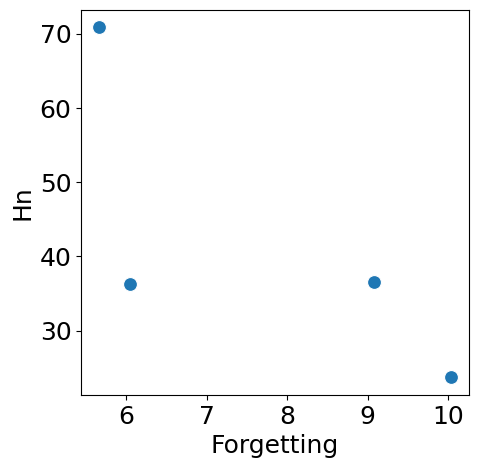

In [45]:

# for param in params:
#     param['Num of classes'] = param['test_n_way']

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(5, 5))
sns.set_palette('tab10')   #   tab10   Paired
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="Forgetting", y="Hn", data=collected_data[collected_data['Method']=='EWC*'], s=100)  # Accuracy, Score, Hn, Hr , hue='num_tasks'
# ax.legend_.remove()
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# COBJ varying way for fewshot tasks

In [17]:
'''train on 10tasks 3-way, test on 3-way, 6-way, 10-way'''
project_name = 'COBJ'

params = []

common_args = {}
param_grid = {
    'strategy': ['MT', 'naive', 'er', 'gem', 'lwf', 'ewc'],
    'return_task_id': [False, True],
    'num_tasks': [10],
    'test_n_way': [3, 10],  # [3, 6, 10],
}

params.extend(generate_params(common_args, param_grid))

for param in params:
    param['exp_name'] = {
        10: {
            True: {
                'MT': 'HT-MT-naive-tsk_True-lr0_00231',
                'naive': 'HT-10tasks-naive-tsk_True-lr1e-05',
                'er': 'HT-10tasks-er-tsk_True-lr0_001',
                'gem': 'HT-10tasks-gem-tsk_True-lr0_001-p16-m0_3',
                'lwf': 'HT-10tasks-lwf-tsk_True-lr1e-05-a1-t2',
                'ewc': 'HT-10tasks-ewc-tsk_True-lr1e-05-lambda100',
            },
            False: {
                'MT': 'HT-MT-naive-tsk_False-lr0_00123',
                'naive': 'HT-10tasks-naive-tsk_False-lr0_001',
                'er': 'HT-10tasks-er-tsk_False-lr0_001',
                'gem': 'HT-10tasks-gem-tsk_False-lr0_001-p256-m0_00139',
                'lwf': 'HT-10tasks-lwf-tsk_False-lr0_001-a1-t2',
                'ewc': 'HT-10tasks-ewc-tsk_False-lr0_01-lambda10',
            }
        },
    }[param['num_tasks']][param['return_task_id']][param['strategy']]


for param in params:
    accs = {}
    for mode in ['sys', 'pro', 'non', 'noc']:
        acc_list = get_accs_with_mode(param['exp_name'], project_name=project_name, mode=mode, test_n_way=param['test_n_way'])  # [300]
        accs[mode] = np.mean(acc_list) * 100
        if np.isnan(accs[mode]):
            print(f'there is nan in {accs[mode]}')
            print('acc_list:', acc_list)
            raise Exception()
            # all_accs[np.isnan(all_accs)] = (all_accs[np.where(np.isnan(all_accs))[0]-1] + all_accs[(np.where(np.isnan(all_accs))[0]+1)]) / 2    # 1 nan in LwF
            # all_accs[np.isnan(all_accs)] = all_accs[np.where(np.isnan(all_accs))[0]-1]
            # all_accs[np.isnan(all_accs)] = 0
    param['Hn'] = 2 / (1/accs['sys'] + 1/accs['pro'])
    param['Hr'] = 2 / (1/accs['non'] + 1/accs['noc'])
    param['Method'] = {'MT': 'MultiTask', 'naive': 'Finetune', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] else ''

'''add MNTDP and RPSnet'''
params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 10, 'test_n_way': 10, 'Hn': 39.40, 'Hr': 41.31,})
params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 10, 'test_n_way': 6, 'Hn': 0, 'Hr': 0,})
params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 10, 'test_n_way': 3, 'Hn': 70.47, 'Hr': 73.14,})

params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 10, 'test_n_way': 10, 'Hn': 19.55, 'Hr': 20.66,})
params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 10, 'test_n_way': 6, 'Hn': 29.38, 'Hr': 30.71,})
params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 10, 'test_n_way': 3, 'Hn': 50.49, 'Hr': 52.50,})


None {'strategy': ['MT', 'naive', 'er', 'gem', 'lwf', 'ewc'], 'return_task_id': [False, True], 'num_tasks': [10], 'test_n_way': [3, 10]}


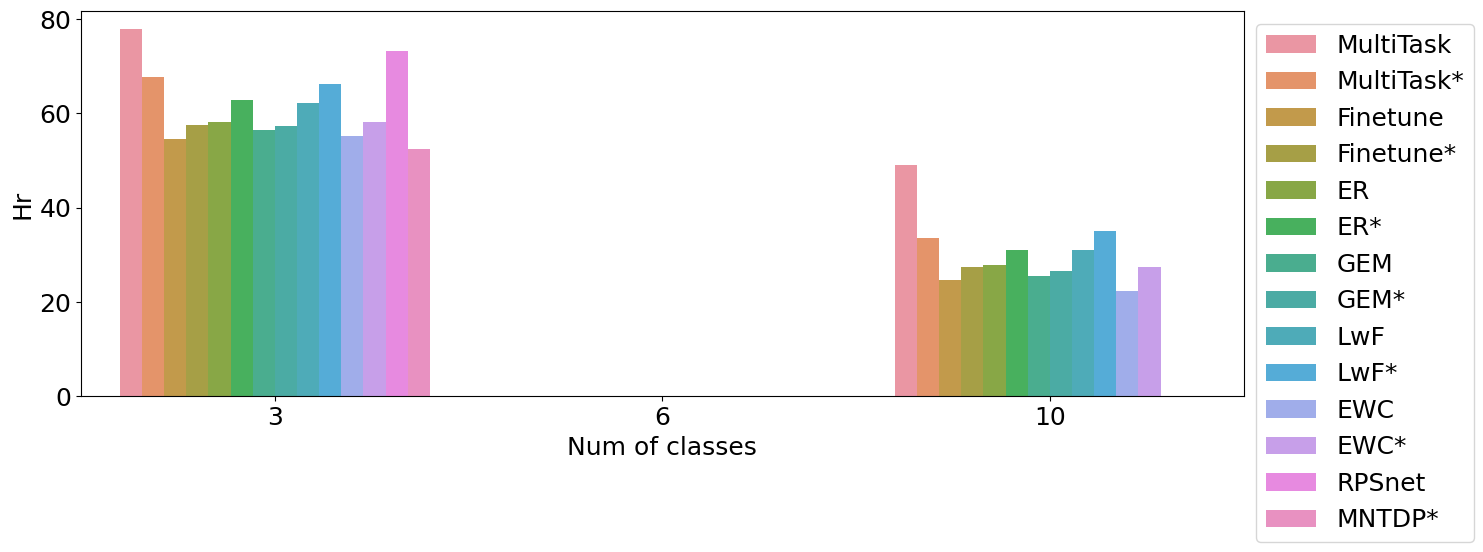

In [20]:

for param in params:
    param['Num of classes'] = param['test_n_way']

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(15, 5))
sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.barplot(x="Num of classes", y="Hr", data=collected_data, hue='Method')  # Accuracy, Score, Hn, Hr
# ax.legend_.remove()
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# COBJ different number of continual training tasks

In [13]:

project_name = 'COBJ'

test_n_way = 3      # [3, 6, 10]

params = []

common_args = {}
param_grid = {
    'strategy': ['MT', 'naive', 'er', 'gem', 'lwf', 'ewc'],
    'return_task_id': [False, True],
    'num_tasks': [3, 5, 10],
}
params.extend(generate_params(common_args, param_grid))

for param in params:
    param['exp_name'] = {
        3: {
            True: {
                'MT': 'HT-MT-3tasks-naive-tsk_True-lr0_001',
                'naive': 'HT-naive-tsk_True-lr0_001',
                'er': 'HT-er-tsk_True-lr0_01',
                'gem': 'HT-gem-tsk_True-lr0_001-p16-m0_3',
                'lwf': 'HT-lwf-tsk_True-lr0_001-a1-t2',
                'ewc': 'HT-ewc-tsk_True-lr0_01-lambda100',
            },
            False: {
                'MT': 'HT-MT-3tasks-naive-tsk_False-lr0_001',
                'naive': 'HT-naive-tsk_False-lr0_001',
                'er': 'HT-er-tsk_False-lr0_01',
                'gem': 'HT-gem-tsk_False-lr0_001-p256-m0_00139',
                'lwf': 'HT-lwf-tsk_False-lr0_001-a1-t1_52',
                'ewc': 'HT-ewc-tsk_False-lr0_00053-lambda10',
            }
        },
        5: {
            True: {
                'MT': 'HT-MT-5tasks-naive-tsk_True-lr0_001',
                'naive': 'HT-5tasks-naive-tsk_True-lr0_01',
                'er': 'HT-5tasks-er-tsk_True-lr0_001',
                'gem': 'HT-5tasks-gem-tsk_True-lr0_01-p16-m0_3',
                'lwf': 'HT-5tasks-lwf-tsk_True-lr0_001-a1-t2',
                'ewc': 'HT-5tasks-ewc-tsk_True-lr0_001-lambda100',
            },
            False: {
                'MT': 'HT-MT-5tasks-naive-tsk_False-lr0_001',
                'naive': 'HT-5tasks-naive-tsk_False-lr0_001',
                'er': 'HT-5tasks-er-tsk_False-lr0_001',
                'gem': 'HT-5tasks-gem-tsk_False-lr0_01-p256-m0_00139',
                'lwf': 'HT-5tasks-lwf-tsk_False-lr0_001-a1-t2',
                'ewc': 'HT-5tasks-ewc-tsk_False-lr0_001-lambda10',
            }
        },
        10: {
            True: {
                'MT': 'HT-MT-naive-tsk_True-lr0_00231',
                'naive': 'HT-10tasks-naive-tsk_True-lr1e-05',
                'er': 'HT-10tasks-er-tsk_True-lr0_001',
                'gem': 'HT-10tasks-gem-tsk_True-lr0_001-p16-m0_3',
                'lwf': 'HT-10tasks-lwf-tsk_True-lr1e-05-a1-t2',
                'ewc': 'HT-10tasks-ewc-tsk_True-lr1e-05-lambda100',
            },
            False: {
                'MT': 'HT-MT-naive-tsk_False-lr0_00123',
                'naive': 'HT-10tasks-naive-tsk_False-lr0_001',
                'er': 'HT-10tasks-er-tsk_False-lr0_001',
                'gem': 'HT-10tasks-gem-tsk_False-lr0_001-p256-m0_00139',
                'lwf': 'HT-10tasks-lwf-tsk_False-lr0_001-a1-t2',
                'ewc': 'HT-10tasks-ewc-tsk_False-lr0_01-lambda10',
            }
        },
    }[param['num_tasks']][param['return_task_id']][param['strategy']]

for param in params:
    accs = {}
    for mode in ['sys', 'pro', 'non', 'noc']:
        acc_list = get_accs_with_mode(param['exp_name'], project_name=project_name, mode=mode, test_n_way=test_n_way)  # [300]
        accs[mode] = np.mean(acc_list) * 100
        if np.isnan(accs[mode]):
            print(f'there is nan in {accs[mode]}')
            print('acc_list:', acc_list)
            raise Exception()
            # all_accs[np.isnan(all_accs)] = (all_accs[np.where(np.isnan(all_accs))[0]-1] + all_accs[(np.where(np.isnan(all_accs))[0]+1)]) / 2    # 1 nan in LwF
            # all_accs[np.isnan(all_accs)] = all_accs[np.where(np.isnan(all_accs))[0]-1]
            # all_accs[np.isnan(all_accs)] = 0
    param['Hn'] = 2 / (1/accs['sys'] + 1/accs['pro'])
    param['Hr'] = 2 / (1/accs['non'] + 1/accs['noc'])
    param['Method'] = {'MT': 'MultiTask', 'naive': 'Finetune', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] else ''

'''add MNTDP and RPSnet'''
if test_n_way == 10:
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 3, 'Hn': 47.58, 'Hr': 49.44,})
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 5, 'Hn': 43.93, 'Hr': 45.93,})
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 10, 'Hn': 39.40, 'Hr': 41.31,})
elif test_n_way == 6:
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 3, 'Hn': 0, 'Hr': 0,})
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 5, 'Hn': 0, 'Hr': 0,})
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 10, 'Hn': 0, 'Hr': 0,})
elif test_n_way == 3:
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 3, 'Hn': 0, 'Hr': 0,})
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 5, 'Hn': 0, 'Hr': 0,})
    params.append({'Method': 'RPSnet', 'return_task_id': False, 'num_tasks': 10, 'Hn': 70.47, 'Hr': 73.14,})

if test_n_way == 10:
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 3, 'Hn': 29.56, 'Hr': 30.90,})
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 5, 'Hn': 27.91, 'Hr': 28.43,})
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 10, 'Hn': 19.55, 'Hr': 20.66,})
elif test_n_way == 6:
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 3, 'Hn': 29.38, 'Hr': 30.71,})
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 5, 'Hn': 38.73, 'Hr': 39.47,})
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 10, 'Hn': 29.38, 'Hr': 30.71,})
elif test_n_way == 3:
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 3, 'Hn': 59.27, 'Hr': 62.24,})
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 5, 'Hn': 57.78, 'Hr': 60.23,})
    params.append({'Method': 'MNTDP*', 'return_task_id': True, 'num_tasks': 10, 'Hn': 50.49, 'Hr': 52.50,})


None {'strategy': ['MT', 'naive', 'er', 'gem', 'lwf', 'ewc'], 'return_task_id': [False, True], 'num_tasks': [3, 5, 10]}


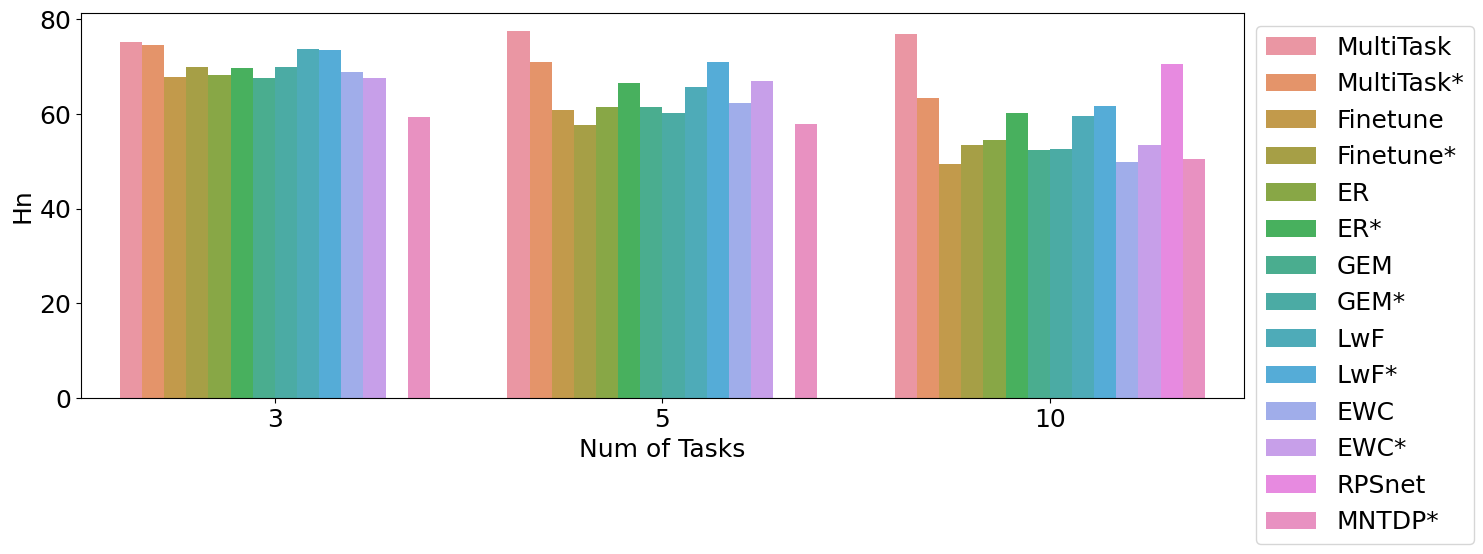

In [15]:

for param in params:
    param['Num of Tasks'] = param['num_tasks']

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(15, 5))
sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.barplot(x="Num of Tasks", y="Hn", data=collected_data, hue='Method')  # Accuracy, Score, Hn, Hr
# ax.legend_.remove()
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# COBJ baselines

HT-MT-5tasks-naive-tsk_{return_task_id}-lr{learning_rate} {'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'return_task_id': [False, True], 'mode': ['continual']}
HT-MT-5tasks-naive-tsk_False-lr0_0001: 29.96666666666667
HT-MT-5tasks-naive-tsk_True-lr0_0001: 51.866666666666674
HT-MT-5tasks-naive-tsk_False-lr0_001: 38.93333333333333
HT-MT-5tasks-naive-tsk_True-lr0_001: 58.3
HT-MT-5tasks-naive-tsk_False-lr0_01: 35.43333333333333
HT-MT-5tasks-naive-tsk_True-lr0_01: 56.8
HT-MT-5tasks-naive-tsk_False-lr0_1: 3.3333333333333335
HT-MT-5tasks-naive-tsk_True-lr0_1: 25.6
all_accs: [29.96666667 51.86666667 38.93333333 58.3        35.43333333 56.8
  3.33333333 25.6       ]


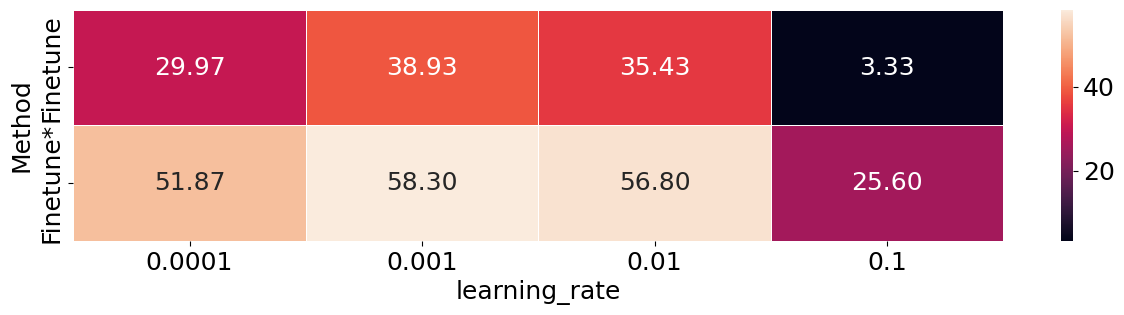

In [10]:

project_name = 'COBJ'

params = []
common_args = {}
common_args.update({
    'tag': 'HT-5tasks',
    'model_backbone': 'resnet18',
    'use_interactive_logger': False,
    'use_text_logger': True,
    'project_name': 'COBJ',
    'dataset': 'cobj',
})
prefix = '-4'
# MT
common_args.update({
    'tag': 'HT-MT-5tasks',
    'strategy': 'naive',
})
param_grid = {
    'learning_rate': np.around(np.logspace(-4, -1, num=4), decimals=5).tolist(),
    'return_task_id': [False, True],
    'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
}
exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
                    '-tsk_{return_task_id}' + \
                    '-lr{learning_rate}'
params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
params.extend(params_temp)
# # naive
# common_args.update({
#     'strategy': 'naive',
# })
# param_grid = {
#     'learning_rate': [1e-5, 1e-4, 0.001, 0.01],
#     'return_task_id': [False, True],
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)
# # er
# common_args.update({
#     'strategy': 'er',
# })
# param_grid = {
#     'learning_rate': [1e-4, 0.001, 0.01, 0.1],
#     'return_task_id': [False, True],
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)
# # gem
# common_args.update({
#     'strategy': 'gem',
# })
# param_grid = {
#     'learning_rate': [1e-4, 0.001, 0.01, 0.1],
#     'return_task_id': [False],
#     'gem_patterns_per_exp': [256],   # [16, 32, 64, 128, 256],
#     'gem_mem_strength': [0.00139],
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}-p{gem_patterns_per_exp}-m{gem_mem_strength}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)
# param_grid = {
#     'learning_rate': [1e-4, 0.001, 0.01, 0.1],
#     'return_task_id': [True],
#     'gem_patterns_per_exp': [16],   # [16, 32, 64, 128, 256],
#     'gem_mem_strength': [0.3],
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}-p{gem_patterns_per_exp}-m{gem_mem_strength}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)
# # lwf
# common_args.update({
#     'strategy': 'lwf',
# })
# param_grid = {
#     'learning_rate': [1e-5, 1e-4, 0.001, 0.01],
#     'return_task_id': [False, True],        # False, True
#     'lwf_alpha': [1],
#     'lwf_temperature': [2],
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}-a{lwf_alpha}-t{lwf_temperature}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)
# # ewc
# common_args.update({
#     'strategy': 'ewc',
# })
# param_grid = {
#     'learning_rate': [1e-5, 1e-4, 0.001, 0.01],
#     'return_task_id': [True],
#     'ewc_lambda': [100],   # [0.1, 1, 10, 100]
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}-lambda{ewc_lambda}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)
# param_grid = {
#     'learning_rate': [1e-5, 1e-4, 0.001, 0.01],
#     'return_task_id': [False],
#     'ewc_lambda': [10],   # [0.1, 1, 10, 100]
#     'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
# }
# exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
#                     '-tsk_{return_task_id}' + \
#                     '-lr{learning_rate}-lambda{ewc_lambda}'
# params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
# params.extend(params_temp)


all_accs = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], project_name=project_name, mode=params[i]['mode'], prefix=prefix if 'MT' not in params[i]['exp_name'] else '')) for i in range(len(params))])*100
all_accs[np.isnan(all_accs)] = 0

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = param['learning_rate']
    param['Method'] = {'naive': 'Finetune', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC', 'MT': 'MultiTask'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] is True else ''
    print(f'{param["exp_name"]}: {param["Accuracy"]}')
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
# plt.figure(figsize=(30, 2))
plt.figure(figsize=(15, 3))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="Weight", y="learning rate", data=collected_data, hue='Method')
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
ax = sns.heatmap(collected_data.pivot("Method", "learning_rate", "Accuracy"), annot=True, fmt=".2f", linewidth=.5)
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# Multi-label baselines

Multi_Label-concept-tsk_{return_task_id}-lr{learning_rate} {'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'return_task_id': [True, False], 'mode': ['continual']}
all_accs: [11.79  0.82 10.75  1.4  11.    0.57  9.21  1.48]


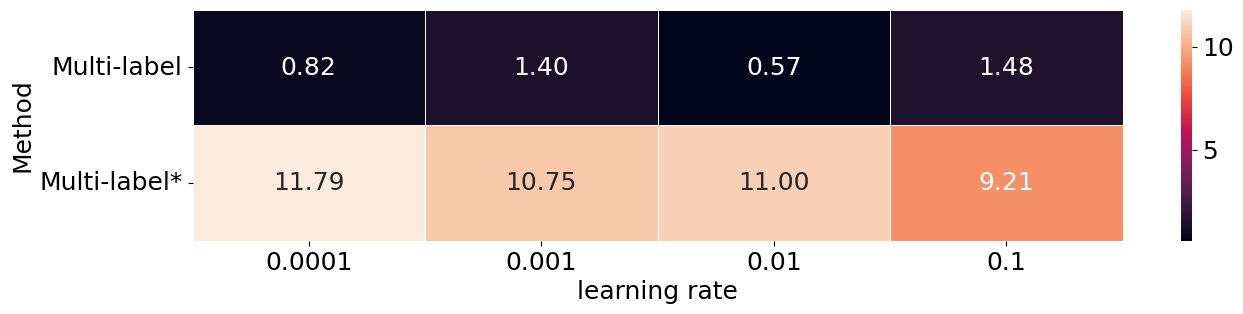

In [8]:


params = []
common_args = {}
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'return_task_id': [True, False],
    'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
}
common_args.update({
    'tag': 'Multi_Label',
    'strategy': 'concept',
    'multi_concept_weight': 1,
    'mask_origin_loss': True,
    'skip_fewshot_testing': True,
})
exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
                    '-tsk_{return_task_id}' + \
                    '-lr{learning_rate}'
params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
params.extend(params_temp)

all_accs = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode=params[i]['mode'])) for i in range(len(params))])*100
all_accs[np.isnan(all_accs)] = 0

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = param['learning_rate']
    param['Method'] = 'Multi-label'
    param['Method'] += '*' if param['return_task_id'] is True else ''
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(15, 3))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="Weight", y="learning rate", data=collected_data, hue='Method')
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
ax = sns.heatmap(collected_data.pivot("Method", "learning rate", "Accuracy"), annot=True, fmt=".2f", linewidth=.5)
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# Concept-assisted baselines

concept-concept-tsk_{return_task_id}-lr{learning_rate}-w{multi_concept_weight} {'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'multi_concept_weight': [0.5, 1, 2], 'return_task_id': [True], 'mode': ['continual']}
all_accs: [38.31 53.04 65.37 40.82 41.47 55.96 65.48 52.55 35.   44.73 56.33 51.41]


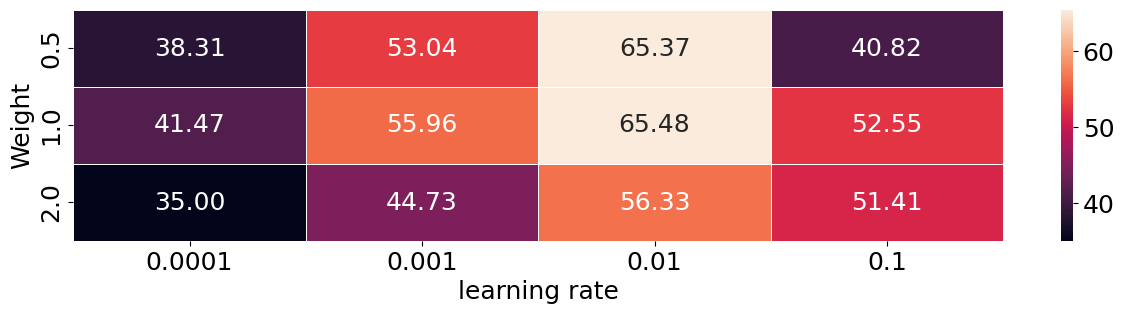

In [13]:
params = []
common_args = {}
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'multi_concept_weight': [0.5, 1, 2],
    'return_task_id': [True],        # [True, False],
    'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
}
common_args.update({
    'tag': 'concept',
    'strategy': 'concept',
    'use_wandb': True,
    'use_interactive_logger': True,
    'skip_fewshot_testing': False,
})
exp_name_template = 'concept-' + common_args['strategy'] + \
                    '-tsk_{return_task_id}' + \
                    '-lr{learning_rate}-w{multi_concept_weight}'
params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
params.extend(params_temp)

all_accs = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode=params[i]['mode'])) for i in range(len(params))])*100
all_accs[np.isnan(all_accs)] = 0

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = param['learning_rate']
    param['Weight'] = param['multi_concept_weight']
    param['Method'] = 'concept'
    param['Method'] += '*' if param['return_task_id'] is True else ''
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(15, 3))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="Weight", y="learning rate", data=collected_data, hue='Method')
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
ax = sns.heatmap(collected_data.pivot("Weight", "learning rate", "Accuracy"), annot=True, fmt=".2f", linewidth=.5)
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# visualize image with similarity mask

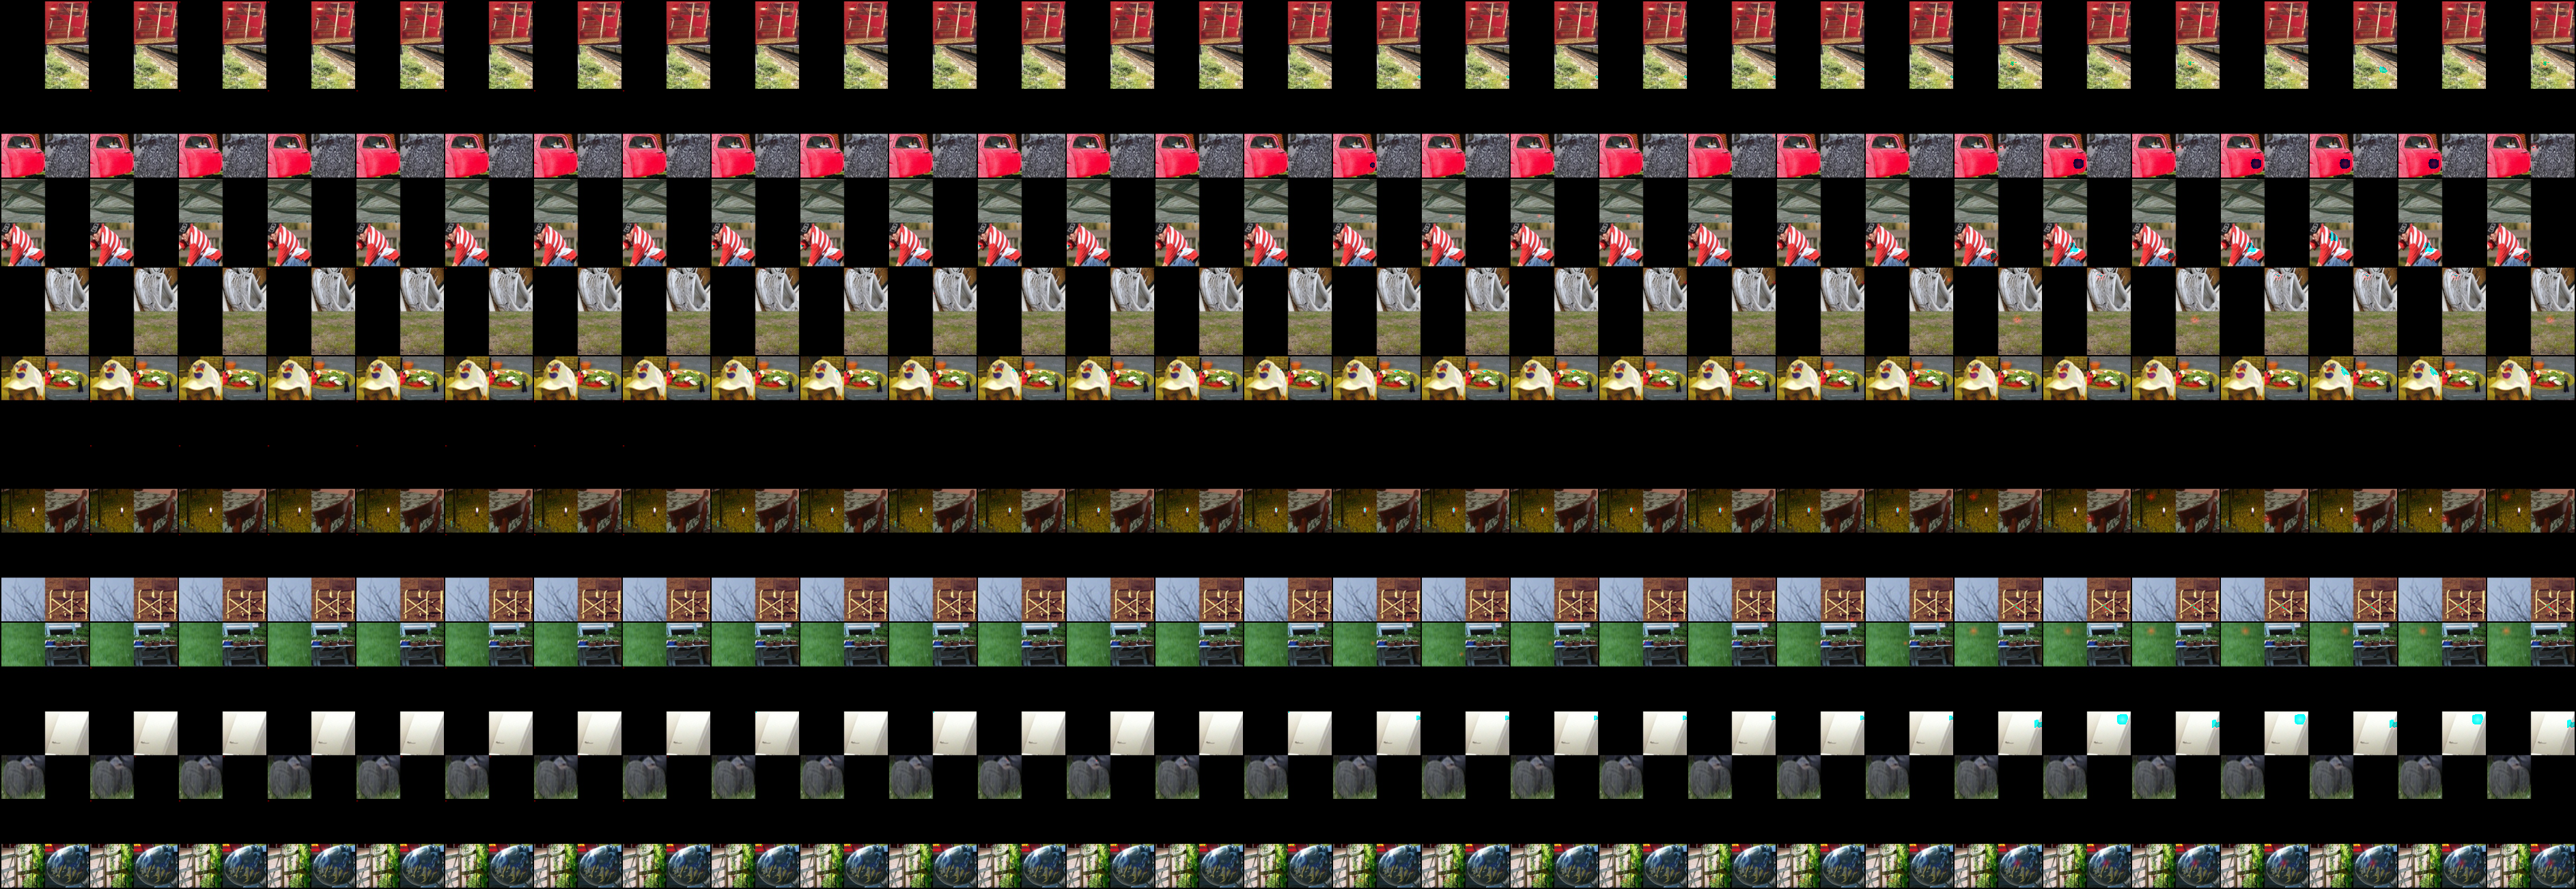

In [7]:
exp_name = 'MNt1_lr_ssc_scc2-our-tsk-lr0_001-ssc1-scc1'
# exp_name = 'MNt1_lr_reg2-our-tsk-lr0_005-reg1'
results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{exp_name}.npy'), allow_pickle=True)
last_result = results[-1]

image = last_result['Images_with_Similarity/eval_phase/test_stream/Task000/Exp000'].image

from torchvision.transforms import ToPILImage
show = ToPILImage()

from PIL import Image
# show(image).show()
show(image)

In [5]:

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

exp_name = 'MNt1_lr_ssc_scc2-our-tsk-lr0_01-ssc1-scc1'
checkpoint = torch.load(os.path.join('../../avalanche-experiments', project_name, exp_name, 'Checkpoints', '1', 'checkpoint.pth'))


pathlib.PosixPath = temp

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# visualize selection matrix

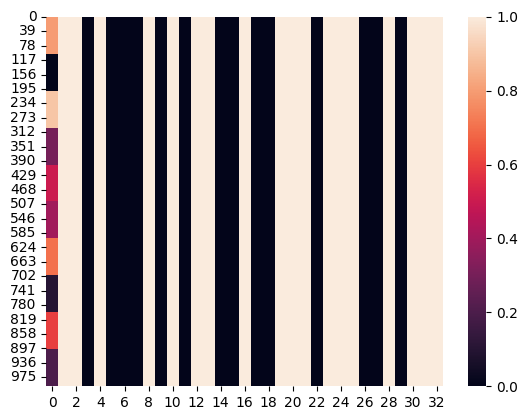

In [18]:
# exp_name = 'MNt1_lr_reg2-our-tsk-lr0_005-reg10'   # 0_01, 0_1, 1, 10
# exp_name = 'MNt1_lr_reg2-our-tsk-lr0_0002-reg10'
exp_name = 'MNt1_vit-our--tsk_True-lr0_0001-ssc10-scc10'
# exp_name = 'MNt1_vit2-our-tsk_True-r10'
task_id = 0
results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{exp_name}-{task_id}.npy'), allow_pickle=True)        # -image-with-similarity-mask
last_result = results[-1]

matrix = last_result['SelectModule/eval_phase/test_stream/Task000/Exp000/Matrix']
labels = last_result['SelectModule/eval_phase/test_stream/Task000/Exp000/Labels']/10

ax = sns.heatmap(np.concatenate([labels[:, np.newaxis], matrix], axis=1))
fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'img.png'), dpi = 400, bbox_inches='tight')

# hyperparameter tuning – vit cgqa cls-il/tsk-il baselines

ht-vit-ewc-tsk-lr{learning_rate} {'learning_rate': [1e-05, 5e-05, 0.0001, 0.001]}
all_accs: [33.4  36.39 44.1  13.34]
best: idx: 2, {'learning_rate': 0.0001, 'return_task_id': True, 'strategy': 'ewc', 'exp_name': 'ht-vit-ewc-tsk-lr0_0001', 'Accuracy': 44.1, 'learning rate': '0.0001'}.


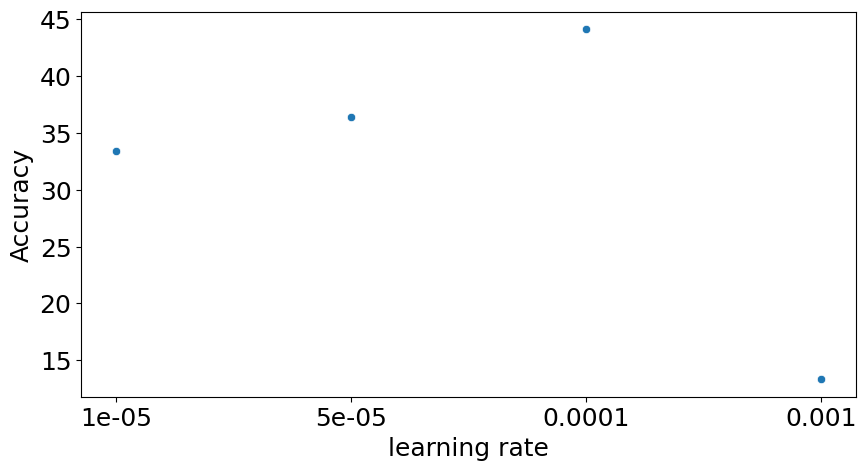

In [16]:

return_task_id = True
strategy = 'ewc'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}
exp_name_template = 'ht-vit-' + strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}'
param_grid = {
    'learning_rate': [1e-5, 5e-5, 1e-4, 1e-3],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
# ax = sns.scatterplot(x="patterns per exp.", y="Accuracy", data=collected_data)
# ax = sns.scatterplot(x="mem. strength", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'img.png'), dpi = 400, bbox_inches='tight')

# Different training size

In [11]:

params = []

common_args = {}
param_grid = {
    'strategy': ['naive', 'er', 'gem', 'lwf', 'ewc'],
    'return_task_id': [False, True],
    'num_samples_each_label': [10, 50, 100, 200, 300, 500, 800, 1000],
}
exp_name_template = 'train_size-{strategy}-' + \
                    'setting' + \
                    '-ts{num_samples_each_label}'
params.extend(generate_params(common_args, param_grid, exp_name_template))

mode = 'sys'
all_accs = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode=mode)) for i in range(len(params))])*100
print('all_accs:', all_accs)
if np.sum(np.isnan(all_accs)) > 0:
    all_accs[np.isnan(all_accs)] = (all_accs[np.where(np.isnan(all_accs))[0]-1] + all_accs[(np.where(np.isnan(all_accs))[0]+1)]) / 2    # 1 nan in LwF
    # all_accs[np.isnan(all_accs)] = all_accs[np.where(np.isnan(all_accs))[0]-1]
    # all_accs[np.isnan(all_accs)] = 0
# non
all_accs_non = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode='non')) for i in range(len(params))])*100

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['Score'] = (all_accs[i] - all_accs_non[i]) / all_accs_non[i]
    param['Train size'] = param['num_samples_each_label']
    param['Method'] = {'naive': 'Finetune', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] is True else ''

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)


train_size-{strategy}-setting-ts{num_samples_each_label} {'strategy': ['naive', 'er', 'gem', 'lwf', 'ewc'], 'return_task_id': [False, True], 'num_samples_each_label': [10, 50, 100, 200, 300, 500, 800, 1000]}
all_accs: [11.69333333 16.59666667 19.07666667 31.55333333 42.64666667 50.38
 56.99       59.83666667 10.35666667 15.99333333 26.52       37.51
 47.89666667 54.40333333 58.76       64.42333333 10.60666667 27.41333333
 32.08666667 38.90333333 54.25333333 58.59666667 66.28       69.23333333
 15.70333333 29.44333333 38.76333333 47.39333333 54.32666667 59.77666667
 65.88       67.22333333 12.50666667 10.73333333 12.41333333 22.37
 37.98666667 47.39       54.67666667 53.71666667 18.36       26.24333333
 34.94       44.08333333 47.83666667 53.92666667 61.68333333 59.21333333
 10.19               nan 24.43666667 39.29       49.85666667 57.77666667
 61.08666667 66.36666667 10.35666667 18.20333333 24.58666667 40.91333333
 47.31       52.67       60.1        62.08       10.90666667 17.273333

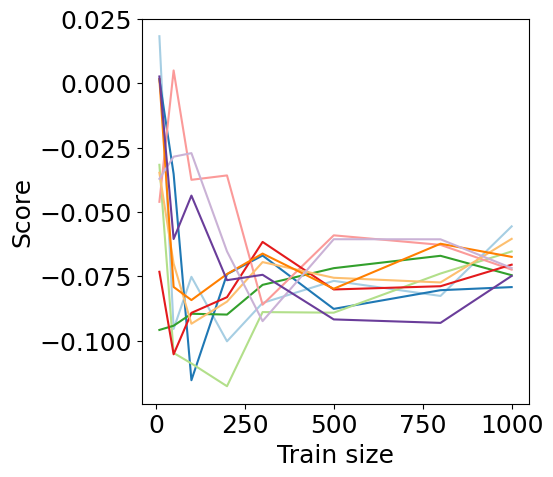

In [21]:

for i, param in enumerate(params):      # for display
    # param['sys'] = param['Accuracy']
    # param['S(sys)'] = param['Score']
    param['non'] = all_accs_non[i]

collected_data = []
collected_data.append(pd.DataFrame(params))
collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(5, 5))
sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.lineplot(x="Train size", y="Score", data=collected_data, hue='Method')  # Accuracy, Score,
ax.legend_.remove()
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

# Effect of training order for concepts (concepts in or not in the last task)

None {'strategy': ['MT', 'naive', 'er', 'gem', 'lwf', 'ewc'], 'return_task_id': [False, True], 'mode': ['sysf', 'syso']}
all_accs: [97.86666667 95.66666667 97.63333333 94.56666667 87.63333333 67.65
 86.38333333 73.3        87.51666667 75.6        86.7        74.76666667
 84.15       67.7        87.65       70.75       86.21666667 74.45
 85.85       73.63333333 85.96666667 66.4        86.88333333 72.8       ]


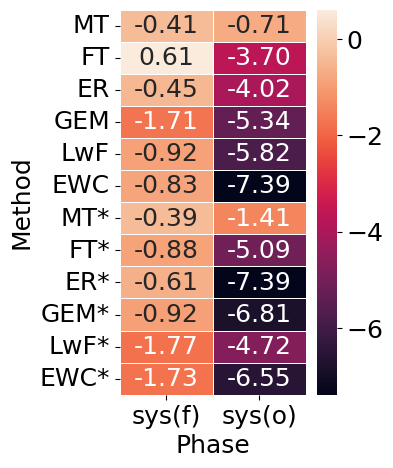

In [24]:
params = []

index = ['MT', 'FT', 'ER', 'GEM', 'LwF', 'EWC', 'MT*', 'FT*', 'ER*', 'GEM*', 'LwF*', 'EWC*']

common_args = {}
param_grid = {
    'strategy': ['MT', 'naive', 'er', 'gem', 'lwf', 'ewc'],
    'return_task_id': [False, True],
    'mode': ['sysf', 'syso'],   # ['nonf', 'nono', 'sysf', 'syso'],
}
params.extend(generate_params(common_args, param_grid))
for param in params:
    param['exp_name'] = {
        False: {
            'MT': 'MT-naive-tsk_False-lr0_005',
            'naive': 'naive-cls-lr0_003',
            'er': 'er-cls-lr0_003',
            'gem': 'gem-cls-lr0_01-p32-m0_3',
            'lwf': 'lwf-cls-lr0_005-a1-t1',
            'ewc': 'ewc-cls-lr0_005-lambda0_1'
        },
        True: {
            'MT': 'MT-naive-tsk_True-lr0_001',
            'naive': 'naive-tsk-lr0_008',
            'er': 'er-tsk-lr0_0008',
            'gem': 'gem-tsk-lr0_001-p32-m0_3',
            'lwf': 'lwf-tsk-lr0_01-a1-t1',
            'ewc': 'ewc-tsk-lr0_005-lambda2'
        }
    }[param['return_task_id']][param['strategy']]

all_accs = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode=params[i]['mode'])) for i in range(len(params))])*100
all_accs[np.isnan(all_accs)] = 0

# non
all_accs_nonf = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode='nonf')) for i in range(len(params))])*100
all_accs_nono = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], mode='nono')) for i in range(len(params))])*100

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    if param['mode'][-1] == 'f':
        param['Score'] = (all_accs[i] - all_accs_nonf[i]) / all_accs_nonf[i] * 100
    elif param['mode'][-1] == 'o':
        param['Score'] = (all_accs[i] - all_accs_nono[i]) / all_accs_nono[i] * 100
    param['Phase'] = param['mode'] if len(param['mode']) == 3 else f"{param['mode'][:3]}({param['mode'][-1]})"
    param['Method'] = {'MT': 'MT', 'naive': 'FT', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] is True else ''
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(3, 5))      # (7,5) for acc, (3, 5) for score
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="Phase", y="Score", data=collected_data, hue='Method')
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
ax = sns.heatmap(collected_data.pivot("Method", "Phase", "Score").reindex(index),
                 annot=True, fmt=".2f", linewidth=.5)   # "Accuracy" "Score"
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')


# hyperparameter tuning - MT

HT-MT-vit-naive-tsk_{return_task_id}-lr{learning_rate} {'learning_rate': [5e-05, 0.0001, 0.001], 'return_task_id': [False, True], 'mode': ['continual']}
HT-MT-vit-naive-tsk_False-lr5e-05: 45.92
HT-MT-vit-naive-tsk_True-lr5e-05: 73.9
HT-MT-vit-naive-tsk_False-lr0_0001: 66.0
HT-MT-vit-naive-tsk_True-lr0_0001: 79.34
HT-MT-vit-naive-tsk_False-lr0_001: 1.0
HT-MT-vit-naive-tsk_True-lr0_001: 17.39
all_accs: [45.92 73.9  66.   79.34  1.   17.39]


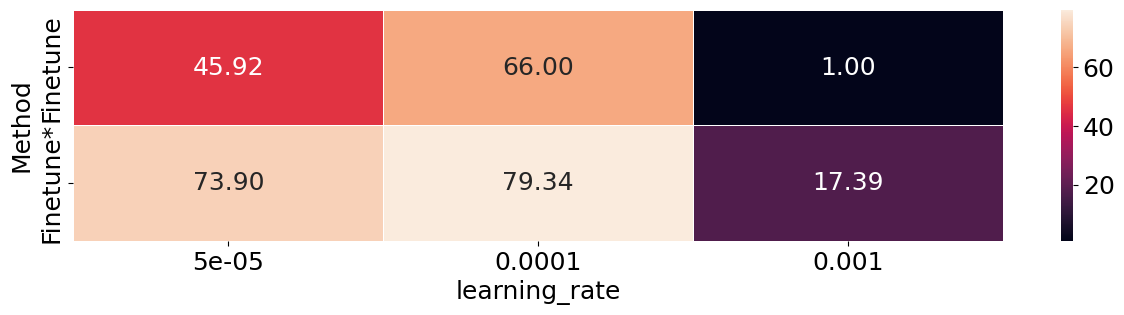

In [6]:

project_name = 'CGQA'

params = []
common_args = {}
common_args.update({
    'tag': 'HT-MT-vit',
    'strategy': 'naive',
    'use_interactive_logger': False,
    'use_text_logger': True,
    'project_name': 'CGQA',
    'dataset': 'cgqa',
    'model_backbone': 'vit',
    'epochs': 200,
    'image_size': 224,
    # 'train_mb_size': 32,
    'lr_schedule': 'cos',
})
prefix = ''       # -4
# MT
param_grid = {
    'learning_rate': [5e-5, 1e-4, 1e-3],  # np.around(np.logspace(-4, -1, num=4), decimals=5).tolist(),
    'return_task_id': [False, True],
    'mode': ['continual'],    # ['continual', 'sys', 'pro', 'sub', 'non', 'noc']
}
exp_name_template = common_args['tag'] + '-' + common_args['strategy'] + \
                    '-tsk_{return_task_id}' + \
                    '-lr{learning_rate}'
params_temp = generate_params_with_exp_name(common_args, param_grid, exp_name_template)
params.extend(params_temp)

all_accs = np.array([np.mean(get_accs_with_mode(params[i]['exp_name'], project_name=project_name, mode=params[i]['mode'], prefix=prefix if 'MT' not in params[i]['exp_name'] else '')) for i in range(len(params))])*100
all_accs[np.isnan(all_accs)] = 0

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = param['learning_rate']
    param['Method'] = {'naive': 'Finetune', 'er': 'ER', 'gem': 'GEM', 'lwf': 'LwF', 'ewc': 'EWC', 'MT': 'MultiTask'}[param['strategy']]
    param['Method'] += '*' if param['return_task_id'] is True else ''
    print(f'{param["exp_name"]}: {param["Accuracy"]}')
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
# plt.figure(figsize=(30, 2))
plt.figure(figsize=(15, 3))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="Weight", y="learning rate", data=collected_data, hue='Method')
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
ax = sns.heatmap(collected_data.pivot("Method", "learning_rate", "Accuracy"), annot=True, fmt=".2f", linewidth=.5)
# ax = px.line(collected_data, x="Train size", y="Accuracy", hover_data=['Accuracy', 'Method'], color='Method')
# ax.show()

# plt.ylim([5, 6.5])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'fig.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- naive cls-il resnet18 cgqa

all_accs: [8.13 8.15 8.3  8.38 8.3  8.31 8.06 8.14 7.91 7.74 7.59]


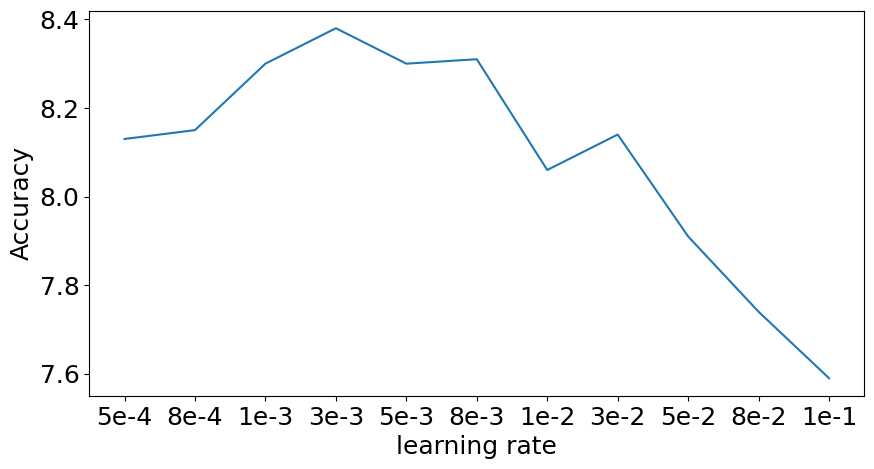

In [6]:
exp_names = ['naive-cls-lr0_0005', 'naive-cls-lr0_0008', 'naive-cls-lr0_001', 'naive-cls-lr0_003', 'naive-cls-lr0_005', 'naive-cls-lr0_008', 'naive-cls-lr0_01', 'naive-cls-lr0_03', 'naive-cls-lr0_05', 'naive-cls-lr0_08', 'naive-cls-lr0_1']
dsp_names = ['5e-4', '8e-4', '1e-3', '3e-3', '5e-3', '8e-3', '1e-2', '3e-2', '5e-2', '8e-2', '1e-1']
all_accs = np.array([np.mean(get_accs(exp_names[i])[-1]) for i in range(len(exp_names))])*100
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame({'learning rate': dsp_names, 'Accuracy': all_accs}))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.lineplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'Finetune-cls-resnet18-cgqa-hyperparameter_tuning.png'), dpi = 400, bbox_inches='tight')

In [ ]:
''''''

## hyperparameter tuning -- naive tsk-il resnet18 cgqa

get_accs: [0.218 0.178 0.273 0.383 0.386 0.394 0.415 0.467 0.753 0.836]
get_accs: [0.233 0.265 0.285 0.354 0.406 0.416 0.477 0.537 0.693 0.841]
get_accs: [0.286 0.273 0.274 0.511 0.434 0.463 0.473 0.563 0.739 0.829]
get_accs: [0.509 0.637 0.574 0.785 0.667 0.61  0.66  0.645 0.755 0.852]
get_accs: [0.579 0.586 0.55  0.707 0.686 0.662 0.669 0.613 0.805 0.839]
get_accs: [0.534 0.691 0.743 0.783 0.755 0.721 0.701 0.671 0.825 0.822]
get_accs: [0.537 0.701 0.658 0.779 0.698 0.633 0.668 0.668 0.773 0.833]
get_accs: [0.617 0.705 0.611 0.742 0.683 0.651 0.666 0.648 0.805 0.833]
get_accs: [0.102 0.459 0.578 0.7   0.659 0.645 0.588 0.574 0.718 0.763]
get_accs: [0.263 0.504 0.479 0.659 0.478 0.607 0.619 0.533 0.756 0.767]
get_accs: [0.304 0.401 0.549 0.518 0.47  0.528 0.452 0.435 0.676 0.768]
all_accs: [43.03 45.07 48.45 66.94 66.96 72.46 69.48 69.61 57.86 56.65 51.01]


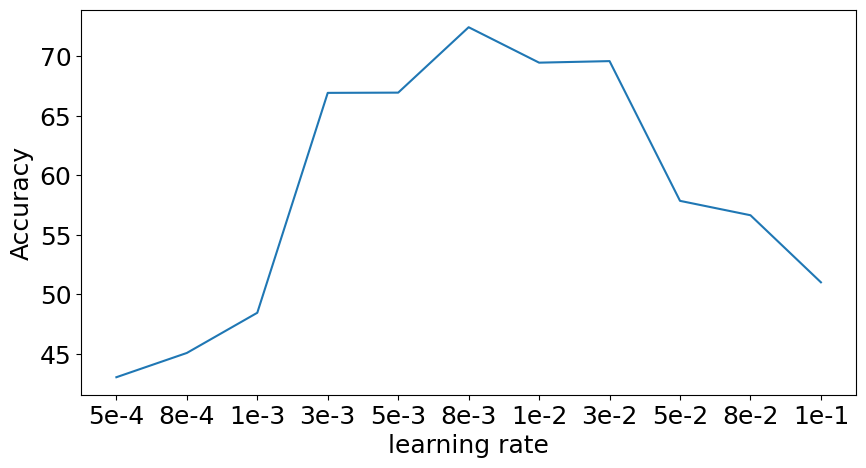

In [6]:
exp_names = ['naive-tsk-lr0_0005', 'naive-tsk-lr0_0008', 'naive-tsk-lr0_001', 'naive-tsk-lr0_003', 'naive-tsk-lr0_005', 'naive-tsk-lr0_008', 'naive-tsk-lr0_01', 'naive-tsk-lr0_03', 'naive-tsk-lr0_05', 'naive-tsk-lr0_08', 'naive-tsk-lr0_1']
dsp_names = ['5e-4', '8e-4', '1e-3', '3e-3', '5e-3', '8e-3', '1e-2', '3e-2', '5e-2', '8e-2', '1e-1']
for i in range(len(exp_names)):
    print(f'get_accs: {get_accs(exp_names[i])[-1]}')
all_accs = np.array([np.mean(get_accs(exp_names[i])[-1]) for i in range(len(exp_names))])*100
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame({'learning rate': dsp_names, 'Accuracy': all_accs}))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.lineplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'Finetune-tsk-resnet18-cgqa-hyperparameter_tuning.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- er cls-il resnet18 cgqa

all_accs: [18.3  17.53 17.53 19.78 15.82 18.8  15.75 19.1  14.1  14.71 15.72]


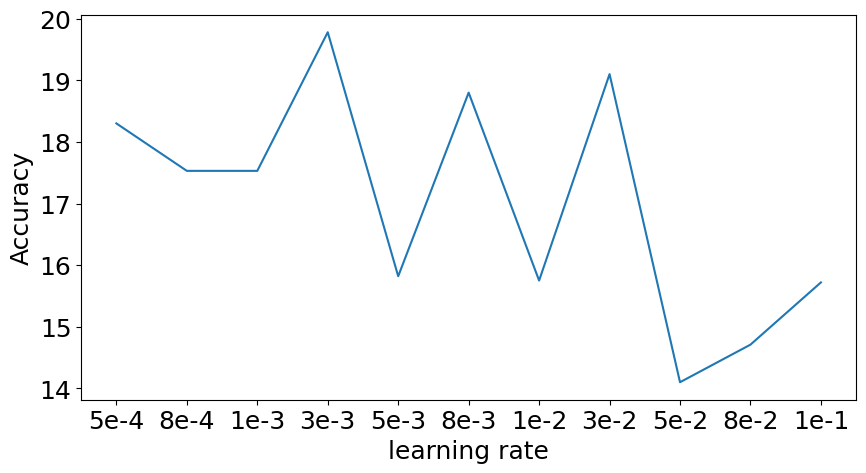

In [9]:
exp_names = ['er-cls-lr0_0005', 'er-cls-lr0_0008', 'er-cls-lr0_001', 'er-cls-lr0_003', 'er-cls-lr0_005', 'er-cls-lr0_008', 'er-cls-lr0_01', 'er-cls-lr0_03', 'er-cls-lr0_05', 'er-cls-lr0_08', 'er-cls-lr0_1']
dsp_names = ['5e-4', '8e-4', '1e-3', '3e-3', '5e-3', '8e-3', '1e-2', '3e-2', '5e-2', '8e-2', '1e-1']
all_accs = np.array([np.mean(get_accs(exp_names[i])[-1]) for i in range(len(exp_names))])*100
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame({'learning rate': dsp_names, 'Accuracy': all_accs}))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.lineplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'ER-cls-resnet18-cgqa-hyperparameter_tuning.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- er tsk-il resnet18 cgqa

all_accs: [73.26 76.05 75.77 74.71 72.56 73.87 75.63 70.54 67.6  65.68 65.63]


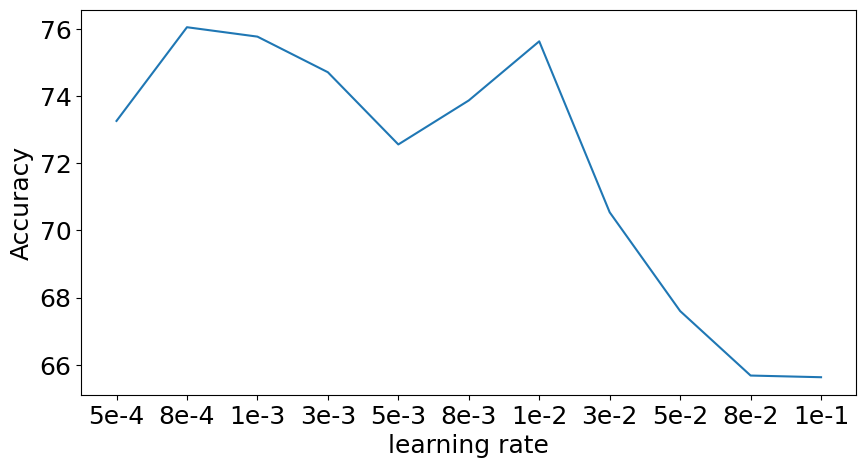

In [10]:
exp_names = ['er-tsk-lr0_0005', 'er-tsk-lr0_0008', 'er-tsk-lr0_001', 'er-tsk-lr0_003', 'er-tsk-lr0_005', 'er-tsk-lr0_008', 'er-tsk-lr0_01', 'er-tsk-lr0_03', 'er-tsk-lr0_05', 'er-tsk-lr0_08', 'er-tsk-lr0_1']
dsp_names = ['5e-4', '8e-4', '1e-3', '3e-3', '5e-3', '8e-3', '1e-2', '3e-2', '5e-2', '8e-2', '1e-1']
all_accs = np.array([np.mean(get_accs(exp_names[i])[-1]) for i in range(len(exp_names))])*100
print('all_accs:', all_accs)

collected_data = []
collected_data.append(pd.DataFrame({'learning rate': dsp_names, 'Accuracy': all_accs}))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.lineplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'ER-tsk-resnet18-cgqa-hyperparameter_tuning.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- gem cls-il resnet18 cgqa

gem-cls-lr{learning_rate}-p{gem_patterns_per_exp}-m{gem_mem_strength} {'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'gem_patterns_per_exp': [32, 64, 128, 256], 'gem_mem_strength': [0.1, 0.2, 0.3, 0.4, 0.5]}
all_accs: [7.09 6.5  2.26 5.48 8.37 8.27 8.34 8.4  8.08 8.1  8.22 8.15 7.83 7.51
 7.6  7.68 7.   6.36 6.94 4.54 8.27 8.42 8.21 7.35 8.48 8.34 8.13 8.55
 7.11 8.04 7.38 7.46 5.55 2.5  6.4  3.59 8.36 8.12 8.15 8.27 8.56 7.98
 8.12 8.3  7.73 7.82 7.63 7.7  6.81 3.83 2.51 3.85 8.4  8.2  7.72 8.37
 8.31 8.12 8.49 8.12 7.74 7.84 7.63 7.64 6.23 5.84 3.99 2.72 8.54 8.52
 7.92 8.02 7.97 8.16 8.49 7.88 7.72 7.61 7.3  7.55]
best: idx: 40, {'gem_mem_strength': 0.3, 'learning_rate': 0.01, 'gem_patterns_per_exp': 32, 'return_task_id': False, 'strategy': 'gem', 'exp_name': 'gem-cls-lr0_01-p32-m0_3', 'Accuracy': 8.559999999999999, 'learning rate': '0.01', 'patterns per exp.': '32', 'mem. strength': '0.3'}.


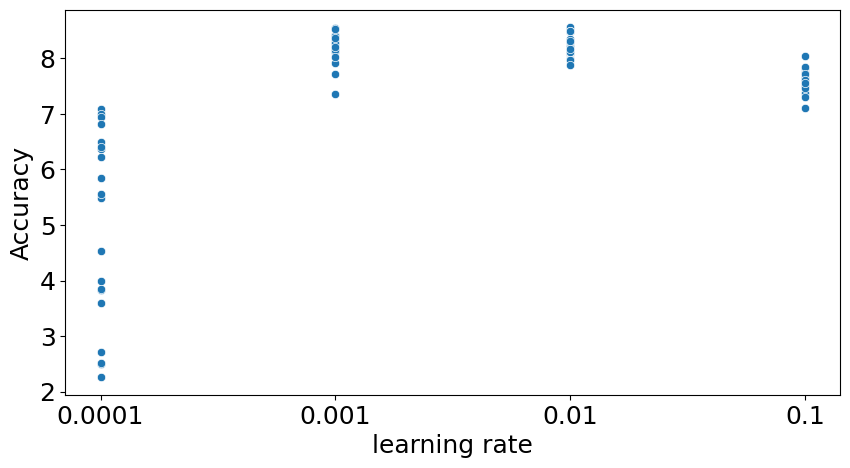

In [29]:

return_task_id = False
strategy = 'gem'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}
exp_name_template = strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}-p{gem_patterns_per_exp}-m{gem_mem_strength}'
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],        # [0.0001, 0.001, 0.01, 0.1]
    'gem_patterns_per_exp': [32, 64, 128, 256],
    'gem_mem_strength': [0.1, 0.2, 0.3, 0.4, 0.5],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
    param['patterns per exp.'] = str(param['gem_patterns_per_exp'])
    param['mem. strength'] = str(param['gem_mem_strength'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
# ax = sns.scatterplot(x="patterns per exp.", y="Accuracy", data=collected_data)
# ax = sns.scatterplot(x="mem. strength", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'GEM-cls-resnet18-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')
# fig.savefig(os.path.join('D:', 'Downloads', 'GEM-cls-resnet18-cgqa-hyperparameter_tuning-p.png'), dpi = 400, bbox_inches='tight')
# fig.savefig(os.path.join('D:', 'Downloads', 'GEM-cls-resnet18-cgqa-hyperparameter_tuning-m.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- gem tsk-il resnet18 cgqa

gem-tsk-lr{learning_rate}-p{gem_patterns_per_exp}-m{gem_mem_strength} {'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'gem_patterns_per_exp': [32, 64, 128, 256], 'gem_mem_strength': [0.1, 0.2, 0.3, 0.4, 0.5]}
all_accs: [16.61 16.55 16.57 18.02 16.98 16.87 16.57 16.49 16.99 16.81 16.76 16.46
 16.59 16.57 16.73 16.59 16.55 16.79 16.45 16.77 18.42 19.54 21.6  19.38
 18.25 18.69 19.26 19.79 18.31 20.75 19.1  19.11 19.05 18.67 21.27 18.19
 17.76 19.08 18.44 20.16 20.81 19.7  18.8  19.54 17.61 19.84 18.87 20.44
 18.98 19.58 19.82 20.16 19.5  19.23 20.48 17.99 20.03 19.8  18.48 18.77
 19.62 18.71 19.56 20.05 18.02 17.13 18.09 18.26 18.24 17.52 18.15 17.5
 16.76 16.92 18.57 16.51 18.61 17.84 16.8  18.08]
best: idx: 22, {'learning_rate': 0.001, 'gem_patterns_per_exp': 32, 'gem_mem_strength': 0.3, 'return_task_id': True, 'strategy': 'gem', 'exp_name': 'gem-tsk-lr0_001-p32-m0_3', 'Accuracy': 21.6, 'learning rate': '0.001', 'patterns per exp.': '32', 'mem. strength': '0.3'}.


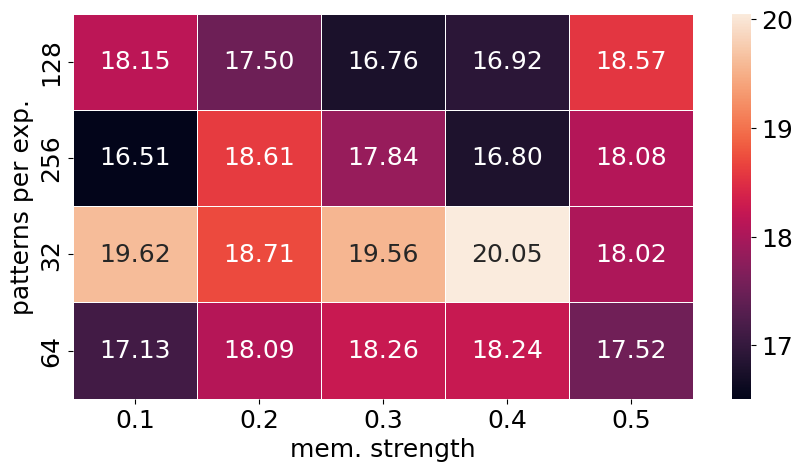

In [10]:

return_task_id = True
strategy = 'gem'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}
exp_name_template = strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}-p{gem_patterns_per_exp}-m{gem_mem_strength}'
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],        # [0.0001, 0.001, 0.01, 0.1]
    'gem_patterns_per_exp': [32, 64, 128, 256],
    'gem_mem_strength': [0.1, 0.2, 0.3, 0.4, 0.5],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
    param['patterns per exp.'] = str(param['gem_patterns_per_exp'])
    param['mem. strength'] = str(param['gem_mem_strength'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
collected_data = collected_data[collected_data['learning rate'] == '0.1']
ax = sns.heatmap(collected_data.pivot("patterns per exp.", "mem. strength", "Accuracy"), annot=True, fmt=".2f", linewidth=.5)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'GEM-tsk-resnet18-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- lwf cls-il resnet18 cgqa

lwf-cls-lr{learning_rate}-a{lwf_alpha}-t{lwf_temperature} {'learning_rate': [0.001, 0.005, 0.01, 0.05], 'lwf_alpha': [0.1, 0.5, 1, 5, 10], 'lwf_temperature': [0.1, 0.5, 1, 2]}
all_accs: [8.45 8.53 8.29 8.1  8.6  8.31 8.32 7.75 8.44 8.12 8.03 7.75 8.43 8.6
 8.33 7.75 8.4  7.95 7.93 7.46 8.42 8.63 8.53 8.02 8.59 8.48 8.51 7.99
 8.77 8.8  8.29 8.04 8.26 7.92 7.85 5.98 8.53 8.36 8.24 7.86 8.82 9.11
 8.58 7.85 8.81 8.72 8.48 8.   7.36 7.07 6.95 2.78 8.36 8.2  7.91 6.56
 9.03 8.5  8.03 7.53 8.61 9.08 8.81 7.82 6.66 6.25 5.49 2.59 7.73 7.64
 7.34 5.88 8.82 7.9  8.13 6.89 8.23 8.11 8.42 7.43]
best: idx: 41, {'lwf_alpha': 1, 'lwf_temperature': 1, 'learning_rate': 0.005, 'return_task_id': False, 'strategy': 'lwf', 'exp_name': 'lwf-cls-lr0_005-a1-t1', 'Accuracy': 9.11, 'learning rate': '0.005', 'alpha': '1', 'temperature': '1'}.


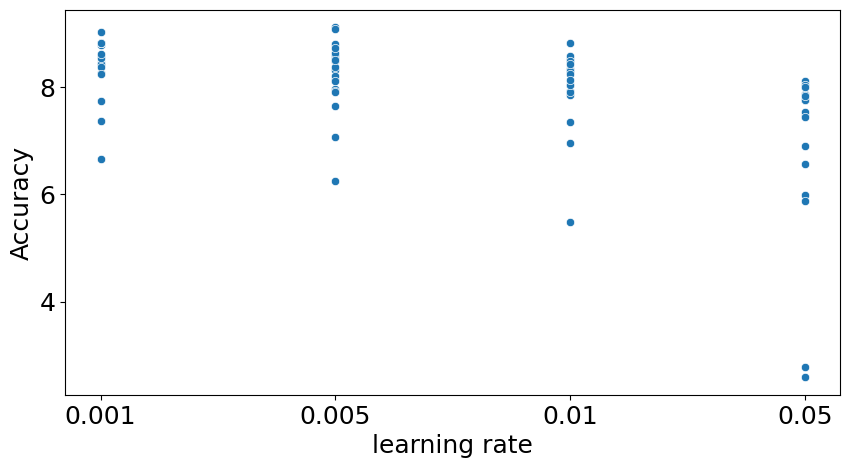

In [30]:

return_task_id = False
strategy = 'lwf'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}

exp_name_template = strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}-a{lwf_alpha}-t{lwf_temperature}'
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'lwf_alpha': [0.1, 0.5, 1, 5, 10],
    'lwf_temperature': [0.1, 0.5, 1, 2],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
    param['alpha'] = str(param['lwf_alpha'])
    param['temperature'] = str(param['lwf_temperature'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'LwF-cls-resnet18-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- lwf tsk-il resnet18 cgqa

lwf-tsk-lr{learning_rate}-a{lwf_alpha}-t{lwf_temperature} {'learning_rate': [0.001, 0.005, 0.01, 0.05], 'lwf_alpha': [0.1, 0.5, 1, 5, 10], 'lwf_temperature': [0.1, 0.5, 1, 2]}
all_accs: [56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64
 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64
 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64
 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64
 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64
 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64
 56.49 72.47 73.19 57.64 56.49 72.47 73.19 57.64]
best: idx: 2, {'lwf_alpha': 0.1, 'lwf_temperature': 0.1, 'learning_rate': 0.01, 'return_task_id': True, 'strategy': 'lwf', 'exp_name': 'lwf-tsk-lr0_01-a0_1-t0_1', 'Accuracy': 73.19000000000001, 'learning rate': '0.01', 'alpha': '0.1', 'temperature': '0.1'}.


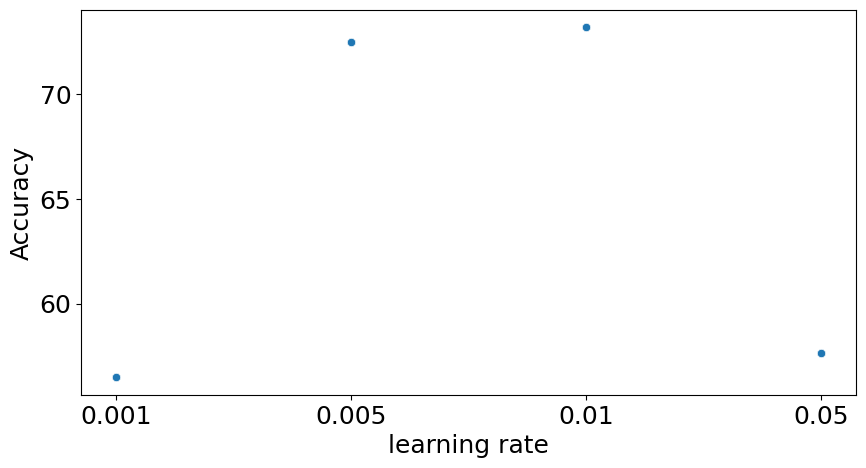

In [31]:

return_task_id = True
strategy = 'lwf'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}

exp_name_template = strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}-a{lwf_alpha}-t{lwf_temperature}'
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'lwf_alpha': [0.1, 0.5, 1, 5, 10],
    'lwf_temperature': [0.1, 0.5, 1, 2],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
    param['alpha'] = str(param['lwf_alpha'])
    param['temperature'] = str(param['lwf_temperature'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'LwF-tsk-resnet18-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- ewc cls-il resnet18 cgqa

ewc-cls-lr{learning_rate}-lambda{ewc_lambda} {'learning_rate': [0.001, 0.005, 0.01, 0.05], 'ewc_lambda': [0.1, 0.5, 1, 1.5, 2]}
all_accs: [8.12 8.22 8.13 7.74 8.06 8.16 8.01 7.71 7.64 6.84 8.06 7.53 7.03 8.07
 8.03 7.42 7.76 8.22 7.88 7.2 ]
best: idx: 1, {'ewc_lambda': 0.1, 'learning_rate': 0.005, 'return_task_id': False, 'strategy': 'ewc', 'exp_name': 'ewc-cls-lr0_005-lambda0_1', 'Accuracy': 8.219999999999999, 'learning rate': '0.005', 'lambda': '0.1'}.


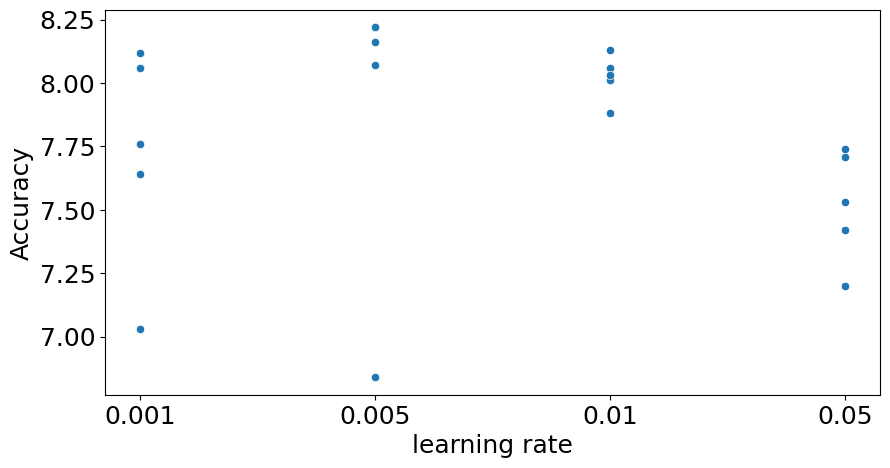

In [32]:

return_task_id = False
strategy = 'ewc'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}

exp_name_template = strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}-lambda{ewc_lambda}'
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'ewc_lambda': [0.1, 0.5, 1, 1.5, 2],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display`
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
    param['lambda'] = str(param['ewc_lambda'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'EWC-cls-resnet18-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- ewc tsk-il resnet18 cgqa

ewc-tsk-lr{learning_rate}-lambda{ewc_lambda} {'learning_rate': [0.001, 0.005, 0.01, 0.05], 'ewc_lambda': [0.1, 0.5, 1, 1.5, 2]}
all_accs: [47.78 68.68 68.6  55.08 48.35 67.94 67.97 59.14 46.29 70.5  68.05 52.35
 44.63 69.4  66.44 56.46 48.91 71.1  69.63 57.07]
best: idx: 17, {'ewc_lambda': 2, 'learning_rate': 0.005, 'return_task_id': True, 'strategy': 'ewc', 'exp_name': 'ewc-tsk-lr0_005-lambda2', 'Accuracy': 71.10000000000001, 'learning rate': '0.005', 'lambda': '2'}.


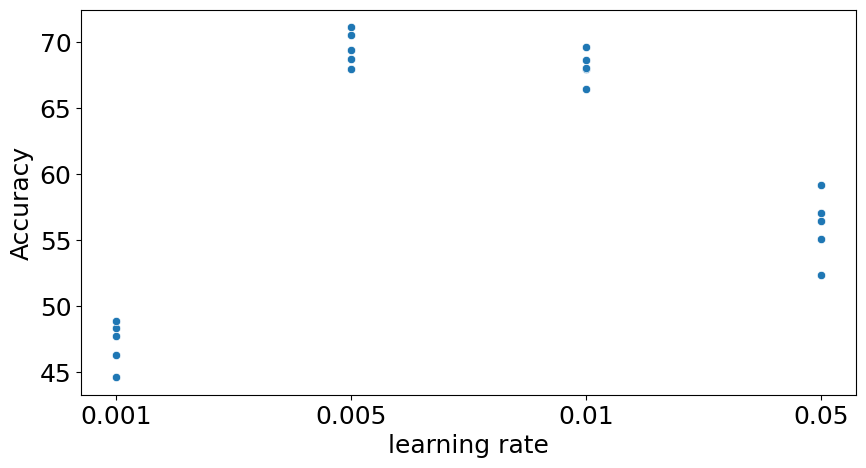

In [33]:

return_task_id = True
strategy = 'ewc'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
}

exp_name_template = strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-lr{learning_rate}-lambda{ewc_lambda}'
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'ewc_lambda': [0.1, 0.5, 1, 1.5, 2],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['learning rate'] = str(param['learning_rate'])
    param['lambda'] = str(param['ewc_lambda'])
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x="learning rate", y="Accuracy", data=collected_data)
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([7, 9])

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'EWC-tsk-resnet18-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')

## hyperparameter tuning -- vit structure naive cls-il cgqa

In [6]:

return_task_id = False
strategy = 'naive'   # optional: [naive, er, gem, lwf, ewc]
common_args = {
    'return_task_id': return_task_id,
    'strategy': strategy,
    'model_backbone': 'vit',
    'lr_schedule': 'cos',
}

exp_name_template = '{model_backbone}-' + strategy + '-' + \
                    ('tsk' if return_task_id else 'cls') + \
                    '-{lr_schedule}lr{learning_rate}' + \
                    '-ps{vit_patch_size}' + \
                    '-dim{vit_dim}' + \
                    '-depth{vit_depth}' + \
                    '-heads{vit_heads}'
param_grid = {
    'learning_rate': [1e-5, 1e-4, 1e-3],
    'vit_patch_size': [16],
    'vit_dim': [192, 384],  # 768 is ViT-B/16
    'vit_depth': [6, 9],
    'vit_heads': [16],
}
params = generate_params(common_args, param_grid, exp_name_template)

all_accs = np.array([np.mean(get_accs(params[i]['exp_name'])[-1]) for i in range(len(params))])*100
all_accs[np.isnan(all_accs)] = 0

for i, param in enumerate(params):      # for display
    param['Accuracy'] = all_accs[i]
    param['Learning rate'] = str(param['learning_rate'])
    param['Dim'] = int(param['vit_dim'])
    param['Depth'] = int(param['vit_depth'])
    param['Heads'] = int(param['vit_heads'])
    # param['MLP_dim'] = int(param['vit_mlp_dim'])
    param['Dim, depth'] = str((param['vit_dim'], param['vit_depth']))
print('all_accs:', all_accs)

print(f'best: idx: {np.argmax(all_accs)}, {params[np.argmax(all_accs)]}.')

collected_data = []
collected_data.append(pd.DataFrame(params))

collected_data = pd.concat(collected_data, ignore_index=True)

# fig = px.line(collected_data, x="learning rate", y="Value", title='Acc')
# fig.show()
plt.figure(figsize=(10, 5))
# sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

# ax = sns.scatterplot(x="MLP_dim", y="Accuracy", data=collected_data)
ax = px.scatter(collected_data, x="Learning rate", y="Dim, depth", hover_data=['Accuracy', 'Learning rate', "Dim", 'Depth', 'Heads'], color='Accuracy')
ax.show()
# plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

# plt.ylim([5, 6.5])

# fig = ax.get_figure()
# fig.savefig(os.path.join('D:', 'Downloads', 'vit-struct-naive-cls-vit-cgqa-hyperparameter_tuning-lr.png'), dpi = 400, bbox_inches='tight')

{model_backbone}-naive-cls-{lr_schedule}lr{learning_rate}-ps{vit_patch_size}-dim{vit_dim}-depth{vit_depth}-heads{vit_heads} {'learning_rate': [1e-05, 0.0001, 0.001], 'vit_patch_size': [16], 'vit_dim': [192, 384], 'vit_depth': [6, 9], 'vit_heads': [16]}
all_accs: [5.92 6.03 6.13 6.12 6.83 6.76 6.83 6.93 1.95 1.91 1.6  1.41]
best: idx: 7, {'learning_rate': 0.0001, 'vit_patch_size': 16, 'vit_heads': 16, 'vit_dim': 384, 'vit_depth': 9, 'return_task_id': False, 'strategy': 'naive', 'model_backbone': 'vit', 'lr_schedule': 'cos', 'exp_name': 'vit-naive-cls-coslr0_0001-ps16-dim384-depth9-heads16', 'Accuracy': 6.93, 'Learning rate': '0.0001', 'Dim': 384, 'Depth': 9, 'Heads': 16, 'Dim, depth': '(384, 9)'}.


<Figure size 1000x500 with 0 Axes>

In [11]:
collected_data[collected_data['Accuracy'] == 0]

vit_patch_size  learning_rate  vit_dim  vit_heads  vit_mlp_dim  vit_depth  \
8                8        0.00001      512          8         2048          9   
16               8        0.00001      512         16         2048          7   
17               8        0.00001      512         16         2048          9   
20               8        0.00001      512         32          512          9   
23               8        0.00001      512         32         1024          9   
25               8        0.00001      512         32         2048          7   
26               8        0.00001      512         32         2048          9   
34               8        0.00001     1024          8         2048          7   
41               8        0.00001     1024         16         1024          9   
43               8        0.00001     1024         16         2048          7   
46               8        0.00001     1024         32          512          7   
47               8        0.00001     1024         32          512          9   
49               8        0.00001     1024         32         1024          7   
50               8        0.00001     1024         32         1024          9   
52               8        0.00001     1024         32         2048          7   
53               8        0.00001     1024         32         2048          9   
61               8        0.00001     2048          8         2048          7   
71               8        0.00001     2048         16         2048          9   
73               8        0.00001     2048         32          512          7   
74               8        0.00001     2048         32          512          9   
76               8        0.00001     2048         32         1024          7   
77               8        0.00001     2048         32         1024          9   
79               8        0.00001     2048         32         2048          7   
80               8        0.00001     2048         32         2048          9   

    return_task_id strategy model_backbone  \
8            False    naive            vit   
16           False    naive            vit   
17           False    naive            vit   
20           False    naive            vit   
23           False    naive            vit   
25           False    naive            vit   
26           False    naive            vit   
34           False    naive            vit   
41           False    naive            vit   
43           False    naive            vit   
46           False    naive            vit   
47           False    naive            vit   
49           False    naive            vit   
50           False    naive            vit   
52           False    naive            vit   
53           False    naive            vit   
61           False    naive            vit   
71           False    naive            vit   
73           False    naive            vit   
74           False    naive            vit   
76           False    naive            vit   
77           False    naive            vit   
79           False    naive            vit   
80           False    naive            vit   

                                             exp_name  Accuracy learning rate  
8   vit-naive-cls-lr1e-05-ps8-dim512-depth9-heads8...       0.0         1e-05  
16  vit-naive-cls-lr1e-05-ps8-dim512-depth7-heads1...       0.0         1e-05  
17  vit-naive-cls-lr1e-05-ps8-dim512-depth9-heads1...       0.0         1e-05  
20  vit-naive-cls-lr1e-05-ps8-dim512-depth9-heads3...       0.0         1e-05  
23  vit-naive-cls-lr1e-05-ps8-dim512-depth9-heads3...       0.0         1e-05  
25  vit-naive-cls-lr1e-05-ps8-dim512-depth7-heads3...       0.0         1e-05  
26  vit-naive-cls-lr1e-05-ps8-dim512-depth9-heads3...       0.0         1e-05  
34  vit-naive-cls-lr1e-05-ps8-dim1024-depth7-heads...       0.0         1e-05  
41  vit-naive-cls-lr1e-05-ps8-dim1024-depth9-heads...       0.0         1e-05  
43  vit-naive-cls-lr1e-05-p

## cls-il num cls vs acc

In [14]:
collected_data = []
for idx in range(len(exp_names)):
    collected_data.append(pd.DataFrame({'Num classes': np.arange(2, 21, 2), 'Algo.': dsp_names[idx], 'Type': 'Acc', 'Value': all_accs[idx]}))

'''add RPSnet'''
collected_data.append(pd.DataFrame({
    'Num classes': np.arange(2, 21, 2), 'Algo.': 'RPSnet', 'Type': 'Acc',
    'Value': np.array([74.5, 68.75, 58.166667, 50.875, 47.4, 43.5, 35.785714, 34.4375, 22.277778, 20.15])/100
}))

collected_data = pd.concat(collected_data, ignore_index=True)

fig = px.line(collected_data, x="Num classes", y="Value", color="Algo.", title='Acc')
fig.show()
# write_image(fig, experiment_name, "train.png")

# Show Novel and Non-novel Testing Results

In [40]:

# exp_name = 'Naive-lr0_005'       # nc-
# exp_name = 'ER-lr0_01-m1000'
# exp_name = 'LwF-lr0_005-a11-t2'
exp_name = 'GEM-lr0_01-p32-m0_5'        # GEM-lr0_01-p32-m0_5 color-GEM-lr0_01-p32-m0_3

# test_case_name = 'Novel-{}'.format(exp_name)
# test_case_name = 'Non-novel-{}'.format(exp_name)
# test_case_name = 'Novel-{}-frz'.format(exp_name)
test_case_name = 'Non-novel-{}-frz'.format(exp_name)
# test_case_name = 'Novel-{}-lm'.format(exp_name)
# test_case_name = 'Novel-{}-frz-lm'.format(exp_name)

In [41]:
results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{test_case_name}.npy'), allow_pickle=True)

In [42]:
'''Test acc'''
accs = [result['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for result in results]
print(accs)

[0.45, 0.53, 0.4, 0.41, 0.49, 0.61, 0.39, 0.51, 0.57, 0.44, 0.48, 0.57, 0.66, 0.53, 0.55, 0.53, 0.6, 0.5, 0.6, 0.37, 0.54, 0.55, 0.4, 0.48, 0.51, 0.48, 0.56, 0.42, 0.47, 0.44, 0.42, 0.6, 0.52, 0.34, 0.63, 0.51, 0.35, 0.62, 0.5, 0.58, 0.53, 0.61, 0.52, 0.46, 0.47, 0.48, 0.56, 0.52, 0.36, 0.58, 0.4, 0.46, 0.41, 0.55, 0.42, 0.46, 0.56, 0.44, 0.53, 0.5, 0.59, 0.41, 0.49, 0.52, 0.39, 0.48, 0.46, 0.43, 0.37, 0.5, 0.4, 0.46, 0.53, 0.46, 0.41, 0.29, 0.49, 0.49, 0.45, 0.32, 0.48, 0.38, 0.48, 0.47, 0.45, 0.69, 0.44, 0.5, 0.59, 0.48, 0.48, 0.35, 0.53, 0.44, 0.53, 0.53, 0.42, 0.64, 0.52, 0.44, 0.55, 0.36, 0.64, 0.61, 0.65, 0.44, 0.47, 0.47, 0.49, 0.5, 0.43, 0.58, 0.5, 0.46, 0.54, 0.55, 0.49, 0.47, 0.64, 0.5, 0.46, 0.5, 0.49, 0.46, 0.3, 0.58, 0.55, 0.49, 0.63, 0.58, 0.43, 0.35, 0.39, 0.59, 0.45, 0.49, 0.57, 0.38, 0.55, 0.47, 0.58, 0.38, 0.52, 0.45, 0.51, 0.48, 0.37, 0.52, 0.63, 0.58, 0.51, 0.54, 0.59, 0.4, 0.45, 0.44, 0.36, 0.44, 0.41, 0.58, 0.4, 0.5, 0.53, 0.53, 0.59, 0.49, 0.39, 0.52, 0.49, 0.5, 

In [43]:
print(f'{np.mean(accs)*100:.2f}% ({np.std(accs)*100:.2f}%)')

49.83% (8.51%)


# Show Hyper-Parameter Tuning Results

In [33]:
def display_results(exp_name, test_case_name):
    print(f'{exp_name}, {test_case_name}:')
    if os.path.exists(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{test_case_name}.npy')):
        results = np.load(os.path.join('../../avalanche-experiments', project_name, exp_name, f'results-{test_case_name}.npy'), allow_pickle=True)
    else:
        print(f'results-{test_case_name}.npy does not exist.')
        return
    accs = [result['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for result in results]
    print(f'==> {accs}')
    print(f'==> {np.mean(accs)*100:.2f}% ({np.std(accs)*100:.2f}%)')

In [5]:
exp_names = [
    'Naive-lr0_001', 'Naive-lr0_005', 'Naive-lr0_01', 'Naive-lr0_05', 'Naive-lr0_1',
]
exp_names = [f'color-{exp_names[i]}' for i in range(len(exp_names))]

for exp_name in exp_names:
    display_results(exp_name, exp_name)

color-Naive-lr0_001, color-Naive-lr0_001:
==> [0.97, 0.48, 0.30333333333333334, 0.2375, 0.178, 0.16, 0.13428571428571429, 0.10625, 0.10333333333333333, 0.092]
==> 27.65% (25.71%)
color-Naive-lr0_005, color-Naive-lr0_005:
==> [0.98, 0.475, 0.3, 0.24, 0.174, 0.15, 0.14, 0.11125, 0.10666666666666667, 0.093]
==> 27.70% (25.91%)
color-Naive-lr0_01, color-Naive-lr0_01:
==> [0.96, 0.465, 0.30666666666666664, 0.2425, 0.172, 0.145, 0.13714285714285715, 0.115, 0.10333333333333333, 0.091]
==> 27.38% (25.35%)
color-Naive-lr0_05, color-Naive-lr0_05:
==> [0.95, 0.47, 0.30333333333333334, 0.245, 0.168, 0.16, 0.13857142857142857, 0.10875, 0.09888888888888889, 0.092]
==> 27.35% (25.11%)
color-Naive-lr0_1, color-Naive-lr0_1:
==> [0.98, 0.47, 0.31, 0.2375, 0.162, 0.15333333333333332, 0.14, 0.1075, 0.09888888888888889, 0.091]
==> 27.50% (26.01%)


In [37]:
exp_names = [
    'ER-lr0_001-m100', 'ER-lr0_01-m100', 'ER-lr0_1-m100',
    'ER-lr0_001-m500', 'ER-lr0_01-m500', 'ER-lr0_1-m500',
    'ER-lr0_001-m1000', 'ER-lr0_01-m1000', 'ER-lr0_1-m1000',
    'ER-lr0_001-m5000', 'ER-lr0_01-m5000', 'ER-lr0_1-m5000',
]
exp_names = [f'color-{exp_names[i]}' for i in range(len(exp_names))]

for exp_name in exp_names:
    display_results(exp_name, exp_name)

color-ER-lr0_001-m100, color-ER-lr0_001-m100:
==> [0.97, 0.695, 0.45666666666666667, 0.2925, 0.222, 0.18, 0.15428571428571428, 0.125, 0.11333333333333333, 0.094]
==> 33.03% (27.75%)
color-ER-lr0_01-m100, color-ER-lr0_01-m100:
==> [0.96, 0.71, 0.4633333333333333, 0.3025, 0.24, 0.175, 0.16857142857142857, 0.13625, 0.12333333333333334, 0.092]
==> 33.71% (27.47%)
color-ER-lr0_1-m100, color-ER-lr0_1-m100:
==> [0.98, 0.635, 0.37333333333333335, 0.285, 0.23, 0.20333333333333334, 0.16142857142857142, 0.13, 0.12222222222222222, 0.095]
==> 32.15% (26.68%)
color-ER-lr0_001-m500, color-ER-lr0_001-m500:
==> [0.97, 0.805, 0.6, 0.33, 0.362, 0.3016666666666667, 0.21285714285714286, 0.1775, 0.18777777777777777, 0.109]
==> 40.56% (27.55%)
color-ER-lr0_01-m500, color-ER-lr0_01-m500:
==> [0.96, 0.78, 0.61, 0.3775, 0.36, 0.36666666666666664, 0.23714285714285716, 0.21, 0.1988888888888889, 0.127]
==> 42.27% (26.03%)
color-ER-lr0_1-m500, color-ER-lr0_1-m500:
results-color-ER-lr0_1-m500.npy does not exist.
col

In [38]:
exp_names = [
    'LwF-lr0_001-a9-t2', 'LwF-lr0_005-a9-t2', 'LwF-lr0_01-a9-t2', 'LwF-lr0_05-a9-t2',  'LwF-lr0_1-a9-t2',
    # 'LwF-lr0_001-a10-t2', 'LwF-lr0_005-a10-t2', 'LwF-lr0_01-a10-t2', 'LwF-lr0_05-a10-t2',  'LwF-lr0_1-a10-t2',
    'LwF-lr0_001-a11-t2', 'LwF-lr0_005-a11-t2', 'LwF-lr0_01-a11-t2', 'LwF-lr0_05-a11-t2',  'LwF-lr0_1-a11-t2',
]
# exp_names = [
#     'LwF-lr0_005-a5-t1','LwF-lr0_005-a10-t1', 'LwF-lr0_005-a15-t1', 'LwF-lr0_005-a20-t1', 'LwF-lr0_005-a25-t1',
#     'LwF-lr0_005-a5-t2','LwF-lr0_005-a10-t2', 'LwF-lr0_005-a15-t2', 'LwF-lr0_005-a20-t2', 'LwF-lr0_005-a25-t2',
#     'LwF-lr0_005-a5-t3','LwF-lr0_005-a10-t3', 'LwF-lr0_005-a15-t3', 'LwF-lr0_005-a20-t3', 'LwF-lr0_005-a25-t3',
#     'LwF-lr0_005-a5-t4','LwF-lr0_005-a10-t4', 'LwF-lr0_005-a15-t4', 'LwF-lr0_005-a20-t4', 'LwF-lr0_005-a25-t4',
#     'LwF-lr0_005-a5-t5','LwF-lr0_005-a10-t5', 'LwF-lr0_005-a15-t5', 'LwF-lr0_005-a20-t5', 'LwF-lr0_005-a25-t5',
# ]
exp_names = [f'color-{exp_names[i]}' for i in range(len(exp_names))]

for exp_name in exp_names:
    display_results(exp_name, exp_name)

color-LwF-lr0_001-a9-t2, color-LwF-lr0_001-a9-t2:
==> [0.97, 0.445, 0.3, 0.24, 0.162, 0.15, 0.13857142857142857, 0.10875, 0.10555555555555556, 0.093]
==> 27.13% (25.50%)
color-LwF-lr0_005-a9-t2, color-LwF-lr0_005-a9-t2:
==> [0.98, 0.445, 0.3, 0.2375, 0.178, 0.15166666666666667, 0.14142857142857143, 0.11125, 0.10444444444444445, 0.094]
==> 27.43% (25.67%)
color-LwF-lr0_01-a9-t2, color-LwF-lr0_01-a9-t2:
results-color-LwF-lr0_01-a9-t2.npy does not exist.
color-LwF-lr0_05-a9-t2, color-LwF-lr0_05-a9-t2:
results-color-LwF-lr0_05-a9-t2.npy does not exist.
color-LwF-lr0_1-a9-t2, color-LwF-lr0_1-a9-t2:
results-color-LwF-lr0_1-a9-t2.npy does not exist.
color-LwF-lr0_001-a11-t2, color-LwF-lr0_001-a11-t2:
==> [0.97, 0.435, 0.30333333333333334, 0.2425, 0.164, 0.15833333333333333, 0.13857142857142857, 0.1075, 0.10555555555555556, 0.093]
==> 27.18% (25.39%)
color-LwF-lr0_005-a11-t2, color-LwF-lr0_005-a11-t2:
results-color-LwF-lr0_005-a11-t2.npy does not exist.
color-LwF-lr0_01-a11-t2, color-LwF-lr0_0

In [39]:
exp_names = [
    'GEM-lr0_01-p16-m0_3', 'GEM-lr0_01-p32-m0_3',
    'GEM-lr0_01-p16-m0_5', 'GEM-lr0_01-p32-m0_5',

    'GEM-lr0_1-p16-m0_3', 'GEM-lr0_1-p32-m0_3',
    'GEM-lr0_1-p16-m0_5', 'GEM-lr0_1-p32-m0_5',
]
exp_names = [f'color-{exp_names[i]}' for i in range(len(exp_names))]

for exp_name in exp_names:
    display_results(exp_name, exp_name)

color-GEM-lr0_01-p16-m0_3, color-GEM-lr0_01-p16-m0_3:
==> [0.96, 0.515, 0.35, 0.2675, 0.152, 0.19666666666666666, 0.15285714285714286, 0.12, 0.11, 0.104]
==> 29.28% (25.42%)
color-GEM-lr0_01-p32-m0_3, color-GEM-lr0_01-p32-m0_3:
==> [0.96, 0.585, 0.41, 0.2725, 0.204, 0.225, 0.17714285714285713, 0.12625, 0.12, 0.102]
==> 31.82% (25.65%)
color-GEM-lr0_01-p16-m0_5, color-GEM-lr0_01-p16-m0_5:
==> [0.96, 0.49, 0.31, 0.2775, 0.154, 0.14666666666666667, 0.14142857142857143, 0.115, 0.12111111111111111, 0.089]
==> 28.05% (25.48%)
color-GEM-lr0_01-p32-m0_5, color-GEM-lr0_01-p32-m0_5:
results-color-GEM-lr0_01-p32-m0_5.npy does not exist.
color-GEM-lr0_1-p16-m0_3, color-GEM-lr0_1-p16-m0_3:
results-color-GEM-lr0_1-p16-m0_3.npy does not exist.
color-GEM-lr0_1-p32-m0_3, color-GEM-lr0_1-p32-m0_3:
results-color-GEM-lr0_1-p32-m0_3.npy does not exist.
color-GEM-lr0_1-p16-m0_5, color-GEM-lr0_1-p16-m0_5:
results-color-GEM-lr0_1-p16-m0_5.npy does not exist.
color-GEM-lr0_1-p32-m0_5, color-GEM-lr0_1-p32-m0_5:

# Show baseline results: with/without frozen feature extractor

In [23]:
# x = ['sys', 'pro', 'sub', 'non', 'noc']
# methods = [r'Finetune$\dagger$', r'Finetune', r'ER$\dagger$', r'ER', r'GEM$\dagger$', r'GEM', r'LwF$\dagger$', r'LwF', r'EWC$\dagger$', r'EWC', ]

'''Multi-head'''
data = []
r'Finetune$\dagger$'
data.append(pd.DataFrame({
    'Method': r'Finetune$\dagger$',
    'Case': 'sys',
    'Accuracy': [0.68, 0.67, 0.59, 0.54, 0.65, 0.58, 0.57, 0.58, 0.54, 0.58, 0.66, 0.6, 0.46, 0.48, 0.6, 0.51, 0.71, 0.68, 0.6, 0.51, 0.51, 0.61, 0.64, 0.63, 0.45, 0.57, 0.75, 0.61, 0.59, 0.61, 0.59, 0.51, 0.56, 0.62, 0.61, 0.57, 0.65, 0.58, 0.65, 0.57, 0.45, 0.56, 0.64, 0.53, 0.55, 0.7, 0.64, 0.55, 0.61, 0.52, 0.55, 0.71, 0.63, 0.61, 0.58, 0.63, 0.66, 0.58, 0.62, 0.63, 0.64, 0.55, 0.47, 0.64, 0.71, 0.61, 0.59, 0.61, 0.59, 0.48, 0.63, 0.68, 0.52, 0.59, 0.59, 0.64, 0.61, 0.51, 0.58, 0.75, 0.47, 0.63, 0.49, 0.5, 0.51, 0.62, 0.67, 0.67, 0.65, 0.61, 0.47, 0.65, 0.53, 0.52, 0.67, 0.7, 0.56, 0.62, 0.5, 0.53, 0.54, 0.58, 0.58, 0.52, 0.57, 0.66, 0.65, 0.68, 0.57, 0.51, 0.5, 0.69, 0.65, 0.6, 0.65, 0.61, 0.61, 0.44, 0.69, 0.54, 0.57, 0.63, 0.46, 0.69, 0.59, 0.5, 0.58, 0.65, 0.53, 0.67, 0.66, 0.64, 0.65, 0.53, 0.51, 0.51, 0.51, 0.6, 0.6, 0.59, 0.58, 0.59, 0.65, 0.54, 0.64, 0.58, 0.6, 0.54, 0.53, 0.5, 0.57, 0.6, 0.59, 0.57, 0.48, 0.57, 0.64, 0.57, 0.55, 0.5, 0.7, 0.66, 0.51, 0.67, 0.68, 0.54, 0.57, 0.6, 0.66, 0.72, 0.61, 0.56, 0.49, 0.66, 0.65, 0.69, 0.62, 0.67, 0.55, 0.5, 0.64, 0.65, 0.62, 0.7, 0.64, 0.53, 0.71, 0.62, 0.7, 0.48, 0.51, 0.6, 0.46, 0.73, 0.57, 0.56, 0.69, 0.54, 0.55, 0.45, 0.59, 0.82, 0.66, 0.61, 0.65, 0.49, 0.59, 0.53, 0.58, 0.64, 0.47, 0.63, 0.65, 0.58, 0.46, 0.63, 0.68, 0.64, 0.63, 0.57, 0.6, 0.6, 0.58, 0.58, 0.56, 0.66, 0.62, 0.62, 0.51, 0.5, 0.56, 0.54, 0.69, 0.51, 0.65, 0.59, 0.67, 0.55, 0.62, 0.55, 0.67, 0.59, 0.64, 0.59, 0.48, 0.64, 0.55, 0.53, 0.49, 0.41, 0.59, 0.49, 0.48, 0.6, 0.61, 0.64, 0.71, 0.61, 0.56, 0.53, 0.65, 0.58, 0.59, 0.51, 0.58, 0.62, 0.65, 0.7, 0.52, 0.4, 0.54, 0.63, 0.51, 0.68, 0.6, 0.63, 0.64, 0.58, 0.5, 0.57, 0.51, 0.62, 0.62, 0.67, 0.5, 0.57, 0.65, 0.6, 0.66, 0.53, 0.71, 0.53, 0.56, 0.55, 0.64, 0.59, 0.63, 0.47, 0.62, 0.52]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune$\dagger$',
    'Case': 'pro',
    'Accuracy': [0.65, 0.61, 0.6, 0.67, 0.73, 0.7, 0.67, 0.64, 0.67, 0.76, 0.55, 0.64, 0.77, 0.62, 0.63, 0.63, 0.61, 0.74, 0.66, 0.52, 0.66, 0.65, 0.71, 0.72, 0.53, 0.55, 0.52, 0.73, 0.72, 0.56, 0.62, 0.55, 0.58, 0.75, 0.63, 0.69, 0.58, 0.61, 0.7, 0.74, 0.74, 0.68, 0.67, 0.67, 0.6, 0.62, 0.68, 0.7, 0.65, 0.46, 0.64, 0.69, 0.6, 0.66, 0.69, 0.75, 0.74, 0.64, 0.62, 0.66, 0.63, 0.76, 0.65, 0.71, 0.75, 0.64, 0.61, 0.63, 0.58, 0.66, 0.67, 0.62, 0.74, 0.64, 0.66, 0.71, 0.68, 0.71, 0.69, 0.71, 0.6, 0.7, 0.65, 0.67, 0.63, 0.65, 0.62, 0.66, 0.71, 0.6, 0.72, 0.61, 0.67, 0.66, 0.66, 0.57, 0.65, 0.59, 0.71, 0.67, 0.66, 0.56, 0.72, 0.67, 0.75, 0.6, 0.64, 0.69, 0.61, 0.6, 0.66, 0.69, 0.67, 0.58, 0.69, 0.67, 0.61, 0.7, 0.61, 0.67, 0.65, 0.72, 0.65, 0.71, 0.63, 0.72, 0.67, 0.67, 0.71, 0.67, 0.61, 0.56, 0.75, 0.66, 0.61, 0.49, 0.65, 0.61, 0.63, 0.47, 0.64, 0.68, 0.63, 0.65, 0.71, 0.59, 0.66, 0.63, 0.67, 0.64, 0.54, 0.68, 0.59, 0.71, 0.69, 0.72, 0.66, 0.63, 0.56, 0.48, 0.55, 0.58, 0.71, 0.75, 0.72, 0.61, 0.66, 0.6, 0.59, 0.63, 0.69, 0.65, 0.75, 0.71, 0.6, 0.73, 0.59, 0.63, 0.64, 0.62, 0.7, 0.7, 0.75, 0.74, 0.67, 0.6, 0.63, 0.53, 0.6, 0.66, 0.57, 0.68, 0.73, 0.67, 0.63, 0.66, 0.6, 0.59, 0.72, 0.6, 0.63, 0.72, 0.6, 0.77, 0.63, 0.65, 0.69, 0.56, 0.57, 0.65, 0.64, 0.7, 0.61, 0.51, 0.59, 0.56, 0.65, 0.68, 0.69, 0.61, 0.65, 0.6, 0.68, 0.61, 0.62, 0.66, 0.76, 0.63, 0.54, 0.64, 0.63, 0.54, 0.59, 0.68, 0.57, 0.68, 0.72, 0.68, 0.62, 0.66, 0.7, 0.54, 0.71, 0.73, 0.69, 0.56, 0.69, 0.71, 0.65, 0.63, 0.7, 0.67, 0.65, 0.6, 0.62, 0.61, 0.63, 0.66, 0.57, 0.68, 0.64, 0.6, 0.59, 0.58, 0.69, 0.64, 0.57, 0.76, 0.65, 0.75, 0.73, 0.6, 0.62, 0.58, 0.67, 0.62, 0.66, 0.54, 0.67, 0.66, 0.65, 0.54, 0.58, 0.56, 0.57, 0.63, 0.68, 0.7, 0.62, 0.72, 0.64, 0.66, 0.64, 0.67, 0.64, 0.63, 0.57, 0.57, 0.64, 0.6]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune$\dagger$',
    'Case': 'sub',
    'Accuracy': [0.65, 0.6, 0.57, 0.45, 0.72, 0.63, 0.71, 0.68, 0.57, 0.46, 0.57, 0.67, 0.62, 0.59, 0.5, 0.69, 0.52, 0.47, 0.57, 0.58, 0.64, 0.57, 0.58, 0.6, 0.67, 0.68, 0.52, 0.64, 0.63, 0.63, 0.6, 0.5, 0.62, 0.66, 0.64, 0.56, 0.6, 0.58, 0.63, 0.47, 0.49, 0.55, 0.46, 0.58, 0.7, 0.58, 0.49, 0.55, 0.61, 0.55, 0.58, 0.63, 0.65, 0.47, 0.44, 0.56, 0.48, 0.61, 0.51, 0.57, 0.62, 0.58, 0.57, 0.6, 0.44, 0.54, 0.54, 0.55, 0.65, 0.54, 0.64, 0.5, 0.56, 0.53, 0.48, 0.55, 0.42, 0.49, 0.56, 0.52, 0.62, 0.45, 0.5, 0.55, 0.56, 0.51, 0.6, 0.44, 0.69, 0.54, 0.57, 0.59, 0.57, 0.49, 0.54, 0.63, 0.66, 0.57, 0.67, 0.53, 0.54, 0.59, 0.56, 0.63, 0.52, 0.53, 0.62, 0.53, 0.65, 0.56, 0.56, 0.5, 0.61, 0.64, 0.5, 0.59, 0.54, 0.52, 0.65, 0.63, 0.51, 0.52, 0.59, 0.51, 0.51, 0.56, 0.7, 0.77, 0.53, 0.64, 0.47, 0.56, 0.43, 0.56, 0.67, 0.61, 0.59, 0.49, 0.51, 0.6, 0.64, 0.48, 0.68, 0.61, 0.58, 0.62, 0.52, 0.54, 0.47, 0.6, 0.52, 0.56, 0.69, 0.61, 0.58, 0.53, 0.61, 0.5, 0.72, 0.65, 0.68, 0.47, 0.65, 0.54, 0.57, 0.43, 0.63, 0.58, 0.66, 0.63, 0.48, 0.56, 0.56, 0.55, 0.52, 0.55, 0.6, 0.55, 0.6, 0.58, 0.64, 0.48, 0.6, 0.52, 0.41, 0.63, 0.55, 0.59, 0.61, 0.49, 0.56, 0.49, 0.62, 0.57, 0.51, 0.59, 0.43, 0.42, 0.59, 0.49, 0.7, 0.64, 0.56, 0.6, 0.65, 0.54, 0.51, 0.51, 0.62, 0.69, 0.44, 0.47, 0.55, 0.4200000000000001, 0.53, 0.56, 0.6, 0.71, 0.52, 0.52, 0.53, 0.49, 0.64, 0.44, 0.5, 0.57, 0.56, 0.61, 0.65, 0.54, 0.69, 0.64, 0.55, 0.62, 0.5, 0.52, 0.39, 0.54, 0.52, 0.63, 0.61, 0.43, 0.46, 0.58, 0.5, 0.5, 0.6, 0.55, 0.66, 0.53, 0.48, 0.58, 0.65, 0.61, 0.55, 0.54, 0.57, 0.56, 0.58, 0.53, 0.56, 0.61, 0.61, 0.48, 0.49, 0.53, 0.65, 0.54, 0.59, 0.54, 0.51, 0.56, 0.64, 0.51, 0.66, 0.46, 0.64, 0.52, 0.56, 0.6, 0.46, 0.57, 0.56, 0.59, 0.57, 0.57, 0.63, 0.63, 0.74, 0.57, 0.48, 0.61, 0.49, 0.59, 0.61, 0.51, 0.51, 0.61, 0.69, 0.52]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune$\dagger$',
    'Case': 'non',
    'Accuracy': [0.5, 0.68, 0.68, 0.53, 0.59, 0.63, 0.62, 0.53, 0.63, 0.58, 0.58, 0.59, 0.74, 0.55, 0.5, 0.56, 0.68, 0.57, 0.68, 0.56, 0.63, 0.59, 0.43, 0.44, 0.51, 0.73, 0.55, 0.58, 0.5, 0.66, 0.61, 0.47, 0.51, 0.56, 0.64, 0.61, 0.68, 0.51, 0.62, 0.49, 0.55, 0.57, 0.42, 0.69, 0.72, 0.55, 0.47, 0.58, 0.5, 0.66, 0.65, 0.55, 0.6, 0.53, 0.54, 0.63, 0.58, 0.55, 0.53, 0.52, 0.54, 0.65, 0.66, 0.64, 0.58, 0.57, 0.53, 0.58, 0.67, 0.54, 0.65, 0.48, 0.49, 0.51, 0.56, 0.6, 0.33, 0.62, 0.64, 0.54, 0.72, 0.51, 0.63, 0.56, 0.53, 0.47, 0.59, 0.66, 0.62, 0.61, 0.66, 0.62, 0.42, 0.49, 0.6, 0.52, 0.59, 0.53, 0.59, 0.41, 0.61, 0.65, 0.63, 0.68, 0.59, 0.56, 0.63, 0.5, 0.56, 0.59, 0.53, 0.51, 0.66, 0.42, 0.55, 0.62, 0.5, 0.61, 0.65, 0.54, 0.61, 0.55, 0.63, 0.6, 0.47, 0.56, 0.65, 0.78, 0.71, 0.57, 0.47, 0.57, 0.49, 0.57, 0.72, 0.67, 0.44, 0.4, 0.55, 0.72, 0.59, 0.49, 0.6, 0.56, 0.64, 0.62, 0.57, 0.61, 0.52, 0.48, 0.52, 0.56, 0.72, 0.58, 0.6, 0.61, 0.67, 0.51, 0.6, 0.53, 0.55, 0.55, 0.5, 0.54, 0.53, 0.57, 0.6, 0.58, 0.59, 0.63, 0.62, 0.58, 0.49, 0.56, 0.56, 0.42, 0.69, 0.61, 0.63, 0.54, 0.64, 0.52, 0.51, 0.37, 0.46, 0.43, 0.64, 0.59, 0.59, 0.47, 0.6, 0.55, 0.62, 0.55, 0.55, 0.57, 0.64, 0.56, 0.49, 0.63, 0.59, 0.63, 0.55, 0.52, 0.53, 0.63, 0.76, 0.55, 0.68, 0.64, 0.5, 0.48, 0.71, 0.58, 0.53, 0.63, 0.45, 0.7, 0.57, 0.61, 0.44, 0.55, 0.6, 0.44, 0.53, 0.67, 0.65, 0.61, 0.67, 0.51, 0.52, 0.56, 0.68, 0.69, 0.52, 0.48, 0.43, 0.5, 0.47, 0.57, 0.56, 0.55, 0.52, 0.56, 0.57, 0.5, 0.52, 0.76, 0.68, 0.64, 0.61, 0.45, 0.6, 0.62, 0.61, 0.56, 0.59, 0.53, 0.6, 0.73, 0.64, 0.66, 0.59, 0.57, 0.66, 0.52, 0.53, 0.49, 0.55, 0.53, 0.52, 0.58, 0.57, 0.54, 0.48, 0.66, 0.44, 0.47, 0.7, 0.61, 0.6, 0.74, 0.58, 0.57, 0.66, 0.54, 0.52, 0.56, 0.61, 0.57, 0.56, 0.65, 0.6, 0.5, 0.66, 0.66, 0.59, 0.64, 0.57, 0.68]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune$\dagger$',
    'Case': 'noc',
    'Accuracy': [0.44, 0.44, 0.37, 0.4, 0.37, 0.34, 0.51, 0.32, 0.52, 0.43, 0.47, 0.48, 0.3, 0.2, 0.4, 0.54, 0.44, 0.45, 0.3, 0.48, 0.36, 0.34, 0.27, 0.46, 0.35, 0.45, 0.41, 0.37, 0.28, 0.4, 0.41, 0.48, 0.44, 0.37, 0.35, 0.44, 0.46, 0.4, 0.26, 0.42, 0.44, 0.47, 0.27, 0.36, 0.29, 0.42, 0.49, 0.23, 0.56, 0.39, 0.43, 0.35, 0.51, 0.33, 0.39, 0.44, 0.5, 0.39, 0.31, 0.28, 0.38, 0.44, 0.43, 0.36, 0.5, 0.4, 0.37, 0.46, 0.41, 0.44, 0.48, 0.35, 0.43, 0.34, 0.41, 0.45, 0.41, 0.4, 0.37, 0.25, 0.54, 0.48, 0.33, 0.33, 0.43, 0.29, 0.47, 0.4, 0.56, 0.28, 0.28, 0.38, 0.45, 0.33, 0.45, 0.37, 0.34, 0.33, 0.33, 0.46, 0.39, 0.24, 0.36, 0.43, 0.33, 0.35, 0.27, 0.29, 0.38, 0.45, 0.6, 0.5, 0.3, 0.23, 0.35, 0.35, 0.34, 0.48, 0.34, 0.41, 0.58, 0.45, 0.33, 0.37, 0.26, 0.35, 0.31, 0.4, 0.38, 0.58, 0.33, 0.32, 0.46, 0.31, 0.36, 0.37, 0.44, 0.45, 0.44, 0.42, 0.35, 0.38, 0.35, 0.4, 0.37, 0.34, 0.44, 0.5, 0.25, 0.41, 0.31, 0.38, 0.44, 0.28, 0.44, 0.5, 0.45, 0.43, 0.41, 0.49, 0.44, 0.46, 0.43, 0.33, 0.24, 0.34, 0.31, 0.32, 0.38, 0.33, 0.4, 0.54, 0.44, 0.37, 0.48, 0.44, 0.37, 0.34, 0.41, 0.42, 0.41, 0.45, 0.48, 0.42, 0.38, 0.39, 0.36, 0.27, 0.3, 0.43, 0.3, 0.37, 0.42, 0.44, 0.41, 0.3, 0.38, 0.3, 0.27, 0.52, 0.36, 0.34, 0.27, 0.45, 0.28, 0.3, 0.4, 0.42, 0.47, 0.4, 0.46, 0.3, 0.39, 0.45, 0.35, 0.47, 0.35, 0.42, 0.42, 0.31, 0.37, 0.41, 0.33, 0.42, 0.39, 0.3, 0.41, 0.41, 0.52, 0.35, 0.43, 0.28, 0.4, 0.41, 0.45, 0.39, 0.39, 0.39, 0.54, 0.36, 0.43, 0.29, 0.33, 0.25, 0.32, 0.4, 0.34, 0.38, 0.23, 0.3, 0.33, 0.42, 0.34, 0.6, 0.35, 0.55, 0.42, 0.36, 0.32, 0.32, 0.37, 0.33, 0.31, 0.33, 0.29, 0.38, 0.33, 0.39, 0.34, 0.41, 0.33, 0.37, 0.36, 0.49, 0.45, 0.25, 0.35, 0.48, 0.39, 0.38, 0.5, 0.28, 0.41, 0.39, 0.28, 0.31, 0.41, 0.41, 0.35, 0.4, 0.38, 0.37, 0.44, 0.36, 0.48, 0.48, 0.38, 0.27, 0.51, 0.44]
}))
r'Finetune'
data.append(pd.DataFrame({
    'Method': r'Finetune',
    'Case': 'sys',
    'Accuracy': [0.71, 0.74, 0.63, 0.61, 0.6, 0.61, 0.56, 0.57, 0.59, 0.61, 0.71, 0.6, 0.58, 0.56, 0.66, 0.62, 0.74, 0.69, 0.64, 0.59, 0.62, 0.66, 0.64, 0.72, 0.66, 0.75, 0.66, 0.67, 0.56, 0.7, 0.68, 0.68, 0.67, 0.64, 0.57, 0.62, 0.67, 0.61, 0.65, 0.74, 0.58, 0.63, 0.6, 0.64, 0.58, 0.7, 0.77, 0.6, 0.69, 0.51, 0.58, 0.65, 0.68, 0.61, 0.68, 0.64, 0.71, 0.61, 0.68, 0.71, 0.7, 0.62, 0.51, 0.71, 0.75, 0.65, 0.72, 0.62, 0.61, 0.62, 0.74, 0.54, 0.63, 0.69, 0.72, 0.78, 0.76, 0.64, 0.68, 0.7, 0.59, 0.69, 0.62, 0.63, 0.71, 0.68, 0.65, 0.69, 0.66, 0.71, 0.68, 0.7, 0.6, 0.73, 0.61, 0.66, 0.6, 0.71, 0.64, 0.56, 0.7, 0.58, 0.64, 0.59, 0.62, 0.67, 0.64, 0.7, 0.67, 0.59, 0.65, 0.72, 0.75, 0.71, 0.64, 0.6, 0.63, 0.56, 0.73, 0.64, 0.69, 0.71, 0.56, 0.63, 0.61, 0.63, 0.64, 0.66, 0.55, 0.62, 0.68, 0.71, 0.66, 0.68, 0.63, 0.66, 0.64, 0.68, 0.67, 0.64, 0.66, 0.69, 0.63, 0.71, 0.77, 0.71, 0.68, 0.62, 0.67, 0.56, 0.72, 0.66, 0.7, 0.68, 0.66, 0.67, 0.65, 0.66, 0.66, 0.59, 0.76, 0.72, 0.55, 0.62, 0.67, 0.68, 0.66, 0.59, 0.68, 0.73, 0.61, 0.69, 0.64, 0.6, 0.76, 0.69, 0.64, 0.62, 0.69, 0.65, 0.67, 0.63, 0.55, 0.75, 0.69, 0.62, 0.75, 0.76, 0.65, 0.73, 0.57, 0.53, 0.64, 0.64, 0.66, 0.7, 0.69, 0.52, 0.66, 0.59, 0.65, 0.79, 0.64, 0.66, 0.59, 0.57, 0.68, 0.61, 0.64, 0.69, 0.62, 0.68, 0.7, 0.7, 0.57, 0.7, 0.65, 0.65, 0.68, 0.64, 0.7, 0.55, 0.62, 0.64, 0.59, 0.71, 0.72, 0.71, 0.61, 0.6, 0.6, 0.61, 0.76, 0.6, 0.65, 0.6, 0.7, 0.62, 0.68, 0.66, 0.65, 0.73, 0.69, 0.64, 0.57, 0.65, 0.57, 0.65, 0.63, 0.61, 0.62, 0.59, 0.58, 0.65, 0.74, 0.71, 0.73, 0.61, 0.6, 0.65, 0.7, 0.64, 0.67, 0.63, 0.59, 0.68, 0.64, 0.65, 0.59, 0.6, 0.72, 0.64, 0.7, 0.67, 0.71, 0.68, 0.71, 0.66, 0.66, 0.67, 0.67, 0.67, 0.63, 0.68, 0.59, 0.65, 0.77, 0.72, 0.72, 0.61, 0.66, 0.59, 0.62, 0.56, 0.54, 0.71, 0.63, 0.6, 0.65, 0.6]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune',
    'Case': 'pro',
    'Accuracy': [0.7, 0.73, 0.66, 0.7, 0.72, 0.75, 0.68, 0.7, 0.72, 0.75, 0.6, 0.64, 0.73, 0.56, 0.73, 0.64, 0.58, 0.73, 0.67, 0.66, 0.7, 0.61, 0.67, 0.7, 0.54, 0.68, 0.59, 0.7, 0.79, 0.65, 0.69, 0.64, 0.64, 0.78, 0.65, 0.64, 0.62, 0.65, 0.77, 0.7, 0.68, 0.66, 0.71, 0.66, 0.64, 0.72, 0.66, 0.72, 0.7, 0.48, 0.71, 0.75, 0.65, 0.71, 0.6, 0.74, 0.77, 0.71, 0.68, 0.59, 0.67, 0.78, 0.63, 0.68, 0.72, 0.66, 0.71, 0.66, 0.57, 0.74, 0.73, 0.7, 0.75, 0.69, 0.72, 0.73, 0.67, 0.7, 0.65, 0.73, 0.66, 0.68, 0.68, 0.76, 0.66, 0.7, 0.65, 0.72, 0.67, 0.62, 0.71, 0.51, 0.69, 0.65, 0.71, 0.58, 0.75, 0.67, 0.73, 0.7, 0.66, 0.64, 0.7, 0.69, 0.77, 0.63, 0.7, 0.67, 0.67, 0.71, 0.75, 0.64, 0.74, 0.62, 0.68, 0.7, 0.71, 0.7, 0.61, 0.73, 0.63, 0.68, 0.71, 0.76, 0.62, 0.77, 0.71, 0.7, 0.67, 0.75, 0.67, 0.58, 0.66, 0.72, 0.66, 0.46, 0.7, 0.61, 0.63, 0.6, 0.65, 0.73, 0.69, 0.67, 0.74, 0.64, 0.68, 0.64, 0.7, 0.66, 0.65, 0.66, 0.67, 0.79, 0.66, 0.72, 0.69, 0.7, 0.66, 0.6, 0.58, 0.67, 0.71, 0.72, 0.71, 0.66, 0.68, 0.65, 0.75, 0.71, 0.7, 0.65, 0.76, 0.73, 0.68, 0.62, 0.68, 0.68, 0.69, 0.63, 0.67, 0.7, 0.72, 0.76, 0.59, 0.65, 0.67, 0.59, 0.64, 0.79, 0.68, 0.74, 0.74, 0.66, 0.61, 0.69, 0.61, 0.76, 0.72, 0.64, 0.59, 0.74, 0.63, 0.78, 0.68, 0.63, 0.71, 0.62, 0.6, 0.74, 0.6, 0.7, 0.61, 0.57, 0.68, 0.63, 0.64, 0.66, 0.7, 0.68, 0.68, 0.75, 0.69, 0.6, 0.68, 0.71, 0.79, 0.66, 0.58, 0.62, 0.64, 0.62, 0.63, 0.76, 0.61, 0.66, 0.69, 0.73, 0.6, 0.65, 0.73, 0.66, 0.73, 0.61, 0.63, 0.66, 0.65, 0.7, 0.67, 0.77, 0.64, 0.72, 0.7, 0.73, 0.57, 0.62, 0.71, 0.69, 0.54, 0.68, 0.64, 0.69, 0.67, 0.61, 0.61, 0.66, 0.67, 0.7, 0.67, 0.75, 0.69, 0.69, 0.7, 0.64, 0.72, 0.59, 0.6, 0.54, 0.68, 0.66, 0.6, 0.57, 0.7, 0.72, 0.67, 0.65, 0.7, 0.75, 0.56, 0.76, 0.68, 0.6, 0.68, 0.74, 0.7, 0.68, 0.67, 0.62, 0.67, 0.65]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune',
    'Case': 'sub',
    'Accuracy': [0.61, 0.71, 0.62, 0.49, 0.68, 0.67, 0.67, 0.67, 0.37, 0.5, 0.53, 0.62, 0.68, 0.62, 0.53, 0.65, 0.68, 0.52, 0.6, 0.68, 0.72, 0.63, 0.67, 0.52, 0.68, 0.74, 0.48, 0.69, 0.66, 0.67, 0.52, 0.5, 0.63, 0.68, 0.63, 0.7, 0.58, 0.58, 0.6, 0.47, 0.64, 0.57, 0.45, 0.59, 0.66, 0.45, 0.53, 0.52, 0.59, 0.63, 0.6, 0.64, 0.65, 0.53, 0.49, 0.69, 0.57, 0.6, 0.52, 0.66, 0.49, 0.64, 0.67, 0.65, 0.51, 0.69, 0.57, 0.62, 0.61, 0.6, 0.65, 0.56, 0.64, 0.62, 0.5, 0.6, 0.43, 0.54, 0.6, 0.6, 0.6, 0.6, 0.68, 0.64, 0.51, 0.51, 0.55, 0.68, 0.62, 0.59, 0.62, 0.62, 0.61, 0.54, 0.68, 0.58, 0.63, 0.59, 0.65, 0.54, 0.57, 0.57, 0.55, 0.61, 0.66, 0.54, 0.66, 0.56, 0.63, 0.57, 0.44, 0.58, 0.67, 0.63, 0.5, 0.62, 0.5, 0.54, 0.68, 0.61, 0.55, 0.61, 0.48, 0.63, 0.62, 0.66, 0.63, 0.68, 0.66, 0.65, 0.54, 0.62, 0.46, 0.56, 0.71, 0.61, 0.5, 0.45, 0.51, 0.59, 0.65, 0.53, 0.73, 0.6, 0.52, 0.58, 0.56, 0.58, 0.61, 0.66, 0.58, 0.63, 0.71, 0.6, 0.58, 0.66, 0.69, 0.46, 0.73, 0.67, 0.66, 0.58, 0.63, 0.56, 0.56, 0.56, 0.62, 0.69, 0.63, 0.46, 0.58, 0.58, 0.61, 0.65, 0.61, 0.57, 0.64, 0.6, 0.6, 0.56, 0.59, 0.53, 0.53, 0.5, 0.42, 0.67, 0.63, 0.6, 0.64, 0.63, 0.53, 0.66, 0.65, 0.54, 0.5, 0.71, 0.58, 0.47, 0.55, 0.58, 0.66, 0.49, 0.59, 0.64, 0.56, 0.59, 0.67, 0.47, 0.61, 0.64, 0.53, 0.55, 0.61, 0.55, 0.58, 0.61, 0.58, 0.68, 0.51, 0.58, 0.53, 0.56, 0.65, 0.45, 0.53, 0.61, 0.6, 0.58, 0.68, 0.58, 0.64, 0.61, 0.53, 0.64, 0.67, 0.69, 0.38, 0.56, 0.56, 0.61, 0.65, 0.64, 0.59, 0.5, 0.48, 0.58, 0.59, 0.66, 0.58, 0.71, 0.53, 0.57, 0.71, 0.57, 0.68, 0.62, 0.7, 0.65, 0.58, 0.65, 0.56, 0.64, 0.61, 0.56, 0.53, 0.6, 0.6, 0.55, 0.67, 0.67, 0.55, 0.6, 0.59, 0.62, 0.56, 0.51, 0.57, 0.48, 0.55, 0.63, 0.51, 0.58, 0.62, 0.59, 0.52, 0.61, 0.67, 0.59, 0.73, 0.67, 0.52, 0.7, 0.49, 0.57, 0.67, 0.67, 0.56, 0.64, 0.65, 0.63]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune',
    'Case': 'non',
    'Accuracy': [0.76, 0.8, 0.7, 0.61, 0.77, 0.71, 0.6, 0.75, 0.57, 0.64, 0.6, 0.72, 0.75, 0.64, 0.52, 0.63, 0.78, 0.59, 0.73, 0.67, 0.73, 0.66, 0.46, 0.47, 0.67, 0.7, 0.46, 0.65, 0.58, 0.74, 0.67, 0.56, 0.52, 0.72, 0.65, 0.59, 0.69, 0.48, 0.56, 0.57, 0.62, 0.6, 0.58, 0.68, 0.74, 0.7, 0.67, 0.64, 0.58, 0.77, 0.67, 0.63, 0.72, 0.5, 0.56, 0.63, 0.59, 0.67, 0.53, 0.67, 0.66, 0.73, 0.56, 0.69, 0.58, 0.7, 0.68, 0.62, 0.71, 0.47, 0.56, 0.59, 0.71, 0.64, 0.55, 0.65, 0.45, 0.53, 0.64, 0.68, 0.67, 0.66, 0.67, 0.61, 0.65, 0.57, 0.69, 0.67, 0.78, 0.74, 0.68, 0.69, 0.54, 0.63, 0.61, 0.64, 0.69, 0.68, 0.6, 0.66, 0.66, 0.71, 0.61, 0.73, 0.64, 0.56, 0.67, 0.6, 0.58, 0.66, 0.63, 0.67, 0.61, 0.58, 0.66, 0.66, 0.55, 0.68, 0.7, 0.6, 0.77, 0.6, 0.64, 0.65, 0.58, 0.55, 0.72, 0.73, 0.7, 0.56, 0.56, 0.51, 0.55, 0.56, 0.81, 0.71, 0.59, 0.6, 0.63, 0.74, 0.64, 0.52, 0.69, 0.59, 0.56, 0.63, 0.58, 0.65, 0.56, 0.59, 0.64, 0.69, 0.77, 0.59, 0.74, 0.7, 0.76, 0.67, 0.7, 0.66, 0.63, 0.76, 0.65, 0.56, 0.65, 0.56, 0.64, 0.63, 0.71, 0.75, 0.6, 0.59, 0.61, 0.58, 0.61, 0.58, 0.66, 0.67, 0.59, 0.67, 0.7, 0.62, 0.58, 0.53, 0.59, 0.54, 0.72, 0.68, 0.72, 0.62, 0.61, 0.65, 0.63, 0.57, 0.58, 0.52, 0.63, 0.59, 0.55, 0.61, 0.74, 0.54, 0.73, 0.66, 0.58, 0.67, 0.77, 0.54, 0.7, 0.69, 0.57, 0.64, 0.73, 0.66, 0.59, 0.54, 0.58, 0.79, 0.53, 0.77, 0.61, 0.72, 0.68, 0.57, 0.69, 0.68, 0.61, 0.68, 0.69, 0.59, 0.55, 0.59, 0.68, 0.67, 0.58, 0.6, 0.42, 0.61, 0.52, 0.68, 0.65, 0.63, 0.68, 0.69, 0.56, 0.65, 0.61, 0.74, 0.63, 0.71, 0.72, 0.63, 0.58, 0.63, 0.68, 0.63, 0.78, 0.61, 0.66, 0.83, 0.66, 0.68, 0.67, 0.68, 0.69, 0.61, 0.7, 0.69, 0.74, 0.63, 0.7, 0.61, 0.61, 0.63, 0.58, 0.64, 0.61, 0.58, 0.65, 0.7, 0.61, 0.69, 0.66, 0.72, 0.71, 0.68, 0.59, 0.6, 0.7, 0.65, 0.59, 0.6, 0.66, 0.65, 0.7, 0.73, 0.57, 0.67, 0.65, 0.68]
}))
data.append(pd.DataFrame({
    'Method': r'Finetune',
    'Case': 'noc',
    'Accuracy': [0.42, 0.46, 0.32, 0.45, 0.31, 0.29, 0.47, 0.31, 0.39, 0.33, 0.51, 0.36, 0.45, 0.31, 0.52, 0.56, 0.36, 0.53, 0.4, 0.34, 0.4, 0.5, 0.36, 0.45, 0.42, 0.37, 0.44, 0.3, 0.4, 0.32, 0.4, 0.41, 0.46, 0.42, 0.18, 0.4, 0.37, 0.43, 0.28, 0.43, 0.41, 0.42, 0.33, 0.42, 0.46, 0.34, 0.5, 0.3, 0.55, 0.39, 0.48, 0.41, 0.54, 0.44, 0.3, 0.49, 0.34, 0.35, 0.32, 0.26, 0.36, 0.49, 0.37, 0.38, 0.45, 0.39, 0.37, 0.43, 0.34, 0.38, 0.44, 0.35, 0.36, 0.38, 0.43, 0.44, 0.38, 0.41, 0.33, 0.41, 0.47, 0.48, 0.27, 0.47, 0.52, 0.46, 0.46, 0.44, 0.52, 0.36, 0.36, 0.47, 0.3, 0.39, 0.33, 0.32, 0.36, 0.34, 0.37, 0.41, 0.46, 0.36, 0.29, 0.32, 0.29, 0.39, 0.27, 0.35, 0.32, 0.43, 0.4200000000000001, 0.33, 0.31, 0.24, 0.46, 0.28, 0.3, 0.35, 0.41, 0.41, 0.48, 0.49, 0.28, 0.5, 0.35, 0.46, 0.3, 0.47, 0.4, 0.58, 0.29, 0.3, 0.31, 0.41, 0.38, 0.38, 0.31, 0.35, 0.33, 0.3, 0.33, 0.38, 0.35, 0.31, 0.45, 0.41, 0.29, 0.42, 0.29, 0.53, 0.44, 0.38, 0.45, 0.36, 0.37, 0.54, 0.39, 0.45, 0.38, 0.34, 0.44, 0.4, 0.44, 0.31, 0.41, 0.27, 0.43, 0.3, 0.42, 0.36, 0.32, 0.45, 0.49, 0.47, 0.42, 0.39, 0.26, 0.49, 0.4, 0.45, 0.34, 0.38, 0.56, 0.39, 0.34, 0.34, 0.35, 0.24, 0.35, 0.44, 0.54, 0.51, 0.28, 0.38, 0.39, 0.36, 0.38, 0.47, 0.29, 0.47, 0.39, 0.35, 0.38, 0.35, 0.32, 0.31, 0.46, 0.32, 0.38, 0.35, 0.45, 0.33, 0.34, 0.36, 0.32, 0.35, 0.3, 0.42, 0.38, 0.25, 0.44, 0.39, 0.33, 0.35, 0.34, 0.29, 0.43, 0.41, 0.55, 0.37, 0.41, 0.4, 0.38, 0.38, 0.35, 0.33, 0.4, 0.46, 0.46, 0.42, 0.39,0.33, 0.39, 0.22, 0.39, 0.48, 0.35, 0.44, 0.27, 0.33, 0.38, 0.36, 0.31, 0.54, 0.37, 0.55, 0.53, 0.37, 0.33, 0.38, 0.37, 0.22, 0.3, 0.39, 0.32, 0.27, 0.3, 0.36, 0.39, 0.38, 0.36, 0.31, 0.37, 0.43, 0.4, 0.33, 0.32, 0.48, 0.51, 0.5, 0.51, 0.28, 0.4, 0.38, 0.42, 0.37, 0.3, 0.31, 0.32, 0.54, 0.41, 0.45, 0.43, 0.43, 0.35, 0.36, 0.33, 0.4, 0.4, 0.46]
}))
r'ER$\dagger$'
data.append(pd.DataFrame({
    'Method': r'ER$\dagger$',
    'Case': 'sys',
    'Accuracy': [0.16, 0.21, 0.17, 0.14, 0.14, 0.17, 0.2, 0.19, 0.17, 0.16, 0.16, 0.17, 0.18, 0.12, 0.13, 0.13, 0.24, 0.2, 0.14, 0.15, 0.14, 0.13, 0.16, 0.18, 0.21, 0.28, 0.17, 0.16, 0.21, 0.19, 0.14, 0.13, 0.09, 0.09, 0.18, 0.19, 0.16, 0.21, 0.2, 0.23, 0.16, 0.22, 0.15, 0.16, 0.1, 0.22, 0.22, 0.11, 0.12, 0.12, 0.17, 0.14, 0.15, 0.16, 0.17, 0.15, 0.08, 0.19, 0.16, 0.16, 0.12, 0.12, 0.15, 0.12, 0.17, 0.21, 0.07, 0.17, 0.12, 0.11, 0.2, 0.27, 0.15000000000000002, 0.19, 0.23, 0.11, 0.2, 0.16, 0.16, 0.14, 0.1, 0.19, 0.18, 0.12, 0.2, 0.15, 0.31000000000000005, 0.14, 0.15, 0.15, 0.16, 0.19, 0.23, 0.24, 0.12, 0.16, 0.14, 0.1, 0.13, 0.17, 0.17, 0.15, 0.16, 0.16, 0.13, 0.19, 0.16, 0.15000000000000002, 0.13, 0.13, 0.12, 0.19, 0.15, 0.17, 0.15, 0.2, 0.17, 0.11, 0.17, 0.13, 0.18, 0.14, 0.13, 0.15, 0.1, 0.18, 0.19, 0.19, 0.18, 0.14, 0.14, 0.21, 0.15, 0.26, 0.14, 0.18, 0.23, 0.13, 0.13, 0.14, 0.19, 0.17, 0.17, 0.21, 0.24, 0.23, 0.12, 0.21, 0.16, 0.13, 0.14, 0.12, 0.23, 0.12, 0.18, 0.16, 0.16, 0.17, 0.17, 0.08, 0.16, 0.14, 0.16, 0.15, 0.14, 0.16, 0.14, 0.23, 0.22, 0.24, 0.11, 0.1, 0.15, 0.15, 0.18, 0.15, 0.2, 0.13, 0.2, 0.11, 0.19, 0.2, 0.13, 0.19, 0.14, 0.09, 0.17, 0.14, 0.24, 0.09, 0.18, 0.15, 0.13, 0.11, 0.15, 0.18, 0.11, 0.15, 0.11, 0.13, 0.11, 0.14, 0.14, 0.2, 0.19, 0.12, 0.12, 0.14, 0.22, 0.19, 0.21, 0.14, 0.24, 0.2, 0.13, 0.15, 0.12, 0.12, 0.16, 0.13, 0.1, 0.09, 0.13, 0.28, 0.16, 0.17, 0.13, 0.14, 0.15, 0.07, 0.24, 0.2, 0.11, 0.17, 0.18, 0.17, 0.16, 0.21, 0.21, 0.16, 0.17, 0.25, 0.15, 0.17, 0.16, 0.16, 0.18, 0.14, 0.19, 0.14, 0.21, 0.17, 0.14, 0.14, 0.08, 0.18, 0.19, 0.16, 0.15, 0.22, 0.19, 0.26, 0.22, 0.18, 0.18, 0.14, 0.16, 0.16, 0.2, 0.08, 0.17, 0.16, 0.17, 0.18, 0.2, 0.2, 0.17, 0.2, 0.16, 0.13, 0.2, 0.21, 0.12, 0.22, 0.18, 0.16, 0.16, 0.11, 0.12, 0.11, 0.12, 0.14, 0.2, 0.17, 0.14, 0.13, 0.15, 0.15, 0.22, 0.16]
}))
data.append(pd.DataFrame({
    'Method': r'ER$\dagger$',
    'Case': 'pro',
    'Accuracy': [0.23, 0.23, 0.18, 0.24, 0.23, 0.19, 0.13, 0.24, 0.11, 0.13, 0.13, 0.16, 0.14, 0.19, 0.12, 0.23, 0.16, 0.12, 0.13, 0.15, 0.24, 0.11, 0.22, 0.15, 0.16, 0.12, 0.14, 0.22, 0.19, 0.1, 0.18, 0.11, 0.12, 0.14, 0.19, 0.14, 0.14, 0.21, 0.23, 0.15, 0.27, 0.17, 0.19, 0.16, 0.13, 0.11, 0.18, 0.21, 0.17, 0.15, 0.3, 0.16, 0.11, 0.22, 0.14, 0.15, 0.19, 0.12, 0.28, 0.17, 0.26, 0.13, 0.15, 0.16, 0.15, 0.15, 0.14, 0.22, 0.16, 0.22, 0.2, 0.15, 0.2, 0.2, 0.21, 0.24, 0.17, 0.24, 0.16, 0.21, 0.14, 0.17, 0.23, 0.19, 0.16, 0.17, 0.2, 0.24, 0.16, 0.15, 0.33, 0.17, 0.18, 0.19, 0.21, 0.17, 0.23, 0.25, 0.15, 0.28, 0.27, 0.17, 0.16, 0.24, 0.11, 0.2, 0.22, 0.15, 0.13, 0.31, 0.15, 0.23, 0.23, 0.17, 0.16, 0.23, 0.14, 0.16, 0.15, 0.15, 0.2, 0.14, 0.17, 0.2, 0.1, 0.23, 0.21, 0.16, 0.23, 0.16, 0.15, 0.15, 0.19, 0.29, 0.14, 0.16, 0.18, 0.18, 0.25, 0.17, 0.23, 0.24, 0.16, 0.22, 0.15, 0.15, 0.25, 0.19, 0.15, 0.18, 0.27, 0.14, 0.11, 0.2, 0.19, 0.13, 0.15, 0.18, 0.15, 0.17, 0.16, 0.25, 0.18, 0.22, 0.15, 0.15, 0.21000000000000005, 0.09, 0.26, 0.17, 0.15, 0.18, 0.19, 0.22, 0.2, 0.23, 0.16, 0.16, 0.19, 0.16, 0.27, 0.25, 0.3, 0.12, 0.25, 0.2, 0.15, 0.17, 0.16, 0.13, 0.3, 0.18, 0.2, 0.19, 0.18, 0.12, 0.16, 0.24, 0.3, 0.18, 0.15, 0.17, 0.19, 0.21000000000000005, 0.19, 0.17, 0.2, 0.24, 0.14, 0.26, 0.12, 0.25, 0.19, 0.11, 0.29, 0.22, 0.13, 0.13, 0.24, 0.22, 0.15000000000000002, 0.2, 0.21, 0.09, 0.18, 0.12, 0.16, 0.11, 0.2, 0.2, 0.13, 0.17, 0.14, 0.11, 0.25, 0.17, 0.13, 0.15, 0.17, 0.19, 0.16, 0.17, 0.18, 0.19, 0.19, 0.19, 0.2, 0.15, 0.16, 0.19, 0.14, 0.15, 0.12, 0.12, 0.15, 0.16, 0.16, 0.18, 0.25, 0.19, 0.12, 0.23, 0.16, 0.19, 0.14, 0.27, 0.16, 0.22, 0.15, 0.15, 0.14, 0.17, 0.17, 0.16, 0.17, 0.15, 0.24, 0.24, 0.19, 0.2, 0.15, 0.19, 0.15, 0.21, 0.14, 0.18, 0.1, 0.26, 0.22, 0.24, 0.17, 0.07, 0.19, 0.19, 0.14, 0.17, 0.2, 0.18, 0.21, 0.15]
}))
data.append(pd.DataFrame({
    'Method': r'ER$\dagger$',
    'Case': 'sub',
    'Accuracy': [0.13, 0.2, 0.15, 0.18, 0.15, 0.21, 0.13, 0.17, 0.13, 0.17, 0.11, 0.18, 0.18, 0.18, 0.17, 0.24, 0.1, 0.14, 0.2, 0.13, 0.2, 0.17, 0.26, 0.19, 0.18, 0.18, 0.17, 0.21, 0.1, 0.27, 0.14, 0.17, 0.09, 0.16, 0.12, 0.27, 0.14, 0.14, 0.15, 0.15, 0.25, 0.18, 0.13, 0.15, 0.14, 0.16, 0.16, 0.21, 0.11, 0.1, 0.17, 0.16, 0.18, 0.09, 0.12, 0.19, 0.26, 0.18, 0.16, 0.21, 0.1, 0.1, 0.11, 0.25, 0.2, 0.18, 0.2, 0.12, 0.16, 0.15, 0.17, 0.18, 0.14, 0.16, 0.13, 0.19, 0.12, 0.17, 0.14, 0.19, 0.15, 0.16, 0.09, 0.1, 0.1, 0.11, 0.11, 0.18, 0.2, 0.13, 0.14, 0.12, 0.16, 0.16, 0.18, 0.16, 0.15, 0.14, 0.2, 0.15, 0.18, 0.2, 0.17, 0.19, 0.18, 0.19, 0.16, 0.1, 0.18, 0.15000000000000002, 0.11, 0.22, 0.18, 0.11, 0.14, 0.11, 0.15, 0.16, 0.25, 0.1, 0.16, 0.2, 0.18, 0.19, 0.15, 0.23, 0.22, 0.24, 0.22, 0.2, 0.11, 0.21, 0.13, 0.27, 0.09, 0.18, 0.1, 0.17, 0.02, 0.12, 0.13, 0.11, 0.03, 0.14, 0.21, 0.15, 0.19, 0.15, 0.11, 0.27, 0.23, 0.16, 0.15, 0.13, 0.18, 0.16, 0.18, 0.15, 0.22, 0.19, 0.22, 0.2, 0.16, 0.18, 0.13, 0.14, 0.16, 0.16, 0.15000000000000002, 0.15, 0.15, 0.13, 0.16, 0.15, 0.11, 0.17, 0.1, 0.16, 0.2, 0.11, 0.08, 0.21, 0.22, 0.17, 0.14, 0.22, 0.08, 0.18, 0.19, 0.18, 0.07, 0.19, 0.2, 0.08, 0.14, 0.15, 0.16, 0.17, 0.17, 0.16, 0.19, 0.1, 0.13, 0.16, 0.26, 0.13, 0.15, 0.19, 0.18, 0.14, 0.14, 0.15, 0.12, 0.13, 0.12, 0.11, 0.18, 0.29, 0.16, 0.14, 0.13, 0.14, 0.27, 0.24, 0.21, 0.13, 0.18, 0.13, 0.1, 0.2, 0.16, 0.11, 0.18, 0.21, 0.14, 0.1, 0.15, 0.2, 0.1, 0.14, 0.2, 0.13, 0.16, 0.12, 0.25, 0.16, 0.13, 0.13, 0.19, 0.14, 0.1, 0.17, 0.1, 0.12, 0.15, 0.18, 0.14, 0.24, 0.2, 0.08, 0.22, 0.11, 0.16, 0.15, 0.05, 0.16, 0.16, 0.19, 0.1, 0.11, 0.08, 0.16, 0.18, 0.13, 0.21, 0.16, 0.18, 0.1, 0.13, 0.12, 0.19, 0.13, 0.17, 0.15, 0.12, 0.13, 0.2, 0.21, 0.16, 0.17, 0.24, 0.18, 0.23, 0.14, 0.22, 0.13, 0.11, 0.14, 0.22, 0.1]
}))
data.append(pd.DataFrame({
    'Method': r'ER$\dagger$',
    'Case': 'non',
    'Accuracy': [0.2, 0.12, 0.17, 0.17, 0.13, 0.19, 0.07, 0.11, 0.18, 0.18, 0.15, 0.22, 0.04, 0.16, 0.18, 0.24, 0.1, 0.17, 0.18, 0.19, 0.14, 0.18, 0.13, 0.13, 0.13, 0.18, 0.12, 0.18, 0.15, 0.16, 0.2, 0.13, 0.16, 0.13, 0.19, 0.14, 0.21, 0.13, 0.19, 0.13, 0.26, 0.16, 0.18, 0.12, 0.13, 0.17, 0.27, 0.1, 0.24, 0.14, 0.09, 0.13, 0.18, 0.2, 0.11, 0.15, 0.18, 0.14, 0.19, 0.12, 0.21, 0.18, 0.15, 0.26, 0.1, 0.14, 0.19, 0.14, 0.16, 0.25, 0.13, 0.13, 0.16, 0.16, 0.11, 0.12, 0.11, 0.19, 0.17, 0.17, 0.13, 0.18, 0.15, 0.12, 0.1, 0.21, 0.15000000000000002, 0.21, 0.15000000000000002, 0.22, 0.23, 0.15, 0.16, 0.16, 0.11, 0.14, 0.14, 0.11, 0.09, 0.17, 0.15, 0.22, 0.19, 0.2, 0.09, 0.16, 0.17, 0.13, 0.21, 0.16, 0.26, 0.2, 0.14, 0.13, 0.17, 0.15, 0.15, 0.21, 0.19, 0.17, 0.14, 0.19, 0.17, 0.14, 0.12, 0.18, 0.15, 0.17, 0.24, 0.22, 0.15, 0.2, 0.15, 0.23, 0.13, 0.11, 0.19, 0.21, 0.13, 0.15000000000000002, 0.12, 0.15, 0.11, 0.17, 0.1, 0.16, 0.11, 0.18, 0.15, 0.18, 0.26, 0.16, 0.16, 0.2, 0.18, 0.14, 0.19, 0.19, 0.19, 0.09, 0.19, 0.15000000000000002, 0.19, 0.19, 0.15, 0.14, 0.14, 0.11, 0.1, 0.05, 0.12, 0.16, 0.2, 0.12, 0.1, 0.15, 0.19, 0.12, 0.1, 0.16, 0.19, 0.13, 0.11, 0.15, 0.09, 0.17, 0.16, 0.12, 0.25, 0.11, 0.27, 0.14, 0.18, 0.12, 0.13, 0.14, 0.13, 0.1, 0.19, 0.19, 0.1, 0.19, 0.14, 0.23, 0.12, 0.12, 0.19, 0.15, 0.16, 0.16, 0.23, 0.19, 0.13, 0.11, 0.16, 0.1, 0.15, 0.17, 0.12, 0.2, 0.16, 0.14, 0.23, 0.11, 0.1, 0.15, 0.19, 0.24, 0.17, 0.18, 0.15, 0.16, 0.2, 0.19, 0.12, 0.19, 0.15, 0.14, 0.07, 0.13, 0.2, 0.11, 0.23, 0.19, 0.2, 0.1, 0.11, 0.2, 0.1, 0.23, 0.16, 0.17, 0.12, 0.1, 0.15, 0.12, 0.16, 0.15, 0.17, 0.21, 0.15, 0.2, 0.16, 0.13, 0.1, 0.14, 0.21, 0.12, 0.19, 0.28, 0.17, 0.17, 0.17, 0.19, 0.11, 0.12, 0.19, 0.2, 0.13, 0.12, 0.2, 0.11, 0.18, 0.14, 0.14, 0.16, 0.15, 0.09, 0.14, 0.06, 0.13, 0.12, 0.22, 0.16, 0.16, 0.24, 0.22, 0.21, 0.13, 0.17]
}))
data.append(pd.DataFrame({
    'Method': r'ER$\dagger$',
    'Case': 'noc',
    'Accuracy': [0.15, 0.12, 0.15, 0.22, 0.19, 0.1, 0.12, 0.1, 0.17, 0.11, 0.15, 0.17, 0.16, 0.1, 0.15, 0.12, 0.1, 0.15, 0.12, 0.18, 0.16, 0.2, 0.18, 0.16, 0.14, 0.16, 0.17, 0.15, 0.18, 0.1, 0.13, 0.12, 0.15, 0.13, 0.09, 0.2, 0.11, 0.13, 0.1, 0.1, 0.15, 0.17, 0.1, 0.16, 0.15, 0.12, 0.14, 0.16, 0.18, 0.12, 0.1, 0.09, 0.23, 0.12, 0.21, 0.16, 0.18, 0.12, 0.15, 0.13, 0.14, 0.12, 0.17, 0.17, 0.16, 0.15, 0.09, 0.17, 0.2, 0.13, 0.18, 0.16, 0.09, 0.18, 0.12, 0.21, 0.22, 0.16, 0.11, 0.13, 0.11, 0.15, 0.19, 0.15, 0.2, 0.16, 0.1, 0.14, 0.16, 0.16, 0.1, 0.09, 0.16, 0.19, 0.13, 0.17, 0.16, 0.13, 0.09, 0.18, 0.12, 0.15, 0.18, 0.2, 0.11, 0.13, 0.17, 0.21, 0.16, 0.16, 0.16, 0.18, 0.11, 0.07, 0.13, 0.12, 0.1, 0.15, 0.11, 0.11, 0.23, 0.17, 0.18, 0.18, 0.11, 0.16, 0.14, 0.16, 0.16, 0.13, 0.18, 0.13, 0.11, 0.15, 0.14, 0.14, 0.14, 0.13, 0.15, 0.15, 0.12, 0.15, 0.17, 0.14, 0.19, 0.15, 0.12, 0.17, 0.14, 0.14, 0.18, 0.15, 0.13, 0.18, 0.18, 0.18, 0.14, 0.1, 0.16, 0.09, 0.11, 0.16, 0.13, 0.11, 0.21, 0.17, 0.16, 0.17, 0.12, 0.13, 0.13, 0.19, 0.14, 0.12, 0.1, 0.15, 0.11, 0.18, 0.13, 0.13, 0.19, 0.19, 0.13, 0.16, 0.07, 0.11, 0.15, 0.21000000000000005, 0.14, 0.14, 0.19, 0.19, 0.09, 0.13, 0.2, 0.14, 0.14, 0.23, 0.14, 0.13, 0.12, 0.15, 0.21000000000000005, 0.17, 0.12, 0.12, 0.12, 0.13, 0.14, 0.15, 0.2, 0.2, 0.12, 0.15, 0.15, 0.12, 0.13, 0.09, 0.13, 0.19, 0.14, 0.19, 0.15, 0.16, 0.13, 0.12, 0.18, 0.16, 0.08, 0.22, 0.11, 0.06, 0.12, 0.1, 0.15, 0.16, 0.11, 0.18, 0.2, 0.19, 0.18, 0.15, 0.12, 0.11, 0.11, 0.19, 0.13, 0.13, 0.2, 0.16, 0.15, 0.17, 0.19, 0.16, 0.13, 0.21, 0.12, 0.09, 0.11, 0.11, 0.14, 0.16, 0.14, 0.16, 0.12, 0.13, 0.15, 0.21, 0.12, 0.12, 0.12, 0.1, 0.19, 0.17, 0.18, 0.17, 0.12, 0.12, 0.15, 0.18, 0.22, 0.11, 0.12, 0.1, 0.14, 0.15, 0.14, 0.13, 0.24, 0.19, 0.13, 0.11, 0.17, 0.13, 0.2, 0.13, 0.13, 0.15, 0.18, 0.14]
}))
r'ER'
data.append(pd.DataFrame({
    'Method': r'ER',
    'Case': 'sys',
    'Accuracy': [0.81, 0.69, 0.78, 0.48, 0.62, 0.67, 0.62, 0.68, 0.66, 0.69, 0.66, 0.69, 0.59, 0.62, 0.68, 0.65, 0.73, 0.7, 0.53, 0.66, 0.72, 0.72, 0.67, 0.74, 0.67, 0.77, 0.65, 0.6, 0.63, 0.65, 0.69, 0.68, 0.68, 0.74, 0.52, 0.59, 0.71, 0.57, 0.55, 0.67, 0.73, 0.76, 0.62, 0.75, 0.62, 0.74, 0.71, 0.68, 0.72, 0.55, 0.59, 0.68, 0.58, 0.69, 0.63, 0.75, 0.59, 0.66, 0.68, 0.6, 0.58, 0.63, 0.56, 0.63, 0.68, 0.73, 0.61, 0.69, 0.67, 0.68, 0.63, 0.63, 0.65, 0.73, 0.73, 0.78, 0.78, 0.62, 0.69, 0.77, 0.52, 0.6, 0.62, 0.73, 0.62, 0.79, 0.69, 0.67, 0.6, 0.49, 0.75, 0.57, 0.73, 0.55, 0.75, 0.65, 0.56, 0.72, 0.55, 0.56, 0.72, 0.69, 0.58, 0.57, 0.72, 0.75, 0.6, 0.72, 0.71, 0.72, 0.65, 0.77, 0.67, 0.65, 0.74, 0.6, 0.59, 0.63, 0.73, 0.65, 0.5, 0.57, 0.57, 0.69, 0.61, 0.53, 0.62, 0.57, 0.65, 0.69, 0.71, 0.68, 0.69, 0.65, 0.64, 0.66, 0.64, 0.77, 0.69, 0.61, 0.72, 0.69, 0.59, 0.64, 0.72, 0.65, 0.65, 0.67, 0.61, 0.65, 0.72, 0.65, 0.68, 0.74, 0.59, 0.63, 0.63, 0.65, 0.59, 0.63, 0.56, 0.69, 0.67, 0.72, 0.69, 0.7, 0.59, 0.58, 0.71, 0.78, 0.68, 0.59, 0.69, 0.65, 0.67, 0.7, 0.72, 0.73, 0.71, 0.64, 0.73, 0.72, 0.67, 0.76, 0.78, 0.64, 0.67, 0.72, 0.68, 0.81, 0.54, 0.61, 0.63, 0.63, 0.72, 0.72, 0.7, 0.62, 0.7, 0.59, 0.64, 0.72, 0.7, 0.7, 0.73, 0.67, 0.67, 0.69, 0.69, 0.7, 0.61, 0.58, 0.62, 0.72, 0.65, 0.74, 0.67, 0.67, 0.62, 0.69, 0.69, 0.68, 0.63, 0.67, 0.59, 0.8, 0.65, 0.66, 0.65, 0.6, 0.61, 0.64, 0.72, 0.65, 0.66, 0.65, 0.75, 0.56, 0.67, 0.62, 0.6, 0.7, 0.75, 0.7, 0.56, 0.67, 0.56, 0.68, 0.58, 0.62, 0.7, 0.66, 0.66, 0.55, 0.75, 0.76, 0.71, 0.62, 0.62, 0.67, 0.69, 0.7, 0.74, 0.68, 0.54, 0.78, 0.66, 0.65, 0.55, 0.6, 0.66, 0.73, 0.68, 0.65, 0.76, 0.65, 0.7, 0.69, 0.7, 0.61, 0.52, 0.71, 0.61, 0.69, 0.66, 0.72, 0.7, 0.73, 0.67, 0.63, 0.63, 0.62, 0.74, 0.56, 0.64, 0.64, 0.58, 0.6, 0.64, 0.59]
}))
data.append(pd.DataFrame({
    'Method': r'ER',
    'Case': 'pro',
    'Accuracy': [0.63, 0.6, 0.49, 0.52, 0.65, 0.69, 0.57, 0.67, 0.77, 0.7, 0.56, 0.65, 0.73, 0.52, 0.68, 0.58, 0.6, 0.68, 0.67, 0.67, 0.66, 0.68, 0.68, 0.73, 0.6, 0.55, 0.73, 0.62, 0.75, 0.63, 0.57, 0.66, 0.63, 0.71, 0.56, 0.64, 0.64, 0.64, 0.71, 0.74, 0.71, 0.69, 0.59, 0.7, 0.59, 0.64, 0.78, 0.58, 0.7, 0.53, 0.72, 0.67, 0.5, 0.72, 0.56, 0.74, 0.76, 0.74, 0.51, 0.7, 0.67, 0.72, 0.59, 0.65, 0.61, 0.57, 0.69, 0.67, 0.61, 0.61, 0.76, 0.64, 0.73, 0.62, 0.68, 0.73, 0.63, 0.73, 0.46, 0.64, 0.68, 0.63, 0.64, 0.66, 0.65, 0.66, 0.67, 0.62, 0.67, 0.72, 0.75, 0.58, 0.7, 0.77, 0.72, 0.66, 0.72, 0.46, 0.78, 0.72, 0.55, 0.63, 0.59, 0.6, 0.58, 0.64, 0.74, 0.69, 0.64, 0.66, 0.78, 0.77, 0.7, 0.7, 0.49, 0.74, 0.59, 0.59, 0.73, 0.7, 0.69, 0.67, 0.66, 0.7, 0.69, 0.73, 0.73, 0.61, 0.63, 0.51, 0.66, 0.58, 0.65, 0.71, 0.74, 0.54, 0.58, 0.59, 0.7, 0.61, 0.69, 0.73, 0.63, 0.65, 0.61, 0.7, 0.67, 0.71, 0.59, 0.62, 0.59, 0.57, 0.59, 0.63, 0.67, 0.63, 0.7, 0.65, 0.66, 0.61, 0.7, 0.67, 0.58, 0.72, 0.69, 0.69, 0.62, 0.73, 0.69, 0.72, 0.71, 0.69, 0.68, 0.64, 0.71, 0.7, 0.7, 0.6, 0.69, 0.67, 0.57, 0.8, 0.56, 0.75, 0.71, 0.64, 0.57, 0.57, 0.66, 0.64, 0.61, 0.75, 0.66, 0.61, 0.63, 0.69, 0.57, 0.65, 0.68, 0.71, 0.55, 0.61, 0.52, 0.81, 0.7, 0.67, 0.72, 0.61, 0.62, 0.76, 0.52, 0.49, 0.58, 0.65, 0.63, 0.61, 0.61, 0.65, 0.59, 0.64, 0.69, 0.72, 0.7, 0.73, 0.67, 0.61, 0.62, 0.69, 0.59, 0.64, 0.61, 0.58, 0.63, 0.67, 0.65, 0.78, 0.71, 0.76, 0.66, 0.66, 0.66, 0.57, 0.55, 0.66, 0.64, 0.6, 0.65, 0.74, 0.69, 0.66, 0.62, 0.68, 0.65, 0.59, 0.6, 0.61, 0.73, 0.68, 0.65, 0.64, 0.72, 0.64, 0.71, 0.62, 0.64, 0.58, 0.64, 0.68, 0.7, 0.7, 0.77, 0.68, 0.58, 0.56, 0.65, 0.63, 0.68, 0.64, 0.63, 0.64, 0.65, 0.55, 0.7, 0.66, 0.7, 0.66, 0.62, 0.63, 0.61, 0.73, 0.59, 0.5, 0.55, 0.73, 0.63, 0.67, 0.63, 0.58, 0.66, 0.7]
}))
data.append(pd.DataFrame({
    'Method': r'ER',
    'Case': 'sub',
    'Accuracy': [0.54, 0.64, 0.59, 0.47, 0.73, 0.71, 0.66, 0.68, 0.55, 0.55, 0.52, 0.66, 0.57, 0.6, 0.56, 0.63, 0.57, 0.6, 0.57, 0.57, 0.61, 0.48, 0.7, 0.57, 0.69, 0.75, 0.47, 0.62, 0.61, 0.53, 0.58, 0.59, 0.38, 0.43, 0.52, 0.71, 0.6, 0.55, 0.52, 0.57, 0.61, 0.46, 0.51, 0.63, 0.55, 0.64, 0.61, 0.49, 0.63, 0.6, 0.61, 0.66, 0.58, 0.49, 0.43, 0.67, 0.49, 0.64, 0.6, 0.5, 0.5, 0.65, 0.59, 0.66, 0.49, 0.55, 0.6, 0.6, 0.65, 0.59, 0.71, 0.57, 0.59, 0.55, 0.54, 0.69, 0.43, 0.58, 0.57, 0.6, 0.56, 0.54, 0.55, 0.61, 0.55, 0.45, 0.6, 0.47, 0.53, 0.4, 0.47, 0.59, 0.69, 0.6, 0.48, 0.61, 0.57, 0.6, 0.63, 0.47, 0.6, 0.55, 0.49, 0.63, 0.62, 0.56, 0.62, 0.62, 0.49, 0.63, 0.75, 0.55, 0.65, 0.65, 0.57, 0.54, 0.5, 0.55, 0.67, 0.55, 0.52, 0.62, 0.56, 0.61, 0.49, 0.53, 0.72, 0.7, 0.59, 0.6, 0.57, 0.5, 0.44, 0.62, 0.63, 0.65, 0.5, 0.47, 0.41, 0.64, 0.63, 0.57, 0.71, 0.48, 0.58, 0.54, 0.48, 0.58, 0.65, 0.64, 0.5, 0.58, 0.55, 0.46, 0.64, 0.59, 0.6, 0.42, 0.72, 0.64, 0.6, 0.57, 0.62, 0.6, 0.6, 0.5, 0.52, 0.68, 0.68, 0.62, 0.42, 0.55, 0.55, 0.55, 0.62, 0.43, 0.6, 0.54, 0.62, 0.53, 0.62, 0.54, 0.62, 0.62, 0.55, 0.71, 0.65, 0.51, 0.55, 0.61, 0.61, 0.62, 0.65, 0.56, 0.47, 0.57, 0.65, 0.47, 0.5, 0.59, 0.6, 0.6, 0.65, 0.59, 0.62, 0.55, 0.57, 0.59, 0.68, 0.66, 0.52, 0.48, 0.6, 0.52, 0.43, 0.6, 0.61, 0.74, 0.56, 0.59, 0.57, 0.61, 0.68, 0.44, 0.53, 0.59, 0.7, 0.6, 0.68, 0.56, 0.64, 0.53, 0.52, 0.62, 0.61, 0.57, 0.43, 0.63, 0.49, 0.57, 0.64, 0.59, 0.67, 0.55, 0.36, 0.62, 0.54, 0.65, 0.55, 0.58, 0.53, 0.59, 0.71, 0.47, 0.68, 0.66, 0.7, 0.64, 0.53, 0.6, 0.54, 0.53, 0.63, 0.47, 0.48, 0.67, 0.66, 0.53, 0.52, 0.58, 0.58, 0.54, 0.46, 0.6, 0.49, 0.5, 0.63, 0.53, 0.54, 0.54, 0.39, 0.56, 0.53, 0.66, 0.5, 0.57, 0.6, 0.59, 0.7, 0.56, 0.49, 0.63, 0.49, 0.66, 0.65, 0.66, 0.45, 0.63, 0.6, 0.64]
}))
data.append(pd.DataFrame({
    'Method': r'ER',
    'Case': 'non',
    'Accuracy':[0.76, 0.72, 0.59, 0.64, 0.72, 0.69, 0.69, 0.77, 0.68, 0.55, 0.62, 0.66, 0.77, 0.66, 0.62, 0.69, 0.66, 0.66, 0.68, 0.67, 0.73, 0.68, 0.67, 0.52, 0.66, 0.68, 0.64, 0.6, 0.69, 0.66, 0.57, 0.65, 0.53, 0.7, 0.7, 0.61, 0.55, 0.71, 0.7, 0.57, 0.66, 0.69, 0.54, 0.75, 0.66, 0.69, 0.59, 0.62, 0.6, 0.8, 0.65, 0.58, 0.77, 0.47, 0.6, 0.68, 0.66, 0.72, 0.63, 0.65, 0.59, 0.66, 0.66, 0.76, 0.7, 0.56, 0.6, 0.62, 0.68, 0.59, 0.62, 0.66, 0.69, 0.64, 0.67, 0.62, 0.47, 0.71, 0.66, 0.77, 0.68, 0.58, 0.62, 0.57, 0.5, 0.62, 0.66, 0.74, 0.62, 0.64, 0.68, 0.6, 0.48, 0.63, 0.58, 0.7, 0.71, 0.61, 0.7, 0.54, 0.6, 0.5, 0.71, 0.77, 0.6, 0.43, 0.73, 0.58, 0.63, 0.65, 0.61, 0.72, 0.66, 0.64, 0.66, 0.76, 0.55, 0.64, 0.66, 0.63, 0.71, 0.66, 0.67, 0.7, 0.64, 0.69, 0.77, 0.64, 0.69, 0.66, 0.51, 0.56, 0.54, 0.68, 0.77, 0.63, 0.65, 0.63, 0.68, 0.63, 0.66, 0.63, 0.73, 0.68, 0.58, 0.63, 0.49, 0.5, 0.58, 0.47, 0.65, 0.68, 0.72, 0.66, 0.69, 0.62, 0.81, 0.62, 0.77, 0.59, 0.67, 0.7, 0.68, 0.69, 0.71, 0.69, 0.66, 0.65, 0.74, 0.77, 0.56, 0.69, 0.67, 0.65, 0.7, 0.6, 0.69, 0.67, 0.56, 0.65, 0.82, 0.51, 0.66, 0.53, 0.58, 0.61, 0.68, 0.71, 0.69, 0.68, 0.57, 0.62, 0.62, 0.54, 0.52, 0.56, 0.66, 0.61, 0.58, 0.66, 0.69, 0.55, 0.72, 0.68, 0.59, 0.62, 0.82, 0.56, 0.72, 0.65, 0.7, 0.55, 0.75, 0.7, 0.52, 0.7, 0.67, 0.65, 0.57, 0.69, 0.6, 0.57, 0.67, 0.5, 0.69, 0.74, 0.66, 0.62, 0.61, 0.61, 0.59, 0.61, 0.77, 0.64, 0.56, 0.7, 0.6, 0.6, 0.52, 0.74, 0.69, 0.63, 0.59, 0.69, 0.57, 0.71, 0.59, 0.8, 0.69, 0.72, 0.69, 0.72, 0.58, 0.68, 0.76, 0.66, 0.72, 0.71, 0.56, 0.78, 0.65, 0.76, 0.62, 0.58, 0.73, 0.7, 0.6, 0.68, 0.77, 0.67, 0.76, 0.63, 0.67, 0.59, 0.52, 0.63, 0.48, 0.69, 0.65, 0.68, 0.67, 0.67, 0.64, 0.66, 0.7, 0.68, 0.68, 0.56, 0.55, 0.7, 0.57, 0.7, 0.64, 0.78, 0.8, 0.66, 0.55, 0.69, 0.65, 0.55]
}))
data.append(pd.DataFrame({
    'Method': r'ER',
    'Case': 'noc',
    'Accuracy': [0.38, 0.52, 0.29, 0.29, 0.34, 0.2, 0.45, 0.31, 0.51, 0.46, 0.4, 0.45, 0.32, 0.33, 0.33, 0.44, 0.3, 0.58, 0.36, 0.38, 0.35, 0.46, 0.37, 0.44, 0.42, 0.35, 0.47, 0.29, 0.33, 0.35, 0.29, 0.25, 0.33, 0.36, 0.21, 0.34, 0.33, 0.33, 0.26, 0.41, 0.35, 0.46, 0.35, 0.32, 0.44, 0.22, 0.47, 0.32, 0.4, 0.3, 0.35, 0.38, 0.46, 0.4, 0.34, 0.48, 0.27, 0.39, 0.47, 0.2, 0.37, 0.47, 0.23, 0.36, 0.43, 0.37, 0.4, 0.41, 0.26, 0.35, 0.32, 0.38, 0.38, 0.21, 0.32, 0.44, 0.35, 0.29, 0.31, 0.29, 0.39, 0.39, 0.2, 0.29, 0.45, 0.45, 0.36, 0.34, 0.47, 0.29, 0.26, 0.4, 0.37, 0.36, 0.2, 0.33, 0.31, 0.34, 0.29, 0.38, 0.37, 0.36, 0.29, 0.33, 0.31, 0.28, 0.3, 0.41, 0.32, 0.4, 0.39, 0.37, 0.32, 0.18, 0.44, 0.24, 0.29, 0.3, 0.44, 0.37, 0.39, 0.56, 0.21, 0.41, 0.24, 0.47, 0.27, 0.41, 0.2, 0.5, 0.33, 0.27, 0.35, 0.34, 0.34, 0.31, 0.28, 0.39, 0.4, 0.34, 0.4, 0.42, 0.28, 0.4, 0.25, 0.41, 0.32, 0.38, 0.27, 0.39, 0.27, 0.26, 0.45, 0.28, 0.36, 0.43, 0.34, 0.39, 0.41, 0.37, 0.42, 0.41, 0.22, 0.19, 0.34, 0.27, 0.27, 0.33, 0.33, 0.37, 0.31, 0.42, 0.37, 0.33, 0.35, 0.28, 0.31, 0.43, 0.48, 0.47, 0.28, 0.44, 0.48, 0.4, 0.42, 0.4, 0.29, 0.23, 0.39, 0.32, 0.38, 0.33, 0.26, 0.33, 0.34, 0.43, 0.29, 0.37, 0.3, 0.31, 0.39, 0.36, 0.31, 0.33, 0.37, 0.25, 0.39, 0.32, 0.35, 0.28, 0.29, 0.33, 0.28, 0.34, 0.32, 0.37, 0.18, 0.3, 0.38, 0.3, 0.39, 0.34, 0.38, 0.31, 0.31, 0.27, 0.32, 0.49, 0.43, 0.44, 0.42, 0.27, 0.27, 0.34, 0.41, 0.32, 0.32, 0.52, 0.49, 0.47, 0.3, 0.29, 0.32, 0.26, 0.34, 0.42, 0.42, 0.4, 0.31, 0.22, 0.22, 0.53, 0.36, 0.51, 0.36, 0.41, 0.32, 0.33, 0.32, 0.43, 0.35, 0.34, 0.4, 0.29, 0.29, 0.36, 0.31, 0.41, 0.39, 0.37, 0.43, 0.33, 0.31, 0.38, 0.45, 0.26, 0.33, 0.39, 0.39, 0.36, 0.39, 0.24, 0.31, 0.45, 0.42, 0.29, 0.33, 0.36, 0.32, 0.47, 0.37, 0.45, 0.4, 0.33, 0.43, 0.5, 0.25, 0.33, 0.37, 0.43]
}))
r'GEM$\dagger$'
data.append(pd.DataFrame({
    'Method': r'GEM$\dagger$',
    'Case': 'sys',
    'Accuracy':[0.7, 0.59, 0.61, 0.48, 0.48, 0.48, 0.42, 0.64, 0.51, 0.54, 0.56, 0.5, 0.5, 0.53, 0.34, 0.57, 0.57, 0.51, 0.4200000000000001, 0.46, 0.31, 0.55, 0.55, 0.65, 0.63, 0.59, 0.68, 0.58, 0.6, 0.53, 0.66, 0.49, 0.58, 0.39, 0.48, 0.57, 0.5, 0.58, 0.51, 0.62, 0.56, 0.64, 0.39, 0.47, 0.54, 0.52, 0.66, 0.56, 0.68, 0.52, 0.47, 0.61, 0.61, 0.44, 0.54, 0.6, 0.56, 0.49, 0.59, 0.43, 0.6, 0.37, 0.42, 0.62, 0.65, 0.69, 0.45, 0.48, 0.49, 0.44, 0.48, 0.46, 0.54, 0.6, 0.49, 0.62, 0.7, 0.51, 0.62, 0.64, 0.45, 0.47, 0.58, 0.48, 0.54, 0.6, 0.68, 0.62, 0.64, 0.6, 0.54, 0.63, 0.59, 0.6, 0.68, 0.61, 0.49, 0.65, 0.5, 0.48, 0.52, 0.52, 0.62, 0.52, 0.65, 0.64, 0.52, 0.66, 0.42, 0.66, 0.4, 0.49, 0.67, 0.55, 0.55, 0.32, 0.52, 0.5, 0.63, 0.43, 0.59, 0.56, 0.32, 0.43, 0.5, 0.56, 0.42, 0.52, 0.28, 0.56, 0.6, 0.54, 0.6, 0.57, 0.42, 0.55, 0.45, 0.57, 0.56, 0.58, 0.61, 0.63, 0.44, 0.54, 0.55, 0.56, 0.59, 0.65, 0.62, 0.54, 0.57, 0.55, 0.53, 0.57, 0.52, 0.55, 0.5, 0.45, 0.58, 0.46, 0.68, 0.52, 0.62, 0.65, 0.61, 0.56, 0.47, 0.43, 0.69, 0.57, 0.5, 0.57, 0.54, 0.56, 0.53, 0.57, 0.6, 0.5, 0.58, 0.57, 0.59, 0.6, 0.51, 0.38, 0.47, 0.55, 0.7, 0.63, 0.53, 0.56, 0.35, 0.56, 0.65, 0.61, 0.55, 0.5, 0.56, 0.44, 0.58, 0.45, 0.41, 0.64, 0.57, 0.52, 0.54, 0.58, 0.49, 0.47, 0.63, 0.6, 0.44, 0.59, 0.6, 0.61, 0.6, 0.58, 0.58, 0.5, 0.6, 0.3, 0.61, 0.43, 0.43, 0.42, 0.53, 0.59, 0.22, 0.5, 0.54, 0.46, 0.56, 0.57, 0.61, 0.52, 0.57, 0.58, 0.55, 0.61, 0.51, 0.59, 0.66, 0.61, 0.61, 0.5, 0.54, 0.59, 0.49, 0.6, 0.57, 0.59, 0.54, 0.57, 0.41, 0.49, 0.72, 0.66, 0.5, 0.59, 0.52, 0.57, 0.59, 0.53, 0.57, 0.55, 0.52, 0.58, 0.64, 0.65, 0.6, 0.37, 0.51, 0.48, 0.55, 0.66, 0.7, 0.54, 0.45, 0.58, 0.54, 0.71, 0.44, 0.54, 0.37, 0.64, 0.49, 0.45, 0.66, 0.62, 0.57, 0.61, 0.53, 0.56, 0.5, 0.41, 0.45, 0.43, 0.57, 0.6, 0.37, 0.43]
}))
data.append(pd.DataFrame({
    'Method': r'GEM$\dagger$',
    'Case': 'pro',
    'Accuracy':[0.68, 0.58, 0.49, 0.53, 0.55, 0.55, 0.54, 0.66, 0.6, 0.59, 0.49, 0.48, 0.63, 0.61, 0.45, 0.49, 0.46, 0.53, 0.7, 0.46, 0.52, 0.61, 0.62, 0.54, 0.57, 0.52, 0.45, 0.68, 0.58, 0.58, 0.49, 0.59, 0.48, 0.62, 0.63, 0.49, 0.57, 0.6, 0.7, 0.62, 0.59, 0.7, 0.55, 0.61, 0.52, 0.58, 0.62, 0.55, 0.47, 0.47, 0.64, 0.44, 0.61, 0.6, 0.6, 0.58, 0.58, 0.64, 0.58, 0.52, 0.63, 0.6, 0.62, 0.55, 0.59, 0.6, 0.58, 0.61, 0.47, 0.53, 0.69, 0.39, 0.59, 0.64, 0.6, 0.61, 0.62, 0.63, 0.38, 0.59, 0.61, 0.65, 0.48, 0.62, 0.52, 0.55, 0.63, 0.64, 0.48, 0.55, 0.61, 0.52, 0.58, 0.52, 0.61, 0.55, 0.62, 0.46, 0.65, 0.59, 0.66, 0.48, 0.52, 0.6, 0.73, 0.6, 0.49, 0.61, 0.52, 0.67, 0.64, 0.56, 0.6, 0.53, 0.59, 0.67, 0.63, 0.6, 0.58, 0.48, 0.6, 0.64, 0.64, 0.67, 0.54, 0.54, 0.64, 0.6, 0.58, 0.58, 0.49, 0.55, 0.48, 0.63, 0.43, 0.49, 0.56, 0.5, 0.56, 0.47, 0.62, 0.58, 0.54, 0.52, 0.61, 0.56, 0.64, 0.59, 0.59, 0.46, 0.5, 0.63, 0.55, 0.57, 0.65, 0.63, 0.62, 0.48, 0.45, 0.55, 0.45, 0.51, 0.5, 0.51, 0.68, 0.65, 0.6, 0.66, 0.61, 0.65, 0.63, 0.61, 0.64, 0.61, 0.61, 0.62, 0.65, 0.59, 0.55, 0.54, 0.48, 0.68, 0.59, 0.64, 0.55, 0.58, 0.57, 0.59, 0.62, 0.49, 0.56, 0.64, 0.54, 0.57, 0.58, 0.6, 0.6, 0.55, 0.64, 0.53, 0.59, 0.5, 0.56, 0.67, 0.55, 0.56, 0.6, 0.41, 0.52, 0.63, 0.63, 0.53, 0.45, 0.41, 0.53, 0.53, 0.54, 0.5, 0.6, 0.48, 0.62, 0.69, 0.6, 0.52, 0.51, 0.53, 0.63, 0.64, 0.45, 0.51, 0.48, 0.34, 0.52, 0.59, 0.45, 0.5, 0.63, 0.58, 0.48, 0.66, 0.51, 0.64, 0.65, 0.61, 0.59, 0.55, 0.58, 0.58, 0.63, 0.67, 0.64, 0.58, 0.65, 0.58, 0.55, 0.49, 0.55, 0.51, 0.55, 0.68, 0.65, 0.58, 0.65, 0.67, 0.62, 0.48, 0.59, 0.68, 0.58, 0.66, 0.61, 0.55, 0.6, 0.61, 0.65, 0.49, 0.56, 0.55, 0.69, 0.55, 0.65, 0.51, 0.55, 0.55, 0.56, 0.61, 0.5, 0.65, 0.59, 0.62, 0.47, 0.53, 0.53, 0.56, 0.54, 0.48, 0.5, 0.56, 0.54, 0.69]
}))
data.append(pd.DataFrame({
    'Method': r'GEM$\dagger$',
    'Case': 'sub',
    'Accuracy':[0.54, 0.62, 0.69, 0.49, 0.6, 0.63, 0.44, 0.67, 0.45, 0.49, 0.4, 0.63, 0.53, 0.59, 0.56, 0.62, 0.54, 0.51, 0.59, 0.48, 0.67, 0.48, 0.59, 0.56, 0.57, 0.76, 0.51, 0.62, 0.57, 0.5, 0.47, 0.45, 0.51, 0.44, 0.63, 0.57, 0.56, 0.5, 0.5, 0.37, 0.6, 0.41, 0.56, 0.55, 0.57, 0.52, 0.54, 0.42, 0.56, 0.56, 0.66, 0.45, 0.47, 0.38, 0.51, 0.53, 0.51, 0.53, 0.44, 0.35, 0.47, 0.59, 0.48, 0.61, 0.56, 0.58, 0.35, 0.61, 0.53, 0.53, 0.64, 0.55, 0.58, 0.58, 0.49, 0.57, 0.41, 0.56, 0.39, 0.64, 0.54, 0.56, 0.36, 0.6, 0.42, 0.43, 0.53, 0.5, 0.58, 0.51, 0.47, 0.69, 0.33, 0.39, 0.24, 0.45, 0.59, 0.58, 0.47, 0.47, 0.51, 0.55, 0.49, 0.59, 0.64, 0.52, 0.58, 0.6, 0.61, 0.54, 0.66, 0.46, 0.52, 0.53, 0.49, 0.44, 0.47, 0.54, 0.57, 0.43, 0.49, 0.52, 0.6, 0.62, 0.53, 0.58, 0.64, 0.67, 0.42, 0.6, 0.5, 0.47, 0.5, 0.53, 0.56, 0.48, 0.38, 0.38, 0.4, 0.59, 0.65, 0.39, 0.66, 0.55, 0.56, 0.45, 0.51, 0.47, 0.49, 0.5, 0.55, 0.28, 0.47, 0.53, 0.56, 0.51, 0.59, 0.3, 0.57, 0.71, 0.55, 0.57, 0.6, 0.45, 0.42, 0.56, 0.48, 0.65, 0.57, 0.62, 0.49, 0.67, 0.54, 0.5, 0.48, 0.4, 0.6, 0.47, 0.61, 0.34, 0.45, 0.49, 0.58, 0.48, 0.48, 0.46, 0.63, 0.35, 0.51, 0.54, 0.4, 0.44, 0.51, 0.58, 0.52, 0.44, 0.5, 0.36, 0.56, 0.57, 0.57, 0.5, 0.46, 0.62, 0.61, 0.52, 0.62, 0.59, 0.51, 0.72, 0.41, 0.36, 0.57, 0.38, 0.51, 0.48, 0.53, 0.58, 0.46, 0.53, 0.51, 0.53, 0.44, 0.42, 0.35, 0.47, 0.56, 0.55, 0.5, 0.47, 0.55, 0.42, 0.5, 0.56, 0.41, 0.58, 0.3, 0.56, 0.52, 0.49, 0.59, 0.66, 0.4, 0.64, 0.46, 0.57, 0.51, 0.6, 0.58, 0.34, 0.43, 0.57, 0.53, 0.56, 0.59, 0.54, 0.5, 0.56, 0.5, 0.57, 0.44, 0.54, 0.59, 0.48, 0.44, 0.55, 0.55, 0.54, 0.54, 0.53, 0.41, 0.55, 0.47, 0.51, 0.51, 0.47, 0.41, 0.56, 0.55, 0.54, 0.41, 0.61, 0.42, 0.59, 0.44, 0.55, 0.57, 0.43, 0.73, 0.57, 0.37, 0.68, 0.44, 0.37, 0.5, 0.68, 0.45, 0.57, 0.51, 0.52]
}))
data.append(pd.DataFrame({
    'Method': r'GEM$\dagger$',
    'Case': 'non',
    'Accuracy':[0.63, 0.65, 0.71, 0.46, 0.75, 0.61, 0.52, 0.56, 0.4, 0.52, 0.49, 0.63, 0.56, 0.49, 0.37, 0.58, 0.63, 0.54, 0.54, 0.56, 0.6, 0.48, 0.54, 0.42, 0.54, 0.62, 0.43, 0.54, 0.45, 0.62, 0.46, 0.34, 0.48, 0.65, 0.54, 0.57, 0.63, 0.54, 0.57, 0.55, 0.56, 0.59, 0.39, 0.52, 0.55, 0.52, 0.48, 0.55, 0.5, 0.55, 0.68, 0.58, 0.6, 0.38, 0.34, 0.55, 0.54, 0.38, 0.54, 0.53, 0.49, 0.6, 0.56, 0.46, 0.52, 0.63, 0.58, 0.57, 0.49, 0.6, 0.52, 0.51, 0.66, 0.52, 0.49, 0.44, 0.3, 0.55, 0.6, 0.68, 0.66, 0.54, 0.53, 0.44, 0.45, 0.41, 0.54, 0.52, 0.68, 0.43, 0.59, 0.55, 0.51, 0.59, 0.45, 0.54, 0.6, 0.5, 0.55, 0.46, 0.56, 0.58, 0.59, 0.63, 0.57, 0.66, 0.62, 0.45, 0.46, 0.58, 0.61, 0.49, 0.62, 0.49, 0.53, 0.62, 0.57, 0.54, 0.56, 0.49, 0.63, 0.61, 0.68, 0.51, 0.45, 0.58, 0.57, 0.63, 0.63, 0.5, 0.51, 0.6, 0.52, 0.39, 0.58, 0.47, 0.48, 0.37, 0.57, 0.64, 0.65, 0.46, 0.53, 0.68, 0.55, 0.61, 0.55, 0.63, 0.4, 0.32, 0.62, 0.55, 0.63, 0.54, 0.69, 0.65, 0.64, 0.54, 0.71, 0.6, 0.59, 0.56, 0.47, 0.53, 0.4, 0.56, 0.68, 0.57, 0.57, 0.7, 0.42, 0.52, 0.46, 0.56, 0.43, 0.58, 0.52, 0.55, 0.56, 0.62, 0.56, 0.55, 0.47, 0.29, 0.54, 0.46, 0.66, 0.6, 0.55, 0.54, 0.47, 0.54, 0.52, 0.43, 0.52, 0.48, 0.55, 0.47, 0.55, 0.54, 0.52, 0.4, 0.59, 0.62, 0.54, 0.64, 0.7, 0.56, 0.59, 0.59, 0.42, 0.55, 0.51, 0.59, 0.61, 0.48, 0.52, 0.63, 0.51, 0.56, 0.44, 0.49, 0.58, 0.33, 0.59, 0.52, 0.63, 0.5, 0.66, 0.47, 0.57, 0.41, 0.57, 0.61, 0.54, 0.55, 0.38, 0.57, 0.48, 0.58, 0.53, 0.47, 0.66, 0.59, 0.6, 0.29, 0.53, 0.55, 0.59, 0.64, 0.5, 0.54, 0.53, 0.58, 0.61, 0.56, 0.48, 0.52, 0.52, 0.66, 0.56, 0.61, 0.55, 0.47, 0.55, 0.6, 0.56, 0.36, 0.64, 0.45, 0.61, 0.54, 0.34, 0.51, 0.3, 0.53, 0.43, 0.61, 0.59, 0.49, 0.57, 0.72, 0.57, 0.54, 0.52, 0.5, 0.51, 0.38, 0.64, 0.5, 0.43, 0.48, 0.57, 0.56, 0.62, 0.48, 0.53, 0.4, 0.56, 0.55]
}))
data.append(pd.DataFrame({
    'Method': r'GEM$\dagger$',
    'Case': 'noc',
    'Accuracy':[0.4, 0.29, 0.29, 0.37, 0.32, 0.38, 0.4, 0.15000000000000002, 0.53, 0.47, 0.39, 0.37, 0.42, 0.27, 0.37, 0.37, 0.44, 0.46, 0.44, 0.33, 0.28, 0.37, 0.45, 0.39, 0.35, 0.36, 0.29, 0.31, 0.34, 0.44, 0.55, 0.39, 0.33, 0.29, 0.25, 0.37, 0.32, 0.43, 0.28, 0.43, 0.42, 0.34, 0.32, 0.24, 0.31, 0.47, 0.45, 0.31, 0.44, 0.35, 0.51, 0.31, 0.57, 0.39, 0.38, 0.4, 0.36, 0.32, 0.42, 0.28, 0.38, 0.39, 0.3, 0.3, 0.5, 0.27, 0.37, 0.47, 0.46, 0.48, 0.31, 0.35, 0.37, 0.32, 0.34, 0.3, 0.41, 0.41, 0.42, 0.26, 0.49, 0.31, 0.33, 0.39, 0.41, 0.47, 0.48, 0.34, 0.45, 0.3, 0.32, 0.23, 0.39, 0.32, 0.26, 0.36, 0.35, 0.23, 0.45, 0.37, 0.32, 0.39, 0.34, 0.23, 0.3, 0.21, 0.3, 0.29, 0.39, 0.28, 0.33, 0.49, 0.38, 0.23, 0.33, 0.19, 0.36, 0.51, 0.25, 0.47, 0.51, 0.39, 0.22, 0.5, 0.26, 0.4, 0.27, 0.47, 0.33, 0.49, 0.27, 0.34, 0.39, 0.41, 0.35, 0.37, 0.21, 0.35, 0.37, 0.38, 0.29, 0.51, 0.3, 0.47, 0.35, 0.43, 0.32, 0.43, 0.45, 0.44, 0.39, 0.27, 0.36, 0.34, 0.41, 0.47, 0.44, 0.41, 0.33, 0.4200000000000001, 0.32, 0.44, 0.42, 0.34, 0.42, 0.39, 0.35, 0.26, 0.41, 0.28, 0.3, 0.5, 0.37, 0.36, 0.36, 0.4, 0.29, 0.46, 0.37, 0.52, 0.36, 0.35, 0.5, 0.4, 0.32, 0.37, 0.22, 0.3, 0.37, 0.4, 0.42, 0.45, 0.29, 0.33, 0.28, 0.32, 0.46, 0.36, 0.4, 0.38, 0.48, 0.28, 0.32, 0.35, 0.28, 0.28, 0.39, 0.29, 0.31, 0.4, 0.42, 0.44, 0.24, 0.32, 0.32, 0.37, 0.29, 0.22, 0.27, 0.38, 0.42, 0.36, 0.37, 0.35, 0.31, 0.23, 0.37, 0.31, 0.45, 0.4, 0.3, 0.35, 0.31, 0.25, 0.31, 0.36, 0.38, 0.42, 0.36, 0.32, 0.29, 0.31, 0.33, 0.33, 0.43, 0.35, 0.48, 0.52, 0.38, 0.38, 0.53, 0.4, 0.47, 0.46, 0.42, 0.49, 0.4, 0.29, 0.41, 0.38, 0.32, 0.32, 0.39, 0.33, 0.3, 0.38, 0.37, 0.28, 0.34, 0.4, 0.34, 0.38, 0.33, 0.4, 0.43, 0.3, 0.47, 0.37, 0.46, 0.27, 0.3, 0.36, 0.33, 0.37, 0.37, 0.38, 0.39, 0.34, 0.38, 0.46, 0.37, 0.48, 0.4, 0.36, 0.37, 0.42, 0.35, 0.34, 0.3, 0.47]
}))
r'GEM'
data.append(pd.DataFrame({
    'Method': r'GEM',
    'Case': 'sys',
    'Accuracy':[0.74, 0.66, 0.67, 0.55, 0.57, 0.6, 0.7, 0.62, 0.55, 0.65, 0.66, 0.65, 0.58, 0.58, 0.59, 0.58, 0.63, 0.62, 0.57, 0.56, 0.52, 0.68, 0.7, 0.74, 0.64, 0.63, 0.65, 0.71, 0.64, 0.63, 0.67, 0.65, 0.62, 0.65, 0.58, 0.59, 0.65, 0.7, 0.6, 0.67, 0.66, 0.7, 0.6, 0.68, 0.62, 0.68, 0.74, 0.6, 0.76, 0.61, 0.58, 0.67, 0.68, 0.48, 0.67, 0.63, 0.65, 0.59, 0.64, 0.63, 0.7, 0.63, 0.59, 0.64, 0.74, 0.74, 0.68, 0.6, 0.62, 0.61, 0.69, 0.56, 0.54, 0.68, 0.65, 0.65, 0.74, 0.61, 0.63, 0.71, 0.59, 0.58, 0.62, 0.63, 0.68, 0.64, 0.64, 0.64, 0.67, 0.65, 0.66, 0.67, 0.64, 0.62, 0.64, 0.7, 0.54, 0.74, 0.55, 0.56, 0.67, 0.63, 0.58, 0.55, 0.64, 0.68, 0.71, 0.7, 0.72, 0.63, 0.62, 0.66, 0.64, 0.68, 0.6, 0.55, 0.59, 0.58, 0.73, 0.63, 0.59, 0.62, 0.51, 0.62, 0.5, 0.59, 0.54, 0.49, 0.54, 0.65, 0.63, 0.64, 0.64, 0.58, 0.55, 0.54, 0.68, 0.73, 0.52, 0.62, 0.59, 0.69, 0.61, 0.62, 0.72, 0.67, 0.65, 0.7, 0.63, 0.55, 0.63, 0.58, 0.74, 0.65, 0.58, 0.65, 0.58, 0.67, 0.63, 0.6, 0.73, 0.72, 0.63, 0.63, 0.61, 0.66, 0.63, 0.52, 0.7, 0.8, 0.65, 0.55, 0.56, 0.68, 0.65, 0.56, 0.69, 0.71, 0.68, 0.64, 0.68, 0.71, 0.63, 0.66, 0.72, 0.62, 0.67, 0.67, 0.67, 0.71, 0.52, 0.63, 0.67, 0.64, 0.65, 0.56, 0.66, 0.47, 0.66, 0.54, 0.51, 0.71, 0.66, 0.66, 0.64, 0.56, 0.66, 0.57, 0.71, 0.68, 0.61, 0.64, 0.68, 0.63, 0.63, 0.74, 0.66, 0.72, 0.69, 0.57, 0.64, 0.52, 0.63, 0.63, 0.53, 0.69, 0.72, 0.7, 0.59, 0.57, 0.62, 0.62, 0.71, 0.6, 0.64, 0.6, 0.67, 0.59, 0.67, 0.58, 0.66, 0.68, 0.65, 0.66, 0.56, 0.63, 0.57, 0.61, 0.64, 0.68, 0.63, 0.6, 0.58, 0.54, 0.66, 0.75, 0.59, 0.62, 0.59, 0.6, 0.67, 0.64, 0.69, 0.6, 0.59, 0.72, 0.65, 0.69, 0.55, 0.58, 0.6, 0.57, 0.61, 0.72, 0.74, 0.58, 0.63, 0.58, 0.64, 0.6, 0.64, 0.59, 0.52, 0.73, 0.56, 0.62, 0.64, 0.6, 0.65, 0.63, 0.64, 0.66, 0.68, 0.55, 0.52, 0.6, 0.69, 0.67, 0.65, 0.56]
}))
data.append(pd.DataFrame({
    'Method': r'GEM',
    'Case': 'pro',
    'Accuracy':[0.67, 0.67, 0.52, 0.66, 0.63, 0.67, 0.66, 0.65, 0.66, 0.74, 0.57, 0.58, 0.62, 0.55, 0.66, 0.6, 0.62, 0.57, 0.67, 0.62, 0.54, 0.65, 0.53, 0.67, 0.56, 0.66, 0.68, 0.63, 0.72, 0.59, 0.66, 0.66, 0.72, 0.74, 0.77, 0.51, 0.61, 0.6, 0.72, 0.65, 0.6, 0.7, 0.6, 0.62, 0.62, 0.66, 0.68, 0.58, 0.76, 0.61, 0.69, 0.67, 0.55, 0.69, 0.67, 0.72, 0.63, 0.71, 0.67, 0.61, 0.66, 0.7, 0.49, 0.63, 0.68, 0.63, 0.64, 0.71, 0.52, 0.63, 0.8, 0.64, 0.68, 0.66, 0.67, 0.76, 0.7, 0.7, 0.59, 0.66, 0.65, 0.69, 0.64, 0.57, 0.6, 0.63, 0.68, 0.68, 0.67, 0.61, 0.65, 0.62, 0.67, 0.61, 0.75, 0.63, 0.72, 0.62, 0.68, 0.64, 0.67, 0.61, 0.62, 0.63, 0.74, 0.66, 0.71, 0.65, 0.74, 0.67, 0.8, 0.74, 0.64, 0.61, 0.67, 0.7, 0.64, 0.56, 0.62, 0.58, 0.66, 0.67, 0.63, 0.7, 0.61, 0.67, 0.69, 0.63, 0.54, 0.71, 0.55, 0.65, 0.65, 0.68, 0.66, 0.49, 0.71, 0.58, 0.62, 0.51, 0.67, 0.72, 0.59, 0.62, 0.6, 0.65, 0.65, 0.67, 0.67, 0.57, 0.63, 0.62, 0.63, 0.64, 0.66, 0.68, 0.68, 0.67, 0.51, 0.6, 0.6, 0.63, 0.65, 0.62, 0.64, 0.74, 0.64, 0.69, 0.74, 0.68, 0.6, 0.69, 0.7, 0.68, 0.57, 0.71, 0.61, 0.72, 0.57, 0.61, 0.54, 0.79, 0.7, 0.69, 0.62, 0.67, 0.67, 0.48, 0.6, 0.68, 0.6, 0.69, 0.74, 0.69, 0.57, 0.64, 0.58, 0.67, 0.56, 0.58, 0.61, 0.69, 0.64, 0.67, 0.7, 0.7, 0.67, 0.53, 0.65, 0.7, 0.64, 0.63, 0.5, 0.53, 0.69, 0.58, 0.69, 0.68, 0.6, 0.64, 0.64, 0.62, 0.67, 0.65, 0.64, 0.58, 0.73, 0.71, 0.56, 0.49, 0.65, 0.58, 0.63, 0.76, 0.63, 0.59, 0.69, 0.67, 0.61, 0.67, 0.6, 0.64, 0.69, 0.63, 0.61, 0.59, 0.57, 0.65, 0.71, 0.73, 0.63, 0.69, 0.63, 0.71, 0.56, 0.61, 0.73, 0.66, 0.55, 0.71, 0.64, 0.52, 0.72, 0.67, 0.61, 0.7, 0.6, 0.69, 0.68, 0.7, 0.68, 0.65, 0.68, 0.61, 0.72, 0.56, 0.67, 0.64, 0.71, 0.6, 0.68, 0.61, 0.66, 0.59, 0.69, 0.7, 0.63, 0.73, 0.58, 0.68, 0.62, 0.58, 0.55, 0.63, 0.68, 0.59, 0.64, 0.59, 0.61, 0.65]
}))
data.append(pd.DataFrame({
    'Method': r'GEM',
    'Case': 'sub',
    'Accuracy':[0.55, 0.65, 0.66, 0.52, 0.7, 0.66, 0.69, 0.58, 0.51, 0.52, 0.53, 0.6, 0.6, 0.55, 0.62, 0.61, 0.57, 0.57, 0.52, 0.6, 0.63, 0.57, 0.62, 0.53, 0.66, 0.7, 0.47, 0.58, 0.67, 0.61, 0.59, 0.55, 0.58, 0.52, 0.59, 0.59, 0.63, 0.52, 0.6, 0.46, 0.56, 0.47, 0.44, 0.59, 0.64, 0.46, 0.5, 0.49, 0.6, 0.68, 0.66, 0.56, 0.7, 0.41, 0.47, 0.59, 0.54, 0.71, 0.57, 0.57, 0.62, 0.65, 0.6, 0.57, 0.57, 0.53, 0.52, 0.58, 0.68, 0.48, 0.69, 0.56, 0.57, 0.54, 0.57, 0.58, 0.36, 0.55, 0.59, 0.62, 0.49, 0.61, 0.63, 0.49, 0.51, 0.44, 0.55, 0.57, 0.53, 0.61, 0.52, 0.63, 0.5, 0.61, 0.57, 0.51, 0.56, 0.58, 0.62, 0.42, 0.55, 0.58, 0.52, 0.61, 0.53, 0.56, 0.54, 0.56, 0.7, 0.54, 0.75, 0.46, 0.51, 0.58, 0.52, 0.6, 0.41, 0.51, 0.52, 0.46, 0.5, 0.57, 0.54, 0.6, 0.48, 0.58, 0.66, 0.67, 0.47, 0.59, 0.61, 0.52, 0.48, 0.59, 0.6, 0.54, 0.4, 0.43, 0.48, 0.58, 0.75, 0.52, 0.62, 0.61, 0.62, 0.52, 0.5, 0.61, 0.59, 0.49, 0.59, 0.54, 0.6, 0.48, 0.65, 0.6, 0.61, 0.37, 0.66, 0.55, 0.59, 0.61, 0.51, 0.57, 0.53, 0.58, 0.41, 0.69, 0.58, 0.64, 0.62, 0.7, 0.6, 0.59, 0.55, 0.55, 0.51, 0.55, 0.58, 0.5, 0.49, 0.52, 0.58, 0.53, 0.5, 0.67, 0.69, 0.56, 0.59, 0.62, 0.56, 0.58, 0.55, 0.55, 0.52, 0.6, 0.51, 0.46, 0.59, 0.48, 0.69, 0.54, 0.43, 0.55, 0.66, 0.59, 0.6, 0.62, 0.51, 0.67, 0.46, 0.46, 0.54, 0.59, 0.41, 0.65, 0.61, 0.68, 0.47, 0.63, 0.55, 0.6, 0.57, 0.45, 0.46, 0.58, 0.54, 0.54, 0.53, 0.53, 0.53, 0.55, 0.51, 0.62, 0.47, 0.55, 0.44, 0.64, 0.52, 0.53, 0.59, 0.61, 0.54, 0.7, 0.49, 0.54, 0.42, 0.58, 0.57, 0.57, 0.54, 0.59, 0.63, 0.5, 0.59, 0.63, 0.59, 0.64, 0.6, 0.61, 0.58, 0.47, 0.64, 0.51, 0.54, 0.59, 0.63, 0.61, 0.58, 0.64, 0.58, 0.54, 0.63, 0.61, 0.54, 0.54, 0.52, 0.59, 0.6, 0.59, 0.48, 0.6, 0.56, 0.63, 0.46, 0.6, 0.54, 0.55, 0.74, 0.61, 0.39, 0.67, 0.44, 0.54, 0.71, 0.63, 0.47, 0.51, 0.53, 0.51]
}))
data.append(pd.DataFrame({
    'Method': r'GEM',
    'Case': 'non',
    'Accuracy':[0.64, 0.73, 0.62, 0.63, 0.75, 0.69, 0.59, 0.62, 0.51, 0.61, 0.58, 0.67, 0.69, 0.63, 0.51, 0.71, 0.72, 0.56, 0.71, 0.6, 0.71, 0.54, 0.59, 0.5, 0.53, 0.69, 0.55, 0.64, 0.63, 0.7, 0.58, 0.53, 0.52, 0.66, 0.61, 0.6, 0.69, 0.62, 0.64, 0.51, 0.61, 0.65, 0.53, 0.64, 0.7, 0.56, 0.53, 0.64, 0.53, 0.71, 0.67, 0.6, 0.78, 0.54, 0.55, 0.6, 0.67, 0.68, 0.46, 0.5, 0.49, 0.66, 0.54, 0.64, 0.6, 0.67, 0.64, 0.6, 0.6, 0.57, 0.59, 0.55, 0.69, 0.62, 0.48, 0.63, 0.4, 0.64, 0.63, 0.59, 0.73, 0.55, 0.68, 0.63, 0.58, 0.54, 0.55, 0.65, 0.79, 0.54, 0.64, 0.69, 0.56, 0.67, 0.46, 0.62, 0.59, 0.64, 0.53, 0.49, 0.65, 0.66, 0.62, 0.59, 0.64, 0.55, 0.69, 0.52, 0.68, 0.55, 0.66, 0.6, 0.68, 0.51, 0.65, 0.61, 0.62, 0.63, 0.59, 0.57, 0.69, 0.59, 0.59, 0.61, 0.63, 0.58, 0.73, 0.76, 0.67, 0.59, 0.52, 0.57, 0.55, 0.58, 0.76, 0.59, 0.46, 0.52, 0.6, 0.63, 0.66, 0.45, 0.63, 0.65, 0.68, 0.67, 0.59, 0.7, 0.57, 0.63, 0.61, 0.71, 0.67, 0.67, 0.64, 0.61, 0.77, 0.65, 0.66, 0.66, 0.64, 0.64, 0.6, 0.59, 0.64, 0.58, 0.64, 0.65, 0.69, 0.7, 0.61, 0.59, 0.51, 0.58, 0.65, 0.65, 0.66, 0.59, 0.59, 0.67, 0.68, 0.61, 0.57, 0.56, 0.61, 0.56, 0.73, 0.68, 0.59, 0.61, 0.64, 0.53, 0.53, 0.51, 0.53, 0.52, 0.56, 0.5, 0.63, 0.64, 0.58, 0.62, 0.62, 0.6, 0.6, 0.73, 0.8, 0.6, 0.71, 0.7, 0.64, 0.62, 0.7, 0.67, 0.61, 0.62, 0.52, 0.69, 0.6, 0.64, 0.67, 0.63, 0.66, 0.4, 0.58, 0.69, 0.67, 0.62, 0.72, 0.61, 0.64, 0.62, 0.74, 0.69, 0.55, 0.6, 0.46, 0.5, 0.51, 0.65, 0.74, 0.59, 0.59, 0.66, 0.67, 0.53, 0.6, 0.65, 0.69, 0.65, 0.7, 0.62, 0.65, 0.63, 0.64, 0.63, 0.65, 0.63, 0.6, 0.76, 0.54, 0.62, 0.56, 0.67, 0.6, 0.57, 0.66, 0.59, 0.58, 0.57, 0.61, 0.58, 0.58, 0.53, 0.59, 0.6, 0.61, 0.65, 0.65, 0.72, 0.67, 0.74, 0.63, 0.62, 0.61, 0.55, 0.65, 0.58, 0.63, 0.62, 0.51, 0.63, 0.66, 0.64, 0.72, 0.64, 0.62, 0.6, 0.68, 0.68]
}))
data.append(pd.DataFrame({
    'Method': r'GEM',
    'Case': 'noc',
    'Accuracy':[0.39, 0.49, 0.33, 0.35, 0.33, 0.3, 0.35, 0.19, 0.44, 0.38, 0.33, 0.32, 0.34, 0.28, 0.43, 0.45, 0.42, 0.31, 0.32, 0.25, 0.36, 0.46, 0.42, 0.29, 0.4, 0.33, 0.43, 0.27, 0.35, 0.33, 0.48, 0.35, 0.45, 0.28, 0.21, 0.49, 0.36, 0.41, 0.32, 0.4, 0.42, 0.41, 0.28, 0.32, 0.44, 0.19, 0.42, 0.31, 0.48, 0.29, 0.48, 0.41, 0.49, 0.47, 0.34, 0.44, 0.27, 0.3, 0.31, 0.33, 0.36, 0.43, 0.28, 0.32, 0.46, 0.35, 0.37, 0.28, 0.3, 0.41, 0.34, 0.27, 0.38, 0.29, 0.39, 0.44, 0.42, 0.41, 0.34, 0.36, 0.38, 0.41, 0.33, 0.44, 0.41, 0.4, 0.35, 0.32, 0.44, 0.35, 0.38, 0.35, 0.34, 0.37, 0.29, 0.36, 0.3, 0.26, 0.36, 0.34, 0.42, 0.42, 0.29, 0.36, 0.25, 0.33, 0.24, 0.24, 0.39, 0.28, 0.35, 0.34, 0.28, 0.33, 0.42, 0.34, 0.3, 0.35, 0.34, 0.36, 0.47, 0.46, 0.28, 0.34, 0.18, 0.45, 0.2, 0.5, 0.28, 0.49, 0.28, 0.33, 0.26, 0.28, 0.26, 0.38, 0.25, 0.31, 0.35, 0.33, 0.36, 0.34, 0.4, 0.42, 0.44, 0.34, 0.35, 0.35, 0.33, 0.42, 0.37, 0.32, 0.44, 0.36, 0.34, 0.4, 0.38, 0.44, 0.4, 0.43, 0.37, 0.38, 0.35, 0.27, 0.17, 0.27, 0.32, 0.29, 0.35, 0.25, 0.3, 0.43, 0.39, 0.41, 0.32, 0.45, 0.25, 0.32, 0.4, 0.55, 0.35, 0.43, 0.39, 0.35, 0.37, 0.33, 0.34, 0.26, 0.28, 0.32, 0.42, 0.42, 0.28, 0.39, 0.43, 0.38, 0.37, 0.39, 0.26, 0.29, 0.34, 0.25, 0.36, 0.33, 0.35, 0.25, 0.46, 0.29, 0.31, 0.27, 0.38, 0.32, 0.39, 0.35, 0.32, 0.33, 0.27, 0.35, 0.29, 0.28, 0.33, 0.33, 0.32, 0.32, 0.26, 0.27, 0.35, 0.4200000000000001, 0.51, 0.39, 0.43, 0.37, 0.35, 0.43, 0.4, 0.33, 0.3, 0.44, 0.37, 0.39, 0.43, 0.34, 0.3, 0.25, 0.39, 0.37, 0.37, 0.41, 0.28, 0.31, 0.33, 0.38, 0.37, 0.39, 0.38, 0.49, 0.4, 0.27, 0.41, 0.38, 0.36, 0.35, 0.38, 0.3, 0.36, 0.39, 0.28, 0.27, 0.36, 0.32, 0.38, 0.36, 0.31, 0.39, 0.41, 0.31, 0.33, 0.39, 0.43, 0.39, 0.31, 0.35, 0.33, 0.4, 0.43, 0.35, 0.3, 0.3, 0.3, 0.47, 0.24, 0.34, 0.44, 0.46, 0.33, 0.44, 0.25, 0.31, 0.47, 0.31]
}))
r'LwF$\dagger$'
data.append(pd.DataFrame({
    'Method': r'LwF$\dagger$',
    'Case': 'sys',
    'Accuracy':[0.66, 0.59, 0.63, 0.64, 0.61, 0.57, 0.53, 0.56, 0.5, 0.6, 0.57, 0.59, 0.54, 0.57, 0.54, 0.46, 0.71, 0.62, 0.64, 0.61, 0.59, 0.51, 0.61, 0.71, 0.56, 0.57, 0.52, 0.5, 0.6, 0.63, 0.62, 0.52, 0.56, 0.63, 0.42, 0.55, 0.59, 0.52, 0.59, 0.67, 0.51, 0.64, 0.48, 0.56, 0.5, 0.64, 0.58, 0.48, 0.66, 0.57, 0.46, 0.67, 0.49, 0.6, 0.49, 0.48, 0.65, 0.53, 0.52, 0.62, 0.57, 0.63, 0.47, 0.58, 0.68, 0.58, 0.69, 0.45, 0.63, 0.46, 0.5, 0.43, 0.53, 0.65, 0.52, 0.53, 0.66, 0.66, 0.57, 0.67, 0.57, 0.49, 0.63, 0.65, 0.47, 0.52, 0.54, 0.65, 0.6, 0.49, 0.61, 0.61, 0.61, 0.52, 0.54, 0.48, 0.57, 0.64, 0.55, 0.57, 0.61, 0.6, 0.54, 0.49, 0.63, 0.5, 0.53, 0.47, 0.69, 0.5, 0.44, 0.61, 0.69, 0.54, 0.58, 0.5, 0.62, 0.62, 0.56, 0.66, 0.46, 0.67, 0.54, 0.66, 0.53, 0.62, 0.58, 0.54, 0.52, 0.61, 0.63, 0.52, 0.55, 0.52, 0.54, 0.54, 0.49, 0.71, 0.6, 0.63, 0.58, 0.62, 0.6, 0.71, 0.69, 0.58, 0.57, 0.69, 0.65, 0.61, 0.65, 0.65, 0.64, 0.4, 0.56, 0.54, 0.58, 0.68, 0.6, 0.52, 0.58, 0.54, 0.56, 0.54, 0.57, 0.65, 0.52, 0.59, 0.76, 0.72, 0.43, 0.6, 0.59, 0.5, 0.63, 0.63, 0.57, 0.41, 0.62, 0.58, 0.5, 0.65, 0.66, 0.57, 0.53, 0.56, 0.71, 0.55, 0.62, 0.69, 0.4, 0.5, 0.58, 0.72, 0.62, 0.67, 0.59, 0.5, 0.59, 0.54, 0.64, 0.68, 0.67, 0.62, 0.68, 0.56, 0.66, 0.51, 0.58, 0.57, 0.56, 0.44, 0.52, 0.61, 0.46, 0.65, 0.6, 0.57, 0.46, 0.47, 0.62, 0.54, 0.58, 0.61, 0.38, 0.66, 0.65, 0.44, 0.56, 0.61, 0.58, 0.48, 0.48, 0.49, 0.49, 0.53, 0.61, 0.55, 0.56, 0.48, 0.62, 0.61, 0.61, 0.57, 0.55, 0.65, 0.48, 0.49, 0.61, 0.54, 0.54, 0.61, 0.52, 0.51, 0.67, 0.58, 0.58, 0.64, 0.48, 0.59, 0.52, 0.64, 0.49, 0.4, 0.58, 0.44, 0.55, 0.66, 0.6, 0.46, 0.54, 0.59, 0.61, 0.68, 0.73, 0.67, 0.71, 0.59, 0.5, 0.62, 0.48, 0.63, 0.38, 0.64, 0.56, 0.68, 0.65, 0.62, 0.56, 0.46, 0.6, 0.48, 0.61, 0.66, 0.51, 0.45, 0.51, 0.64, 0.67, 0.51]
}))
data.append(pd.DataFrame({
    'Method': r'LwF$\dagger$',
    'Case': 'pro',
    'Accuracy':[0.57, 0.61, 0.51, 0.63, 0.63, 0.64, 0.54, 0.66, 0.63, 0.77, 0.57, 0.42, 0.69, 0.63, 0.65, 0.64, 0.48, 0.7, 0.58, 0.53, 0.62, 0.61, 0.76, 0.6, 0.51, 0.55, 0.66, 0.7, 0.68, 0.49, 0.59, 0.7, 0.6, 0.74, 0.61, 0.61, 0.66, 0.63, 0.68, 0.57, 0.61, 0.7, 0.61, 0.67, 0.58, 0.73, 0.51, 0.6, 0.65, 0.48, 0.62, 0.61, 0.44, 0.62, 0.69, 0.74, 0.75, 0.59, 0.53, 0.65, 0.67, 0.67, 0.5, 0.48, 0.69, 0.64, 0.53, 0.59, 0.45, 0.64, 0.79, 0.7, 0.78, 0.66, 0.61, 0.58, 0.62, 0.76, 0.53, 0.67, 0.71, 0.57, 0.52, 0.69, 0.6, 0.64, 0.64, 0.66, 0.59, 0.61, 0.64, 0.53, 0.66, 0.64, 0.69, 0.59, 0.68, 0.59, 0.54, 0.66, 0.65, 0.73, 0.57, 0.55, 0.66, 0.51, 0.59, 0.64, 0.54, 0.63, 0.8, 0.57, 0.64, 0.61, 0.55, 0.79, 0.62, 0.7, 0.64, 0.59, 0.61, 0.73, 0.62, 0.54, 0.67, 0.71, 0.72, 0.55, 0.68, 0.6, 0.52, 0.6, 0.67, 0.7, 0.63, 0.62, 0.68, 0.53, 0.57, 0.51, 0.63, 0.62, 0.62, 0.67, 0.61, 0.68, 0.65, 0.56, 0.68, 0.62, 0.69, 0.61, 0.66, 0.63, 0.65, 0.48, 0.6, 0.59, 0.55, 0.58, 0.61, 0.64, 0.66, 0.62, 0.64, 0.73, 0.63, 0.77, 0.59, 0.57, 0.65, 0.53, 0.61, 0.63, 0.56, 0.58, 0.68, 0.59, 0.58, 0.62, 0.62, 0.69, 0.57, 0.73, 0.64, 0.55, 0.59, 0.56, 0.57, 0.56, 0.63, 0.63, 0.67, 0.68, 0.64, 0.72, 0.5, 0.63, 0.65, 0.67, 0.51, 0.73, 0.52, 0.67, 0.56, 0.68, 0.56, 0.57, 0.48, 0.67, 0.53, 0.62, 0.62, 0.52, 0.59, 0.64, 0.64, 0.55, 0.65, 0.6, 0.75, 0.61, 0.69, 0.65, 0.61, 0.52, 0.64, 0.66, 0.5, 0.53, 0.61, 0.65, 0.58, 0.7, 0.61, 0.65, 0.65, 0.59, 0.52, 0.56, 0.6, 0.6, 0.73, 0.33, 0.65, 0.58, 0.63, 0.62, 0.64, 0.68, 0.52, 0.63, 0.55, 0.54, 0.7, 0.61, 0.62, 0.62, 0.58, 0.54, 0.64, 0.53, 0.71, 0.68, 0.58, 0.59, 0.68, 0.67, 0.69, 0.69, 0.56, 0.61, 0.68, 0.66, 0.77, 0.58, 0.58, 0.59, 0.63, 0.5, 0.63, 0.61, 0.7, 0.69, 0.68, 0.69, 0.6, 0.6, 0.59, 0.66, 0.56, 0.6, 0.63, 0.58, 0.57, 0.53, 0.6, 0.59, 0.68, 0.59]
}))
data.append(pd.DataFrame({
    'Method': r'LwF$\dagger$',
    'Case': 'sub',
    'Accuracy':[0.52, 0.56, 0.54, 0.43, 0.73, 0.62, 0.45, 0.57, 0.59, 0.52, 0.41, 0.72, 0.55, 0.61, 0.5, 0.69, 0.5, 0.57, 0.59, 0.64, 0.67, 0.6, 0.55, 0.6, 0.7, 0.68, 0.49, 0.62, 0.59, 0.54, 0.51, 0.48, 0.56, 0.59, 0.59, 0.54, 0.54, 0.54, 0.63, 0.57, 0.6, 0.5, 0.62, 0.62, 0.61, 0.51, 0.57, 0.48, 0.49, 0.66, 0.52, 0.56, 0.74, 0.46, 0.45, 0.57, 0.54, 0.65, 0.44, 0.41, 0.42, 0.53, 0.51, 0.57, 0.55, 0.61, 0.51, 0.54, 0.62, 0.37, 0.55, 0.58, 0.47, 0.59, 0.52, 0.67, 0.49, 0.53, 0.61, 0.6, 0.58, 0.45, 0.47, 0.56, 0.56, 0.44, 0.69, 0.56, 0.6, 0.55, 0.57, 0.58, 0.57, 0.51, 0.45, 0.61, 0.44, 0.5, 0.43, 0.34, 0.55, 0.58, 0.59, 0.5, 0.42, 0.47, 0.65, 0.65, 0.59, 0.52, 0.71, 0.6, 0.49, 0.44, 0.5, 0.5, 0.5, 0.48, 0.54, 0.51, 0.58, 0.46, 0.6, 0.5, 0.52, 0.51, 0.61, 0.71, 0.57, 0.62, 0.49, 0.42, 0.41, 0.57, 0.78, 0.5, 0.59, 0.51, 0.42, 0.62, 0.77, 0.54, 0.66, 0.58, 0.66, 0.49, 0.48, 0.45, 0.62, 0.41, 0.48, 0.42, 0.63, 0.54, 0.6, 0.59, 0.59, 0.42, 0.63, 0.5, 0.54, 0.64, 0.58, 0.49, 0.62, 0.57, 0.44, 0.52, 0.6, 0.49, 0.42, 0.45, 0.58, 0.55, 0.49, 0.45, 0.53, 0.5, 0.67, 0.43, 0.56, 0.51, 0.5, 0.55, 0.58, 0.55, 0.52, 0.55, 0.63, 0.5, 0.56, 0.6, 0.51, 0.54, 0.53, 0.59, 0.55, 0.39, 0.72, 0.48, 0.65, 0.51, 0.64, 0.47, 0.45, 0.6, 0.58, 0.5, 0.49, 0.68, 0.58, 0.43, 0.61, 0.36, 0.59, 0.56, 0.43, 0.53, 0.39, 0.4, 0.57, 0.49, 0.57, 0.42, 0.51, 0.57, 0.63, 0.5, 0.63, 0.35, 0.51, 0.47, 0.63, 0.57, 0.62, 0.56, 0.45, 0.56, 0.42, 0.51, 0.57, 0.56, 0.5, 0.53, 0.56, 0.41, 0.53, 0.49, 0.55, 0.58, 0.54, 0.57, 0.65, 0.52, 0.63, 0.33, 0.49, 0.57, 0.51, 0.5, 0.52, 0.56, 0.66, 0.63, 0.47, 0.53, 0.59, 0.53, 0.61, 0.52, 0.48, 0.59, 0.51, 0.56, 0.53, 0.6, 0.45, 0.51, 0.54, 0.61, 0.35, 0.63, 0.5, 0.58, 0.54, 0.49, 0.59, 0.58, 0.73, 0.64, 0.41, 0.64, 0.5, 0.5, 0.72, 0.63, 0.56, 0.63, 0.6, 0.6]
}))
data.append(pd.DataFrame({
    'Method': r'LwF$\dagger$',
    'Case': 'non',
    'Accuracy':[0.72, 0.61, 0.52, 0.65, 0.62, 0.5, 0.53, 0.64, 0.49, 0.44, 0.58, 0.63, 0.71, 0.44, 0.49, 0.6, 0.45, 0.6, 0.58, 0.61, 0.45, 0.49, 0.6, 0.49, 0.54, 0.65, 0.49, 0.6, 0.53, 0.6, 0.5, 0.47, 0.48, 0.64, 0.52, 0.5, 0.51, 0.58, 0.65, 0.52, 0.55, 0.52, 0.5, 0.56, 0.65, 0.59, 0.5, 0.67, 0.51, 0.68, 0.64, 0.58, 0.64, 0.49, 0.6, 0.55, 0.62, 0.68, 0.49, 0.47, 0.58, 0.52, 0.64, 0.58, 0.55, 0.56, 0.58, 0.55, 0.56, 0.55, 0.59, 0.61, 0.6, 0.51, 0.49, 0.57, 0.42, 0.62, 0.49, 0.55, 0.7, 0.5, 0.58, 0.62, 0.55, 0.38, 0.53, 0.65, 0.58, 0.58, 0.56, 0.52, 0.49, 0.56, 0.48, 0.58, 0.6, 0.65, 0.58, 0.55, 0.59, 0.6, 0.61, 0.6, 0.5, 0.39, 0.55, 0.47, 0.59, 0.58, 0.67, 0.53, 0.71, 0.61, 0.59, 0.52, 0.49, 0.59, 0.56, 0.48, 0.66, 0.62, 0.55, 0.51, 0.52, 0.62, 0.54, 0.58, 0.58, 0.51, 0.53, 0.53, 0.37, 0.51, 0.53, 0.55, 0.59, 0.49, 0.62, 0.6, 0.69, 0.49, 0.49, 0.57, 0.4, 0.7, 0.43, 0.61, 0.5, 0.55, 0.56, 0.62, 0.62, 0.57, 0.61, 0.45, 0.61, 0.65, 0.67, 0.53, 0.62, 0.61, 0.49, 0.47, 0.61, 0.57, 0.46, 0.6, 0.6, 0.7, 0.51, 0.61, 0.59, 0.49, 0.54, 0.49, 0.51, 0.52, 0.54, 0.65, 0.73, 0.4, 0.4, 0.34, 0.51, 0.46, 0.58, 0.48, 0.59, 0.6, 0.57, 0.53, 0.58, 0.42, 0.57, 0.42, 0.49, 0.48, 0.6, 0.6, 0.55, 0.56, 0.53, 0.61, 0.54, 0.69, 0.77, 0.6, 0.49, 0.64, 0.64, 0.61, 0.65, 0.58, 0.55, 0.44, 0.43, 0.48, 0.49, 0.66, 0.53, 0.53, 0.59, 0.44, 0.52, 0.59, 0.63, 0.58, 0.71, 0.57, 0.57, 0.44, 0.56, 0.6, 0.5, 0.46, 0.46, 0.53, 0.56, 0.61, 0.65, 0.59, 0.49, 0.51, 0.6, 0.52, 0.54, 0.63, 0.61, 0.44, 0.64, 0.51, 0.52, 0.61, 0.4, 0.47, 0.59, 0.59, 0.51, 0.71, 0.54, 0.53, 0.52, 0.58, 0.66, 0.69, 0.57, 0.63, 0.59, 0.61, 0.58, 0.61, 0.62, 0.49, 0.39, 0.59, 0.52, 0.46, 0.62, 0.54, 0.47, 0.66, 0.69, 0.5, 0.59, 0.49, 0.5, 0.53, 0.53, 0.49, 0.46, 0.62, 0.63, 0.52, 0.7, 0.58, 0.51, 0.63, 0.5, 0.33]
}))
data.append(pd.DataFrame({
    'Method': r'LwF$\dagger$',
    'Case': 'noc',
    'Accuracy':[0.41, 0.39, 0.25, 0.48, 0.36, 0.36, 0.47, 0.3, 0.55, 0.43, 0.46, 0.42, 0.43, 0.28, 0.43, 0.35, 0.39, 0.48, 0.33, 0.37, 0.38, 0.44, 0.47, 0.47, 0.37, 0.36, 0.46, 0.38, 0.31, 0.41, 0.47, 0.39, 0.42, 0.38, 0.35, 0.47, 0.35, 0.44, 0.34, 0.43, 0.36, 0.25, 0.27, 0.34, 0.38, 0.4, 0.46, 0.36, 0.5, 0.41, 0.44, 0.42, 0.59, 0.39, 0.33, 0.44, 0.41, 0.4, 0.37, 0.36, 0.47, 0.44, 0.51, 0.35, 0.46, 0.34, 0.38, 0.43, 0.54, 0.4, 0.41, 0.35, 0.43, 0.34, 0.44, 0.37, 0.36, 0.37, 0.36, 0.4, 0.39, 0.45, 0.31, 0.37, 0.39, 0.48, 0.59, 0.48, 0.55, 0.42, 0.41, 0.36, 0.34, 0.48, 0.27, 0.4, 0.3, 0.29, 0.42, 0.47, 0.37, 0.4, 0.34, 0.47, 0.35, 0.44, 0.36, 0.33, 0.4, 0.37, 0.52, 0.47, 0.39, 0.27, 0.43, 0.29, 0.21, 0.44, 0.32, 0.41, 0.5, 0.59, 0.28, 0.67, 0.28, 0.45, 0.34, 0.49, 0.36, 0.58, 0.23, 0.37, 0.41, 0.35, 0.3, 0.37, 0.3, 0.39, 0.28, 0.33, 0.43, 0.42, 0.41, 0.23, 0.44, 0.33, 0.34, 0.47, 0.33, 0.47, 0.31, 0.32, 0.34, 0.28, 0.45, 0.41, 0.48, 0.33, 0.39, 0.55, 0.41, 0.4, 0.48, 0.31, 0.4, 0.36, 0.3, 0.37, 0.49, 0.43, 0.35, 0.29, 0.32, 0.45, 0.35, 0.54, 0.31, 0.52, 0.42, 0.46, 0.44, 0.53, 0.54, 0.42, 0.38, 0.35, 0.36, 0.27, 0.33, 0.44, 0.49, 0.48, 0.4, 0.45, 0.52, 0.36, 0.47, 0.35, 0.43, 0.39, 0.52, 0.35, 0.33, 0.36, 0.28, 0.32, 0.47, 0.31, 0.37, 0.49, 0.46, 0.35, 0.34, 0.38, 0.25, 0.34, 0.43, 0.27, 0.36, 0.22, 0.49, 0.45, 0.4, 0.33, 0.42, 0.43, 0.44, 0.38, 0.46, 0.47, 0.37, 0.41, 0.33, 0.35, 0.32, 0.4, 0.36, 0.51, 0.3, 0.39, 0.36, 0.38, 0.31, 0.31, 0.37, 0.42, 0.42, 0.5, 0.34, 0.38, 0.4, 0.45, 0.41, 0.54, 0.43, 0.42, 0.44, 0.29, 0.41, 0.33, 0.35, 0.53, 0.37, 0.36, 0.29, 0.34, 0.41, 0.44, 0.47, 0.32, 0.43, 0.31, 0.29, 0.45, 0.41, 0.29, 0.43, 0.42, 0.45, 0.52, 0.47, 0.36, 0.39, 0.44, 0.4, 0.39, 0.35, 0.38, 0.36, 0.45, 0.35, 0.45, 0.48, 0.45, 0.47, 0.5, 0.32, 0.36, 0.4200000000000001, 0.47]
}))
r'LwF'
data.append(pd.DataFrame({
    'Method': r'LwF',
    'Case': 'sys',
    'Accuracy':[0.75, 0.7, 0.74, 0.66, 0.65, 0.64, 0.64, 0.71, 0.72, 0.65, 0.71, 0.66, 0.61, 0.53, 0.7, 0.7, 0.78, 0.69, 0.66, 0.69, 0.65, 0.68, 0.72, 0.73, 0.67, 0.71, 0.73, 0.64, 0.69, 0.74, 0.77, 0.65, 0.74, 0.75, 0.58, 0.68, 0.7, 0.68, 0.61, 0.75, 0.79, 0.72, 0.62, 0.71, 0.66, 0.66, 0.67, 0.7, 0.78, 0.67, 0.62, 0.69, 0.64, 0.68, 0.62, 0.7, 0.69, 0.68, 0.71, 0.68, 0.73, 0.65, 0.62, 0.68, 0.76, 0.74, 0.68, 0.7, 0.69, 0.67, 0.77, 0.66, 0.52, 0.72, 0.7, 0.72, 0.78, 0.71, 0.75, 0.75, 0.67, 0.75, 0.7, 0.81, 0.73, 0.71, 0.69, 0.72, 0.73, 0.64, 0.71, 0.73, 0.72, 0.66, 0.68, 0.74, 0.6, 0.7, 0.65, 0.66, 0.72, 0.62, 0.7, 0.61, 0.77, 0.69, 0.7, 0.76, 0.76, 0.66, 0.57, 0.7, 0.76, 0.74, 0.75, 0.67, 0.71, 0.7, 0.76, 0.7, 0.69, 0.63, 0.58, 0.63, 0.58, 0.63, 0.63, 0.66, 0.59, 0.61, 0.68, 0.72, 0.66, 0.58, 0.61, 0.67, 0.69, 0.8, 0.58, 0.68, 0.69, 0.72, 0.67, 0.79, 0.73, 0.65, 0.72, 0.72, 0.65, 0.62, 0.62, 0.74, 0.68, 0.64, 0.63, 0.71, 0.73, 0.79, 0.66, 0.62, 0.84, 0.72, 0.65, 0.72, 0.68, 0.74, 0.66, 0.67, 0.76, 0.84, 0.58, 0.74, 0.71, 0.71, 0.76, 0.73, 0.71, 0.7, 0.68, 0.63, 0.75, 0.71, 0.69, 0.73, 0.74, 0.61, 0.79, 0.73, 0.73, 0.74, 0.48, 0.57, 0.64, 0.58, 0.74, 0.79, 0.67, 0.56, 0.71, 0.68, 0.65, 0.75, 0.75, 0.66, 0.76, 0.63, 0.73, 0.7, 0.67, 0.68, 0.67, 0.71, 0.68, 0.7, 0.59, 0.7, 0.68, 0.69, 0.71, 0.65, 0.69, 0.52, 0.65, 0.67, 0.59, 0.74, 0.73, 0.72, 0.66, 0.67, 0.64, 0.71, 0.79, 0.58, 0.66, 0.56, 0.75, 0.56, 0.7, 0.66, 0.67, 0.72, 0.7, 0.66, 0.61, 0.64, 0.58, 0.68, 0.68, 0.67, 0.6, 0.67, 0.61, 0.59, 0.67, 0.71, 0.7, 0.76, 0.57, 0.71, 0.72, 0.66, 0.67, 0.76, 0.65, 0.76, 0.67, 0.71, 0.66, 0.55, 0.66, 0.66, 0.73, 0.73, 0.76, 0.7, 0.68, 0.71, 0.73, 0.64, 0.67, 0.71, 0.59, 0.71, 0.59, 0.7, 0.78, 0.66, 0.72, 0.63, 0.65, 0.72, 0.67, 0.64, 0.58, 0.72, 0.73, 0.67, 0.68, 0.63]
}))
data.append(pd.DataFrame({
    'Method': r'LwF',
    'Case': 'pro',
    'Accuracy':[0.72, 0.69, 0.65, 0.68, 0.77, 0.7, 0.7, 0.73, 0.79, 0.73, 0.67, 0.62, 0.77, 0.7, 0.7, 0.62, 0.66, 0.78, 0.65, 0.65, 0.69, 0.74, 0.69, 0.69, 0.61, 0.72, 0.64, 0.77, 0.83, 0.67, 0.71, 0.77, 0.7, 0.84, 0.72, 0.72, 0.67, 0.63, 0.79, 0.71, 0.82, 0.72, 0.72, 0.72, 0.67, 0.75, 0.72, 0.76, 0.67, 0.57, 0.68, 0.72, 0.61, 0.75, 0.69, 0.74, 0.78, 0.78, 0.67, 0.7, 0.69, 0.86, 0.75, 0.66, 0.84, 0.72, 0.66, 0.75, 0.62, 0.72, 0.86, 0.68, 0.75, 0.73, 0.78, 0.68, 0.73, 0.74, 0.6, 0.76, 0.8, 0.67, 0.7, 0.77, 0.68, 0.73, 0.66, 0.74, 0.74, 0.71, 0.79, 0.6, 0.76, 0.78, 0.74, 0.7, 0.71, 0.64, 0.75, 0.77, 0.75, 0.77, 0.68, 0.67, 0.77, 0.67, 0.73, 0.76, 0.79, 0.72, 0.85, 0.8, 0.64, 0.62, 0.7, 0.81, 0.56, 0.72, 0.65, 0.69, 0.66, 0.77, 0.68, 0.69, 0.74, 0.76, 0.84, 0.68, 0.62, 0.76, 0.61, 0.63, 0.67, 0.76, 0.68, 0.61, 0.78, 0.66, 0.71, 0.56, 0.71, 0.76, 0.75, 0.8, 0.69, 0.72, 0.69, 0.62, 0.75, 0.7, 0.69, 0.71, 0.72, 0.76, 0.73, 0.63, 0.73, 0.69, 0.64, 0.6, 0.66, 0.67, 0.75, 0.74, 0.69, 0.8, 0.71, 0.77, 0.73, 0.74, 0.74, 0.67, 0.77, 0.74, 0.69, 0.73, 0.66, 0.66, 0.72, 0.72, 0.72, 0.72, 0.71, 0.75, 0.73, 0.72, 0.72, 0.67, 0.66, 0.68, 0.67, 0.74, 0.69, 0.73, 0.68, 0.72, 0.64, 0.75, 0.75, 0.72, 0.6, 0.86, 0.6, 0.71, 0.68, 0.73, 0.67, 0.64, 0.64, 0.75, 0.62, 0.76, 0.66, 0.58, 0.65, 0.65, 0.7, 0.75, 0.67, 0.74, 0.76, 0.67, 0.77, 0.68, 0.7, 0.68, 0.77, 0.72, 0.61, 0.62, 0.7, 0.64, 0.64, 0.73, 0.63, 0.79, 0.76, 0.72, 0.65, 0.75, 0.63, 0.64, 0.73, 0.68, 0.71, 0.65, 0.64, 0.78, 0.7, 0.78, 0.7, 0.76, 0.74, 0.73, 0.73, 0.67, 0.72, 0.65, 0.61, 0.61, 0.77, 0.71, 0.75, 0.7, 0.74, 0.67, 0.72, 0.65, 0.71, 0.76, 0.73, 0.7, 0.7, 0.71, 0.81, 0.62, 0.76, 0.7, 0.71, 0.65, 0.7, 0.7, 0.82, 0.63, 0.71, 0.74, 0.65, 0.76, 0.65, 0.82, 0.73, 0.7, 0.55, 0.79, 0.66, 0.7, 0.64, 0.69, 0.74, 0.66]
}))
data.append(pd.DataFrame({
    'Method': r'LwF',
    'Case': 'sub',
    'Accuracy':[0.61, 0.69, 0.6, 0.39, 0.63, 0.71, 0.68, 0.62, 0.68, 0.61, 0.54, 0.61, 0.67, 0.67, 0.52, 0.7, 0.64, 0.56, 0.63, 0.65, 0.67, 0.63, 0.69, 0.63, 0.63, 0.69, 0.63, 0.68, 0.63, 0.68, 0.51, 0.57, 0.6, 0.61, 0.64, 0.71, 0.62, 0.67, 0.59, 0.55, 0.65, 0.56, 0.52, 0.62, 0.65, 0.55, 0.55, 0.5, 0.61, 0.69, 0.54, 0.66, 0.74, 0.48, 0.53, 0.66, 0.5, 0.66, 0.6, 0.58, 0.57, 0.63, 0.62, 0.62, 0.55, 0.58, 0.55, 0.6, 0.66, 0.5, 0.69, 0.61, 0.64, 0.68, 0.59, 0.61, 0.47, 0.5, 0.56, 0.62, 0.6, 0.62, 0.68, 0.72, 0.52, 0.53, 0.65, 0.62, 0.6, 0.64, 0.54, 0.58, 0.57, 0.55, 0.54, 0.56, 0.61, 0.51, 0.58, 0.55, 0.59, 0.65, 0.6, 0.58, 0.67, 0.53, 0.66, 0.64, 0.64, 0.62, 0.66, 0.68, 0.62, 0.6, 0.64, 0.57, 0.54, 0.55, 0.57, 0.57, 0.58, 0.61, 0.57, 0.6, 0.53, 0.64, 0.75, 0.65, 0.59, 0.6, 0.66, 0.5, 0.43, 0.57, 0.69, 0.58, 0.47, 0.44, 0.43, 0.64, 0.73, 0.61, 0.66, 0.61, 0.69, 0.52, 0.38, 0.52, 0.62, 0.63, 0.52, 0.64, 0.67, 0.61, 0.67, 0.67, 0.7, 0.55, 0.72, 0.66, 0.58, 0.58, 0.68, 0.58, 0.65, 0.57, 0.6, 0.71, 0.57, 0.63, 0.61, 0.64, 0.59, 0.67, 0.62, 0.57, 0.7, 0.52, 0.68, 0.55, 0.64, 0.5, 0.64, 0.56, 0.62, 0.59, 0.67, 0.55, 0.61, 0.58, 0.61, 0.68, 0.6, 0.62, 0.58, 0.64, 0.56, 0.44, 0.61, 0.55, 0.73, 0.56, 0.67, 0.62, 0.61, 0.67, 0.64, 0.6, 0.57, 0.58, 0.6, 0.55, 0.61, 0.59, 0.63, 0.62, 0.57, 0.69, 0.53, 0.52, 0.52, 0.55, 0.64, 0.46, 0.57, 0.63, 0.62, 0.58, 0.64, 0.52, 0.6, 0.55, 0.55, 0.59, 0.61, 0.6, 0.5, 0.65, 0.57, 0.62, 0.57, 0.57, 0.59, 0.7, 0.58, 0.55, 0.57, 0.61, 0.61, 0.61, 0.59, 0.55, 0.68, 0.51, 0.65, 0.58, 0.66, 0.62, 0.61, 0.68, 0.59, 0.53, 0.63, 0.58, 0.56, 0.59, 0.64, 0.61, 0.66, 0.65, 0.48, 0.58, 0.56, 0.62, 0.53, 0.54, 0.57, 0.56, 0.56, 0.62, 0.55, 0.65, 0.62, 0.65, 0.58, 0.59, 0.56, 0.64, 0.65, 0.6, 0.55, 0.67, 0.53, 0.68, 0.78, 0.67, 0.54, 0.67, 0.64, 0.59]
}))
data.append(pd.DataFrame({
    'Method': r'LwF',
    'Case': 'non',
    'Accuracy':[0.82, 0.78, 0.71, 0.68, 0.8, 0.76, 0.65, 0.76, 0.58, 0.61, 0.63, 0.75, 0.77, 0.7, 0.59, 0.67, 0.78, 0.63, 0.72, 0.65, 0.71, 0.64, 0.73, 0.5, 0.58, 0.75, 0.55, 0.63, 0.69, 0.7, 0.59, 0.66, 0.51, 0.71, 0.69, 0.64, 0.68, 0.68, 0.78, 0.5, 0.6, 0.67, 0.59, 0.64, 0.72, 0.73, 0.58, 0.65, 0.66, 0.77, 0.69, 0.72, 0.74, 0.63, 0.63, 0.74, 0.71, 0.73, 0.51, 0.58, 0.63, 0.6, 0.73, 0.69, 0.63, 0.69, 0.67, 0.64, 0.73, 0.54, 0.66, 0.67, 0.65, 0.61, 0.66, 0.66, 0.46, 0.72, 0.73, 0.71, 0.72, 0.6, 0.64, 0.61, 0.59, 0.59, 0.7, 0.7, 0.75, 0.7, 0.7, 0.65, 0.51, 0.67, 0.57, 0.63, 0.73, 0.61, 0.67, 0.62, 0.77, 0.7, 0.72, 0.67, 0.61, 0.67, 0.67, 0.63, 0.72, 0.79, 0.51, 0.69, 0.64, 0.58, 0.65, 0.69, 0.6, 0.71, 0.64, 0.59, 0.66, 0.6, 0.55, 0.73, 0.6, 0.56, 0.73, 0.67, 0.63, 0.62, 0.59, 0.55, 0.6, 0.66, 0.81, 0.7, 0.61, 0.57, 0.67, 0.74, 0.65, 0.68, 0.75, 0.69, 0.61, 0.65, 0.48, 0.66, 0.65, 0.69, 0.64, 0.78, 0.73, 0.7, 0.74, 0.62, 0.85, 0.67, 0.64, 0.67, 0.67, 0.76, 0.65, 0.69, 0.67, 0.68, 0.62, 0.77, 0.73, 0.75, 0.6, 0.68, 0.52, 0.69, 0.64, 0.57, 0.72, 0.69, 0.67, 0.7, 0.66, 0.53, 0.69, 0.47, 0.65, 0.58, 0.75, 0.65, 0.71, 0.6, 0.62, 0.65, 0.65, 0.57, 0.64, 0.62, 0.65, 0.58, 0.69, 0.76, 0.76, 0.59, 0.73, 0.65, 0.6, 0.68, 0.74, 0.6, 0.62, 0.77, 0.63, 0.62, 0.74, 0.7, 0.61, 0.72, 0.56, 0.75, 0.59, 0.78, 0.57, 0.72, 0.71, 0.43, 0.68, 0.74, 0.73, 0.65, 0.79, 0.62, 0.64, 0.68, 0.78, 0.75, 0.61, 0.7, 0.47, 0.56, 0.56, 0.7, 0.76, 0.65, 0.67, 0.6, 0.61, 0.69, 0.63, 0.69, 0.71, 0.73, 0.68, 0.61, 0.65, 0.69, 0.71, 0.64, 0.67, 0.68, 0.59, 0.75, 0.67, 0.69, 0.64, 0.66, 0.59, 0.61, 0.65, 0.68, 0.71, 0.66, 0.64, 0.65, 0.63, 0.65, 0.59, 0.67, 0.63, 0.64, 0.71, 0.63, 0.65, 0.74, 0.7, 0.73, 0.67, 0.61, 0.68, 0.67, 0.64, 0.65, 0.63, 0.7, 0.74, 0.65, 0.83, 0.73, 0.62, 0.74, 0.62, 0.74]
}))
data.append(pd.DataFrame({
    'Method': r'LwF',
    'Case': 'noc',
    'Accuracy':[0.49, 0.48, 0.33, 0.42, 0.3, 0.33, 0.61, 0.27, 0.56, 0.51, 0.47, 0.57, 0.38, 0.35, 0.43, 0.48, 0.39, 0.52, 0.47, 0.36, 0.4, 0.44, 0.34, 0.38, 0.39, 0.43, 0.43, 0.33, 0.37, 0.38, 0.47, 0.4, 0.43, 0.41, 0.28, 0.42, 0.44, 0.43, 0.35, 0.41, 0.38, 0.55, 0.27, 0.37, 0.46, 0.43, 0.54, 0.32, 0.47, 0.35, 0.45, 0.45, 0.57, 0.44, 0.42, 0.39, 0.4, 0.38, 0.35, 0.33, 0.43, 0.46, 0.44, 0.34, 0.5, 0.41, 0.45, 0.43, 0.42, 0.37, 0.45, 0.34, 0.43, 0.41, 0.37, 0.49, 0.46, 0.34, 0.33, 0.31, 0.54, 0.42, 0.37, 0.52, 0.52, 0.42, 0.49, 0.43, 0.55, 0.4, 0.37, 0.42, 0.42, 0.4, 0.39, 0.39, 0.28, 0.31, 0.39, 0.48, 0.49, 0.4, 0.36, 0.36, 0.29, 0.34, 0.15, 0.36, 0.4, 0.42, 0.43, 0.48, 0.41, 0.21, 0.43, 0.33, 0.43, 0.5, 0.34, 0.34, 0.61, 0.52, 0.38, 0.54, 0.38, 0.51, 0.34, 0.41, 0.43, 0.62, 0.33, 0.41, 0.35, 0.45, 0.3, 0.46, 0.32, 0.38, 0.39, 0.36, 0.44, 0.37, 0.4, 0.45, 0.41, 0.43, 0.37, 0.47, 0.39, 0.5, 0.41, 0.41, 0.47, 0.29, 0.43, 0.56, 0.42, 0.41, 0.39, 0.49, 0.4, 0.46, 0.45, 0.28, 0.4, 0.39, 0.41, 0.36, 0.49, 0.4, 0.35, 0.55, 0.45, 0.42, 0.42, 0.48, 0.35, 0.48, 0.39, 0.44, 0.44, 0.47, 0.56, 0.38, 0.41, 0.33, 0.39, 0.19, 0.32, 0.47, 0.45, 0.46, 0.35, 0.43, 0.5, 0.45, 0.37, 0.51, 0.41, 0.39, 0.45, 0.41, 0.41, 0.41, 0.34, 0.29, 0.46, 0.35, 0.41, 0.43, 0.5, 0.48, 0.41, 0.42, 0.34, 0.43, 0.41, 0.34, 0.39, 0.36, 0.43, 0.44, 0.39, 0.36, 0.35, 0.35, 0.44, 0.45, 0.49, 0.39, 0.43, 0.39, 0.42, 0.39, 0.42, 0.35, 0.36, 0.51, 0.47, 0.47, 0.48, 0.37, 0.41, 0.23, 0.36, 0.42, 0.38, 0.5, 0.38, 0.38, 0.41, 0.57, 0.45, 0.52, 0.4200000000000001, 0.56, 0.41, 0.3, 0.43, 0.43, 0.37, 0.42, 0.42, 0.39, 0.34, 0.37, 0.35, 0.39, 0.45, 0.34, 0.45, 0.43, 0.39, 0.4, 0.5, 0.29, 0.4, 0.42, 0.45, 0.48, 0.44, 0.38, 0.41, 0.41, 0.52, 0.36, 0.42, 0.31, 0.27, 0.42, 0.36, 0.46, 0.39, 0.46, 0.44, 0.53, 0.34, 0.32, 0.41, 0.39]
}))
r'EWC$\dagger$'
data.append(pd.DataFrame({
    'Method': r'EWC$\dagger$',
    'Case': 'sys',
    'Accuracy':[0.54, 0.62, 0.67, 0.53, 0.64, 0.61, 0.59, 0.6, 0.71, 0.59, 0.68, 0.51, 0.58, 0.55, 0.63, 0.56, 0.66, 0.52, 0.61, 0.56, 0.55, 0.45, 0.64, 0.62, 0.61, 0.66, 0.69, 0.59, 0.52, 0.48, 0.64, 0.57, 0.56, 0.56, 0.59, 0.52, 0.59, 0.56, 0.56, 0.65, 0.4, 0.63, 0.65, 0.63, 0.48, 0.61, 0.63, 0.62, 0.71, 0.55, 0.5, 0.7, 0.64, 0.59, 0.65, 0.67, 0.38, 0.49, 0.67, 0.55, 0.72, 0.59, 0.51, 0.57, 0.7, 0.61, 0.62, 0.68, 0.5, 0.58, 0.7, 0.57, 0.55, 0.6, 0.6, 0.71, 0.73, 0.66, 0.6, 0.73, 0.59, 0.61, 0.67, 0.5, 0.63, 0.64, 0.65, 0.62, 0.7, 0.6, 0.66, 0.51, 0.62, 0.62, 0.59, 0.57, 0.52, 0.63, 0.61, 0.46, 0.61, 0.62, 0.64, 0.22, 0.63, 0.63, 0.59, 0.24, 0.64, 0.59, 0.42, 0.72, 0.74, 0.66, 0.65, 0.49, 0.62, 0.6, 0.63, 0.46, 0.69, 0.55, 0.56, 0.63, 0.57, 0.54, 0.44, 0.62, 0.49, 0.69, 0.57, 0.66, 0.59, 0.56, 0.63, 0.53, 0.57, 0.67, 0.59, 0.57, 0.6, 0.73, 0.69, 0.65, 0.63, 0.42, 0.59, 0.64, 0.5, 0.55, 0.56, 0.64, 0.69, 0.51, 0.51, 0.57, 0.64, 0.63, 0.59, 0.62, 0.63, 0.63, 0.53, 0.67, 0.62, 0.69, 0.55, 0.49, 0.61, 0.79, 0.64, 0.72, 0.6, 0.63, 0.58, 0.68, 0.66, 0.73, 0.61, 0.59, 0.69, 0.68, 0.65, 0.41, 0.64, 0.56, 0.72, 0.71, 0.66, 0.61, 0.5, 0.58, 0.65, 0.64, 0.57, 0.65, 0.51, 0.54, 0.63, 0.59, 0.6, 0.66, 0.66, 0.58, 0.7, 0.68, 0.54, 0.58, 0.52, 0.63, 0.58, 0.67, 0.52, 0.67, 0.53, 0.57, 0.62, 0.64, 0.59, 0.49, 0.66, 0.56, 0.43, 0.56, 0.58, 0.69, 0.67, 0.45, 0.64, 0.48, 0.54, 0.5, 0.61, 0.49, 0.57, 0.55, 0.68, 0.66, 0.55, 0.56, 0.51, 0.64, 0.62, 0.6, 0.6, 0.5, 0.65, 0.55, 0.55, 0.51, 0.62, 0.61, 0.47, 0.55, 0.72, 0.5, 0.62, 0.66, 0.6, 0.64, 0.44, 0.63, 0.61, 0.65, 0.49, 0.66, 0.66, 0.62, 0.57, 0.53, 0.62, 0.58, 0.54, 0.63, 0.6, 0.65, 0.54, 0.41, 0.59, 0.6, 0.51, 0.54, 0.51, 0.55, 0.48, 0.62, 0.66, 0.58, 0.52, 0.58, 0.68, 0.58, 0.51, 0.55, 0.65, 0.66, 0.62, 0.61, 0.65, 0.54]
}))
data.append(pd.DataFrame({
    'Method': r'EWC$\dagger$',
    'Case': 'pro',
    'Accuracy':[0.63, 0.61, 0.55, 0.71, 0.68, 0.65, 0.62, 0.66, 0.81, 0.74, 0.48, 0.57, 0.7, 0.63, 0.7, 0.51, 0.58, 0.78, 0.72, 0.66, 0.7, 0.58, 0.66, 0.75, 0.57, 0.6, 0.59, 0.75, 0.59, 0.68, 0.71, 0.53, 0.57, 0.7, 0.75, 0.74, 0.56, 0.64, 0.68, 0.69, 0.73, 0.7, 0.63, 0.55, 0.62, 0.71, 0.71, 0.62, 0.64, 0.49, 0.58, 0.67, 0.6, 0.64, 0.66, 0.79, 0.65, 0.73, 0.61, 0.7, 0.69, 0.76, 0.52, 0.72, 0.67, 0.66, 0.61, 0.59, 0.71, 0.64, 0.75, 0.66, 0.66, 0.69, 0.7, 0.73, 0.75, 0.67, 0.59, 0.7, 0.65, 0.68, 0.72, 0.6, 0.56, 0.7, 0.72, 0.64, 0.76, 0.66, 0.76, 0.61, 0.78, 0.73, 0.76, 0.52, 0.69, 0.67, 0.67, 0.73, 0.69, 0.62, 0.64, 0.67, 0.78, 0.66, 0.47, 0.63, 0.69, 0.69, 0.75, 0.65, 0.7, 0.61, 0.68, 0.61, 0.6, 0.71, 0.64, 0.64, 0.62, 0.75, 0.57, 0.71, 0.68, 0.7, 0.75, 0.52, 0.69, 0.69, 0.53, 0.53, 0.67, 0.71, 0.67, 0.58, 0.67, 0.62, 0.54, 0.54, 0.65, 0.7, 0.66, 0.73, 0.62, 0.65, 0.62, 0.67, 0.6, 0.65, 0.62, 0.62, 0.69, 0.61, 0.67, 0.62, 0.64, 0.61, 0.64, 0.52, 0.53, 0.59, 0.72, 0.78, 0.67, 0.75, 0.57, 0.71, 0.6, 0.65, 0.6, 0.66, 0.68, 0.77, 0.62, 0.62, 0.55, 0.6, 0.72, 0.66, 0.59, 0.55, 0.68, 0.69, 0.6, 0.66, 0.68, 0.62, 0.53, 0.76, 0.6, 0.7, 0.71, 0.68, 0.61, 0.72, 0.61, 0.66, 0.6, 0.65, 0.55, 0.73, 0.66, 0.72, 0.61, 0.67, 0.73, 0.57, 0.57, 0.75, 0.61, 0.58, 0.53, 0.56, 0.6, 0.61, 0.62, 0.64, 0.67, 0.6, 0.76, 0.54, 0.72, 0.6, 0.64, 0.67, 0.82, 0.57, 0.54, 0.65, 0.61, 0.47, 0.63, 0.74, 0.46, 0.61, 0.65, 0.77, 0.56, 0.68, 0.67, 0.65, 0.77, 0.7, 0.65, 0.59, 0.58, 0.7, 0.67, 0.62, 0.57, 0.73, 0.67, 0.68, 0.74, 0.61, 0.71, 0.59, 0.59, 0.67, 0.71, 0.65, 0.74, 0.61, 0.64, 0.51, 0.63, 0.79, 0.7, 0.66, 0.66, 0.67, 0.64, 0.63, 0.77, 0.55, 0.55, 0.61, 0.68, 0.59, 0.65, 0.64, 0.67, 0.7, 0.58, 0.72, 0.63, 0.64, 0.64, 0.66, 0.59, 0.69, 0.61, 0.69, 0.61, 0.67, 0.63, 0.59, 0.59, 0.6]
}))
data.append(pd.DataFrame({
    'Method': r'EWC$\dagger$',
    'Case': 'sub',
    'Accuracy':[0.54, 0.68, 0.65, 0.48, 0.66, 0.66, 0.67, 0.61, 0.55, 0.38, 0.53, 0.44, 0.63, 0.58, 0.53, 0.62, 0.58, 0.47, 0.62, 0.65, 0.56, 0.61, 0.65, 0.6, 0.63, 0.58, 0.57, 0.57, 0.59, 0.61, 0.58, 0.49, 0.53, 0.37, 0.59, 0.62, 0.5, 0.59, 0.59, 0.5, 0.54, 0.53, 0.47, 0.62, 0.62, 0.59, 0.45, 0.51, 0.66, 0.63, 0.47, 0.6, 0.71, 0.39, 0.47, 0.49, 0.55, 0.67, 0.6, 0.48, 0.61, 0.53, 0.49, 0.55, 0.55, 0.65, 0.43, 0.6, 0.68, 0.55, 0.62, 0.54, 0.63, 0.61, 0.6, 0.62, 0.41, 0.56, 0.62, 0.62, 0.63, 0.49, 0.62, 0.63, 0.49, 0.48, 0.51, 0.55, 0.64, 0.47, 0.54, 0.64, 0.45, 0.5, 0.5, 0.58, 0.52, 0.61, 0.61, 0.44, 0.51, 0.66, 0.57, 0.58, 0.56, 0.54, 0.52, 0.57, 0.6, 0.55, 0.58, 0.56, 0.64, 0.62, 0.52, 0.46, 0.54, 0.61, 0.69, 0.52, 0.53, 0.55, 0.66, 0.64, 0.44, 0.54, 0.6, 0.77, 0.57, 0.58, 0.6, 0.45, 0.48, 0.54, 0.69, 0.6, 0.45, 0.53, 0.51, 0.59, 0.63, 0.4, 0.68, 0.64, 0.59, 0.61, 0.63, 0.56, 0.56, 0.62, 0.5, 0.63, 0.67, 0.54, 0.47, 0.65, 0.67, 0.46, 0.53, 0.6, 0.57, 0.45, 0.6, 0.56, 0.6, 0.52, 0.45, 0.5, 0.67, 0.43, 0.58, 0.54, 0.62, 0.63, 0.52, 0.4, 0.58, 0.51, 0.67, 0.44, 0.58, 0.55, 0.61, 0.54, 0.44, 0.56, 0.62, 0.62, 0.67, 0.56, 0.46, 0.69, 0.67, 0.49, 0.53, 0.53, 0.59, 0.45, 0.52, 0.57, 0.64, 0.43, 0.48, 0.56, 0.54, 0.62, 0.71, 0.44, 0.46, 0.62, 0.57, 0.53, 0.6, 0.49, 0.45, 0.52, 0.43, 0.54, 0.62, 0.53, 0.47, 0.5, 0.57, 0.42, 0.54, 0.54, 0.52, 0.54, 0.59, 0.53, 0.56, 0.58, 0.56, 0.63, 0.5, 0.58, 0.49, 0.6, 0.59, 0.51, 0.71, 0.66, 0.56, 0.61, 0.53, 0.54, 0.52, 0.56, 0.59, 0.7, 0.49, 0.54, 0.63, 0.62, 0.56, 0.54, 0.51, 0.6, 0.54, 0.45, 0.57, 0.53, 0.52, 0.54, 0.57, 0.65, 0.69, 0.54, 0.64, 0.55, 0.41, 0.43, 0.55, 0.57, 0.58, 0.55, 0.62, 0.55, 0.2, 0.69, 0.48, 0.66, 0.5, 0.56, 0.57, 0.54, 0.58, 0.48, 0.69, 0.68, 0.5, 0.68, 0.56, 0.6, 0.71, 0.63, 0.57, 0.5, 0.61, 0.57]
}))
data.append(pd.DataFrame({
    'Method': r'EWC$\dagger$',
    'Case': 'non',
    'Accuracy':[0.75, 0.79, 0.56, 0.55, 0.7, 0.65, 0.57, 0.65, 0.43, 0.53, 0.54, 0.63, 0.62, 0.62, 0.44, 0.61, 0.63, 0.37, 0.57, 0.54, 0.65, 0.55, 0.55, 0.54, 0.53, 0.65, 0.58, 0.56, 0.57, 0.62, 0.48, 0.54, 0.56, 0.65, 0.58, 0.55, 0.63, 0.62, 0.6, 0.5, 0.51, 0.63, 0.48, 0.69, 0.64, 0.52, 0.4, 0.59, 0.51, 0.65, 0.65, 0.54, 0.67, 0.51, 0.55, 0.69, 0.68, 0.72, 0.49, 0.63, 0.49, 0.52, 0.6, 0.63, 0.63, 0.55, 0.54, 0.59, 0.63, 0.54, 0.67, 0.63, 0.63, 0.57, 0.69, 0.63, 0.34, 0.63, 0.58, 0.68, 0.63, 0.58, 0.63, 0.59, 0.48, 0.35, 0.58, 0.6, 0.69, 0.58, 0.64, 0.69, 0.53, 0.58, 0.53, 0.61, 0.63, 0.61, 0.5, 0.42, 0.71, 0.59, 0.62, 0.59, 0.36, 0.41, 0.61, 0.52, 0.67, 0.66, 0.6, 0.68, 0.65, 0.56, 0.55, 0.61, 0.48, 0.62, 0.62, 0.59, 0.67, 0.48, 0.59, 0.6, 0.58, 0.55, 0.66, 0.65, 0.56, 0.58, 0.55, 0.51, 0.45, 0.51, 0.63, 0.54, 0.49, 0.44, 0.66, 0.77, 0.56, 0.44, 0.7, 0.74, 0.49, 0.71, 0.5, 0.57, 0.27, 0.58, 0.67, 0.56, 0.61, 0.51, 0.67, 0.6, 0.75, 0.49, 0.67, 0.62, 0.55, 0.54, 0.43, 0.59, 0.46, 0.57, 0.59, 0.68, 0.61, 0.6, 0.68, 0.54, 0.5, 0.57, 0.6, 0.52, 0.59, 0.59, 0.57, 0.62, 0.68, 0.52, 0.6, 0.47, 0.6, 0.48, 0.69, 0.53, 0.73, 0.6, 0.57, 0.67, 0.65, 0.51, 0.64, 0.49, 0.58, 0.41, 0.63, 0.63, 0.67, 0.5, 0.69, 0.64, 0.51, 0.56, 0.78, 0.51, 0.59, 0.57, 0.62, 0.59, 0.7, 0.5, 0.51, 0.61, 0.56, 0.68, 0.59, 0.67, 0.57, 0.53, 0.53, 0.44, 0.66, 0.65, 0.62, 0.68, 0.55, 0.47, 0.6, 0.57, 0.62, 0.62, 0.43, 0.61, 0.44, 0.58, 0.49, 0.46, 0.63, 0.57, 0.62, 0.57, 0.62, 0.58, 0.56, 0.64, 0.52, 0.62, 0.65, 0.43, 0.52, 0.69, 0.58, 0.51, 0.57, 0.61, 0.41, 0.84, 0.66, 0.6, 0.57, 0.6, 0.6, 0.53, 0.64, 0.6, 0.62, 0.64, 0.62, 0.66, 0.57, 0.59, 0.42, 0.55, 0.4, 0.62, 0.56, 0.55, 0.55, 0.63, 0.61, 0.68, 0.63, 0.46, 0.53, 0.61, 0.61, 0.58, 0.58, 0.53, 0.56, 0.67, 0.71, 0.64, 0.61, 0.65, 0.63, 0.41]
}))
data.append(pd.DataFrame({
    'Method': r'EWC$\dagger$',
    'Case': 'noc',
    'Accuracy':[0.42, 0.4, 0.32, 0.45, 0.48, 0.27, 0.56, 0.41, 0.56, 0.47, 0.36, 0.51, 0.36, 0.28, 0.32, 0.45, 0.34, 0.44, 0.43, 0.42, 0.44, 0.33, 0.44, 0.46, 0.4, 0.49, 0.48, 0.31, 0.39, 0.33, 0.58, 0.38, 0.5, 0.39, 0.32, 0.24, 0.43, 0.4, 0.29, 0.38, 0.34, 0.46, 0.23, 0.31, 0.5, 0.37, 0.58, 0.37, 0.36, 0.37, 0.47, 0.44, 0.54, 0.23, 0.39, 0.35, 0.26, 0.43, 0.48, 0.27, 0.51, 0.43, 0.46, 0.55, 0.42, 0.37, 0.44, 0.46, 0.45, 0.31, 0.48, 0.35, 0.42, 0.44, 0.44, 0.37, 0.34, 0.39, 0.33, 0.32, 0.46, 0.33, 0.4, 0.33, 0.47, 0.4, 0.43, 0.29, 0.43, 0.25, 0.35, 0.53, 0.37, 0.44, 0.34, 0.36, 0.36, 0.46, 0.39, 0.4, 0.37, 0.38, 0.36, 0.37, 0.35, 0.46, 0.24, 0.27, 0.42, 0.45, 0.47, 0.43, 0.33, 0.27, 0.35, 0.25, 0.42, 0.41, 0.34, 0.4, 0.59, 0.53, 0.35, 0.52, 0.3, 0.36, 0.3, 0.47, 0.36, 0.5, 0.28, 0.33, 0.36, 0.38, 0.35, 0.41, 0.25, 0.38, 0.4, 0.38, 0.45, 0.44, 0.37, 0.43, 0.46, 0.39, 0.26, 0.4, 0.37, 0.45, 0.37, 0.4, 0.52, 0.4, 0.42, 0.39, 0.5, 0.48, 0.49, 0.48, 0.3500000000000001, 0.5, 0.4, 0.25, 0.4, 0.25, 0.38, 0.27, 0.45, 0.28, 0.43, 0.54, 0.45, 0.44, 0.31, 0.36, 0.28, 0.47, 0.42, 0.53, 0.36, 0.4200000000000001, 0.5, 0.26, 0.39, 0.3, 0.35, 0.27, 0.3, 0.37, 0.29, 0.51, 0.37, 0.54, 0.36, 0.44, 0.29, 0.48, 0.44, 0.38, 0.4, 0.29, 0.36, 0.36, 0.33, 0.28, 0.48, 0.26, 0.45, 0.43, 0.43, 0.42, 0.36, 0.39, 0.35, 0.34, 0.44, 0.33, 0.39, 0.38, 0.38, 0.41, 0.38, 0.37, 0.35, 0.44, 0.44, 0.4, 0.34, 0.43, 0.54, 0.49, 0.38, 0.42, 0.45, 0.41, 0.47, 0.52, 0.48, 0.35, 0.28, 0.28, 0.47, 0.31, 0.4, 0.35, 0.38, 0.52, 0.24, 0.26, 0.39, 0.39, 0.47, 0.51, 0.41, 0.52, 0.47, 0.17, 0.41, 0.33, 0.34, 0.34, 0.44, 0.29, 0.36, 0.38, 0.29, 0.51, 0.32, 0.42, 0.32, 0.39, 0.37, 0.45, 0.39, 0.21, 0.38, 0.4, 0.49, 0.55, 0.41, 0.32, 0.35, 0.32, 0.41, 0.46, 0.44, 0.35, 0.41, 0.36, 0.4, 0.4, 0.43, 0.47, 0.39, 0.48, 0.38, 0.39, 0.43, 0.39]
}))
r'EWC'
data.append(pd.DataFrame({
    'Method': r'EWC',
    'Case': 'sys',
    'Accuracy':[0.78, 0.75, 0.74, 0.61, 0.63, 0.7, 0.63, 0.74, 0.68, 0.68, 0.64, 0.59, 0.63, 0.63, 0.71, 0.66, 0.73, 0.71, 0.66, 0.71, 0.64, 0.67, 0.65, 0.71, 0.67, 0.76, 0.76, 0.68, 0.55, 0.6, 0.76, 0.69, 0.75, 0.69, 0.55, 0.62, 0.71, 0.71, 0.63, 0.75, 0.75, 0.75, 0.72, 0.79, 0.66, 0.7, 0.75, 0.73, 0.82, 0.67, 0.58, 0.71, 0.69, 0.62, 0.69, 0.73, 0.71, 0.67, 0.67, 0.63, 0.75, 0.56, 0.64, 0.7, 0.75, 0.67, 0.67, 0.73, 0.6, 0.69, 0.81, 0.64, 0.71, 0.69, 0.66, 0.73, 0.8, 0.68, 0.69, 0.81, 0.6, 0.71, 0.71, 0.69, 0.73, 0.75, 0.72, 0.76, 0.69, 0.7, 0.67, 0.68, 0.64, 0.77, 0.68, 0.75, 0.59, 0.7, 0.55, 0.62, 0.7, 0.62, 0.67, 0.57, 0.7, 0.7, 0.77, 0.78, 0.7, 0.58, 0.66, 0.75, 0.69, 0.74, 0.62, 0.63, 0.61, 0.6, 0.66, 0.69, 0.71, 0.57, 0.63, 0.55, 0.58, 0.61, 0.64, 0.7, 0.59, 0.7, 0.77, 0.68, 0.74, 0.61, 0.63, 0.67, 0.64, 0.73, 0.63, 0.66, 0.71, 0.65, 0.7, 0.79, 0.69, 0.74, 0.71, 0.67, 0.64, 0.64, 0.67, 0.71, 0.73, 0.65, 0.68, 0.67, 0.66, 0.78, 0.66, 0.7, 0.77, 0.71, 0.66, 0.74, 0.73, 0.8, 0.61, 0.64, 0.7, 0.82, 0.69, 0.72, 0.68, 0.68, 0.76, 0.72, 0.72, 0.74, 0.65, 0.67, 0.7, 0.75, 0.7, 0.76, 0.8, 0.66, 0.77, 0.82, 0.69, 0.71, 0.5, 0.6, 0.72, 0.66, 0.63, 0.73, 0.67, 0.63, 0.59, 0.67, 0.63, 0.77, 0.74, 0.69, 0.68, 0.63, 0.74, 0.63, 0.65, 0.68, 0.65, 0.76, 0.68, 0.7, 0.69, 0.67, 0.73, 0.66, 0.67, 0.6, 0.69, 0.63, 0.66, 0.65, 0.62, 0.83, 0.77, 0.76, 0.64, 0.61, 0.65, 0.6, 0.73, 0.61, 0.64, 0.64, 0.75, 0.65, 0.68, 0.59, 0.76, 0.7, 0.71, 0.63, 0.69, 0.73, 0.62, 0.69, 0.65, 0.73, 0.68, 0.72, 0.61, 0.7, 0.79, 0.8, 0.71, 0.71, 0.6, 0.68, 0.65, 0.66, 0.71, 0.66, 0.62, 0.74, 0.62, 0.71, 0.56, 0.49, 0.67, 0.69, 0.61, 0.66, 0.71, 0.74, 0.64, 0.64, 0.66, 0.6, 0.63, 0.67, 0.62, 0.71, 0.6, 0.72, 0.75, 0.67, 0.7, 0.66, 0.67, 0.74, 0.69, 0.6, 0.68, 0.7, 0.61, 0.68, 0.68, 0.62]
}))
data.append(pd.DataFrame({
    'Method': r'EWC',
    'Case': 'pro',
    'Accuracy':[0.76, 0.71, 0.68, 0.74, 0.78, 0.71, 0.73, 0.78, 0.78, 0.82, 0.6, 0.64, 0.76, 0.66, 0.79, 0.65, 0.64, 0.79, 0.76, 0.71, 0.76, 0.68, 0.72, 0.73, 0.64, 0.71, 0.7, 0.82, 0.73, 0.68, 0.75, 0.63, 0.65, 0.76, 0.76, 0.78, 0.68, 0.7, 0.81, 0.73, 0.85, 0.75, 0.68, 0.69, 0.7, 0.72, 0.78, 0.78, 0.81, 0.69, 0.66, 0.75, 0.72, 0.66, 0.75, 0.81, 0.83, 0.79, 0.7, 0.72, 0.77, 0.78, 0.69, 0.81, 0.82, 0.77, 0.65, 0.68, 0.61, 0.77, 0.8, 0.68, 0.76, 0.7, 0.69, 0.76, 0.76, 0.81, 0.65, 0.78, 0.71, 0.69, 0.76, 0.68, 0.62, 0.8, 0.73, 0.7, 0.76, 0.65, 0.76, 0.66, 0.78, 0.72, 0.83, 0.65, 0.83, 0.68, 0.77, 0.84, 0.69, 0.72, 0.73, 0.73, 0.78, 0.71, 0.72, 0.76, 0.74, 0.71, 0.83, 0.78, 0.74, 0.67, 0.71, 0.85, 0.72, 0.72, 0.62, 0.73, 0.69, 0.8, 0.7, 0.78, 0.76, 0.81, 0.79, 0.74, 0.74, 0.79, 0.64, 0.58, 0.68, 0.74, 0.63, 0.69, 0.73, 0.57, 0.68, 0.61, 0.7, 0.76, 0.76, 0.68, 0.65, 0.74, 0.78, 0.69, 0.76, 0.74, 0.72, 0.75, 0.71, 0.78, 0.72, 0.72, 0.73, 0.63, 0.65, 0.61, 0.63, 0.72, 0.66, 0.8, 0.68, 0.8, 0.77, 0.76, 0.74, 0.73, 0.69, 0.67, 0.78, 0.8, 0.68, 0.66, 0.68, 0.63, 0.73, 0.76, 0.69, 0.74, 0.82, 0.75, 0.72, 0.75, 0.74, 0.69, 0.71, 0.78, 0.68, 0.75, 0.81, 0.7, 0.67, 0.76, 0.65, 0.79, 0.81, 0.67, 0.63, 0.83, 0.61, 0.72, 0.66, 0.74, 0.77, 0.73, 0.68, 0.74, 0.68, 0.72, 0.67, 0.64, 0.71, 0.7, 0.65, 0.73, 0.7, 0.69, 0.77, 0.79, 0.77, 0.64, 0.76, 0.69, 0.81, 0.72, 0.59, 0.64, 0.73, 0.65, 0.71, 0.71, 0.63, 0.74, 0.75, 0.75, 0.64, 0.73, 0.71, 0.73, 0.77, 0.7, 0.68, 0.66, 0.68, 0.81, 0.73, 0.76, 0.67, 0.74, 0.79, 0.78, 0.77, 0.72, 0.77, 0.74, 0.7, 0.64, 0.65, 0.73, 0.74, 0.72, 0.71, 0.68, 0.7, 0.8, 0.71, 0.81, 0.74, 0.78, 0.77, 0.73, 0.81, 0.53, 0.69, 0.68, 0.69, 0.73, 0.7, 0.68, 0.74, 0.79, 0.74, 0.75, 0.75, 0.77, 0.68, 0.75, 0.69, 0.68, 0.68, 0.77, 0.66, 0.73, 0.61, 0.65, 0.69, 0.68]
}))
data.append(pd.DataFrame({
    'Method': r'EWC',
    'Case': 'sub',
    'Accuracy':[0.65, 0.7, 0.63, 0.38, 0.72, 0.66, 0.68, 0.57, 0.64, 0.57, 0.57, 0.64, 0.65, 0.65, 0.56, 0.63, 0.65, 0.6, 0.61, 0.62, 0.65, 0.59, 0.68, 0.62, 0.61, 0.67, 0.58, 0.69, 0.57, 0.67, 0.52, 0.57, 0.6, 0.64, 0.64, 0.69, 0.61, 0.63, 0.6, 0.52, 0.65, 0.56, 0.41, 0.58, 0.67, 0.56, 0.61, 0.48, 0.66, 0.63, 0.61, 0.63, 0.72, 0.39, 0.51, 0.66, 0.56, 0.61, 0.6, 0.58, 0.64, 0.62, 0.64, 0.63, 0.59, 0.6, 0.48, 0.6, 0.72, 0.53, 0.64, 0.56, 0.59, 0.64, 0.56, 0.64, 0.46, 0.56, 0.56, 0.61, 0.6, 0.68, 0.65, 0.61, 0.62, 0.49, 0.61, 0.61, 0.63, 0.55, 0.58, 0.6, 0.6, 0.54, 0.53, 0.6, 0.54, 0.58, 0.63, 0.49, 0.56, 0.65, 0.64, 0.58, 0.64, 0.58, 0.75, 0.57, 0.72, 0.63, 0.65, 0.6, 0.54, 0.56, 0.57, 0.65, 0.57, 0.58, 0.65, 0.54, 0.56, 0.63, 0.52, 0.61, 0.56, 0.67, 0.73, 0.78, 0.62, 0.67, 0.6, 0.55, 0.5, 0.58, 0.63, 0.61, 0.54, 0.43, 0.48, 0.69, 0.74, 0.55, 0.73, 0.69, 0.62, 0.6, 0.61, 0.59, 0.66, 0.66, 0.53, 0.53, 0.66, 0.5, 0.67, 0.67, 0.68, 0.51, 0.74, 0.69, 0.6, 0.66, 0.65, 0.6, 0.6, 0.52, 0.57, 0.7, 0.72, 0.55, 0.52, 0.65, 0.61, 0.65, 0.6, 0.63, 0.63, 0.54, 0.64, 0.56, 0.6, 0.52, 0.62, 0.48, 0.56, 0.62, 0.72, 0.68, 0.61, 0.54, 0.57, 0.73, 0.65, 0.55, 0.58, 0.6, 0.59, 0.35, 0.64, 0.54, 0.72, 0.6, 0.48, 0.55, 0.64, 0.61, 0.69, 0.56, 0.64, 0.62, 0.63, 0.53, 0.61, 0.6, 0.55, 0.62, 0.46, 0.65, 0.56, 0.55, 0.54, 0.57, 0.65, 0.5, 0.6, 0.61, 0.62, 0.6, 0.63, 0.49, 0.59, 0.58, 0.54, 0.64, 0.6, 0.66, 0.41, 0.6, 0.54, 0.53, 0.67, 0.65, 0.58, 0.62, 0.6, 0.51, 0.54, 0.55, 0.61, 0.66, 0.56, 0.49, 0.69, 0.6, 0.57, 0.67, 0.66, 0.63, 0.57, 0.6, 0.56, 0.58, 0.63, 0.57, 0.57, 0.7, 0.68, 0.64, 0.64, 0.61, 0.55, 0.6, 0.49, 0.64, 0.6, 0.59, 0.64, 0.63, 0.58, 0.58, 0.57, 0.66, 0.62, 0.61, 0.54, 0.59, 0.68, 0.62, 0.74, 0.71, 0.48, 0.68, 0.52, 0.69, 0.74, 0.69, 0.57, 0.56, 0.63, 0.6]
}))
data.append(pd.DataFrame({
    'Method': r'EWC',
    'Case': 'non',
    'Accuracy':[0.75, 0.81, 0.67, 0.63, 0.81, 0.73, 0.62, 0.71, 0.58, 0.54, 0.61, 0.66, 0.79, 0.64, 0.54, 0.63, 0.69, 0.66, 0.7, 0.66, 0.68, 0.68, 0.67, 0.53, 0.66, 0.74, 0.57, 0.66, 0.66, 0.71, 0.66, 0.7, 0.54, 0.7, 0.63, 0.67, 0.72, 0.55, 0.67, 0.55, 0.61, 0.68, 0.56, 0.64, 0.77, 0.76, 0.55, 0.6, 0.63, 0.81, 0.65, 0.71, 0.74, 0.55, 0.55, 0.69, 0.73, 0.74, 0.54, 0.67, 0.57, 0.68, 0.63, 0.7, 0.65, 0.76, 0.66, 0.65, 0.71, 0.55, 0.64, 0.62, 0.75, 0.66, 0.59, 0.61, 0.44, 0.64, 0.62, 0.71, 0.7, 0.65, 0.71, 0.68, 0.6, 0.54, 0.63, 0.7, 0.73, 0.68, 0.66, 0.66, 0.54, 0.73, 0.59, 0.62, 0.64, 0.66, 0.68, 0.6, 0.72, 0.66, 0.67, 0.62, 0.56, 0.57, 0.71, 0.58, 0.64, 0.69, 0.66, 0.75, 0.7, 0.62, 0.63, 0.7, 0.55, 0.68, 0.73, 0.45, 0.75, 0.63, 0.71, 0.71, 0.65, 0.72, 0.74, 0.7, 0.71, 0.65, 0.55, 0.64, 0.55, 0.59, 0.77, 0.62, 0.65, 0.58, 0.64, 0.73, 0.64, 0.52, 0.75, 0.76, 0.63, 0.7, 0.5, 0.68, 0.56, 0.55, 0.71, 0.62, 0.68, 0.65, 0.69, 0.72, 0.81, 0.6, 0.69, 0.67, 0.68, 0.69, 0.64, 0.66, 0.65, 0.71, 0.63, 0.71, 0.65, 0.71, 0.72, 0.56, 0.59, 0.58, 0.64, 0.53, 0.76, 0.72, 0.62, 0.68, 0.67, 0.53, 0.64, 0.57, 0.66, 0.61, 0.77, 0.72, 0.67, 0.63, 0.6, 0.64, 0.7, 0.64, 0.63, 0.57, 0.66, 0.61, 0.7, 0.64, 0.7, 0.57, 0.7, 0.68, 0.65, 0.68, 0.81, 0.57, 0.69, 0.69, 0.64, 0.66, 0.77, 0.67, 0.63, 0.66, 0.57, 0.78, 0.63, 0.69, 0.64, 0.67, 0.64, 0.51, 0.57, 0.69, 0.73, 0.66, 0.72, 0.61, 0.62, 0.6, 0.72, 0.75, 0.55, 0.68, 0.52, 0.61, 0.53, 0.69, 0.67, 0.57, 0.69, 0.66, 0.67, 0.64, 0.58, 0.65, 0.71, 0.65, 0.64, 0.62, 0.63, 0.74, 0.72, 0.61, 0.73, 0.73, 0.62, 0.8, 0.68, 0.71, 0.63, 0.7, 0.68, 0.71, 0.66, 0.68, 0.73, 0.69, 0.73, 0.68, 0.65, 0.63, 0.49, 0.63, 0.59, 0.73, 0.69, 0.7, 0.6, 0.71, 0.71, 0.73, 0.68, 0.65, 0.59, 0.52, 0.72, 0.68, 0.57, 0.69, 0.68, 0.77, 0.65, 0.72, 0.59, 0.71, 0.63, 0.65]
}))
data.append(pd.DataFrame({
    'Method': r'EWC',
    'Case': 'noc',
    'Accuracy':[0.44, 0.47, 0.3, 0.43, 0.44, 0.4, 0.58, 0.46, 0.42, 0.47, 0.5, 0.5, 0.42, 0.38, 0.41, 0.45, 0.36, 0.45, 0.39, 0.34, 0.37, 0.46, 0.37, 0.33, 0.47, 0.49, 0.48, 0.32, 0.41, 0.46, 0.43, 0.24, 0.45, 0.34, 0.22, 0.44, 0.41, 0.47, 0.32, 0.36, 0.43, 0.46, 0.29, 0.3, 0.38, 0.34, 0.47, 0.39, 0.5, 0.32, 0.54, 0.45, 0.58, 0.46, 0.33, 0.47, 0.29, 0.48, 0.43, 0.31, 0.42, 0.56, 0.47, 0.44, 0.49, 0.38, 0.56, 0.46, 0.52, 0.37, 0.47, 0.32, 0.4, 0.4, 0.47, 0.41, 0.32, 0.37, 0.39, 0.37, 0.55, 0.47, 0.37, 0.46, 0.51, 0.36, 0.49, 0.44, 0.48, 0.35, 0.41, 0.41, 0.43, 0.49, 0.38, 0.41, 0.34, 0.3, 0.34, 0.4, 0.51, 0.38, 0.35, 0.41, 0.31, 0.41, 0.24, 0.36, 0.32, 0.46, 0.44, 0.37, 0.22, 0.27, 0.44, 0.28, 0.4, 0.46, 0.41, 0.38, 0.5, 0.52, 0.34, 0.48, 0.28, 0.41, 0.4, 0.51, 0.35, 0.53, 0.3, 0.39, 0.31, 0.42, 0.31, 0.35, 0.23, 0.35, 0.45, 0.39, 0.44, 0.4, 0.41, 0.36, 0.45, 0.35, 0.31, 0.35, 0.32, 0.41, 0.47, 0.43, 0.41, 0.33, 0.38, 0.5, 0.4, 0.43, 0.49, 0.41, 0.44, 0.42, 0.44, 0.21, 0.35, 0.4, 0.43, 0.35, 0.41, 0.33, 0.34, 0.48, 0.45, 0.35, 0.44, 0.45, 0.26, 0.47, 0.39, 0.53, 0.38, 0.46, 0.44, 0.43, 0.43, 0.25, 0.33, 0.31, 0.36, 0.32, 0.42, 0.46, 0.3, 0.48, 0.39, 0.5, 0.33, 0.43, 0.37, 0.4, 0.42, 0.41, 0.39, 0.41, 0.36, 0.26, 0.4, 0.43, 0.35, 0.34, 0.41, 0.48, 0.35, 0.45, 0.43, 0.42, 0.43, 0.3, 0.3, 0.37, 0.39, 0.48, 0.46, 0.37, 0.3, 0.43, 0.45, 0.43, 0.51, 0.45, 0.48, 0.39, 0.41, 0.39, 0.41, 0.35, 0.29, 0.51, 0.56, 0.42, 0.29, 0.32, 0.42, 0.28, 0.35, 0.48, 0.46, 0.44, 0.31, 0.46, 0.38, 0.52, 0.37, 0.52, 0.32, 0.46, 0.48, 0.35, 0.36, 0.39, 0.41, 0.3, 0.39, 0.37, 0.31, 0.32, 0.35, 0.36, 0.46, 0.46, 0.44, 0.41, 0.43, 0.39, 0.4, 0.28, 0.29, 0.43, 0.47, 0.47, 0.4, 0.33, 0.4, 0.39, 0.38, 0.32, 0.46, 0.34, 0.33, 0.41, 0.34, 0.45, 0.43, 0.4, 0.39, 0.47, 0.33, 0.33, 0.47, 0.4]
}))


data = pd.concat(data, ignore_index=True)



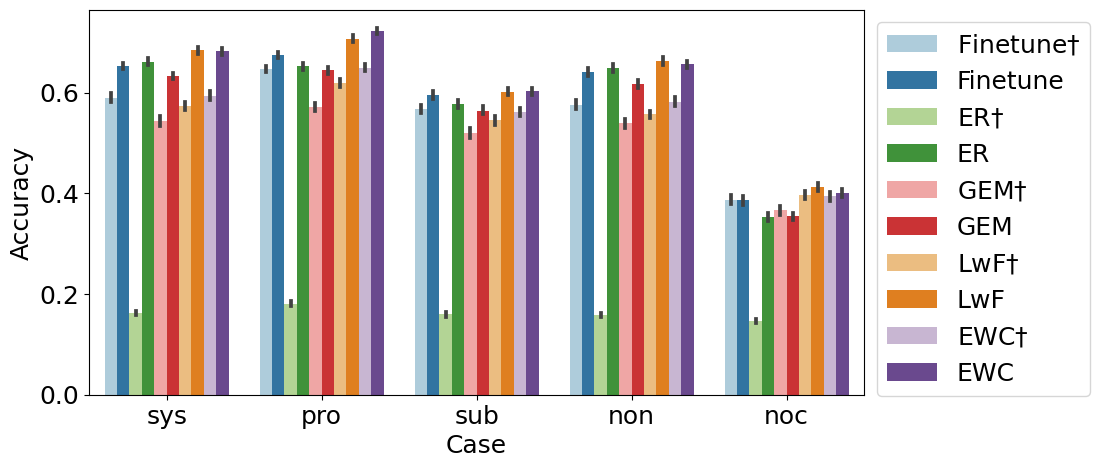

In [40]:
plt.figure(figsize=(10, 5))
sns.set_palette('Paired')
matplotlib.rcParams.update({'font.size': 18})

ax = sns.barplot(x='Case', y='Accuracy', hue='Method', data=data)
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

fig = ax.get_figure()
fig.savefig(os.path.join('D:', 'Downloads', 'output.png'), dpi = 400, bbox_inches='tight')

# show tsne of features on CGQA

In [33]:
# load model from LwF-cls

import torch
from torch.utils.data import DataLoader

from avalanche.benchmarks.utils import AvalancheSubset

from datasets.cgqa import _get_gqa_datasets, _build_default_transform
from models.resnet import get_resnet
from experiments.utils import set_seed, create_default_args, create_experiment_folder
from experiments.config import default_args

args = create_default_args(default_args, {'exp_name': 'Naive-cls'})

set_seed(args.seed)
device = torch.device(f"cuda:{args.cuda}"
                      if torch.cuda.is_available() and
                      args.cuda >= 0 else "cpu")

exp_path, checkpoint_path = create_experiment_folder(
    root=args.exp_root,
    exp_name=args.exp_name,
    project_name=args.project_name)

origin_model = get_resnet(
    multi_head=True,
    pretrained=True, pretrained_model_path=os.path.join(checkpoint_path, 'model.pth'),
    fix=args.test_freeze_feature_extractor,
)

origin_model.eval()

Exist experiment with path: \\172.18.36.77\datasets\avalanche-experiments\CGQA\Naive-cls
Load pretrained resnet18 model from \\172.18.36.77\datasets\avalanche-experiments\CGQA\Naive-cls\Checkpoints\model.pth.


MTResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [34]:

# modes = {'sys': [[('grass', 'shirt'), 0]],
#          'pro': [[('door', 'leaves', 'shirt', 'table'), 1]],
#          'sub': [[('grass', 'shirt'), 2]],
#          'noc': [[('bike', 'mirror'), 3]],
#          'non': [[('door', 'shirt'), 4], [('grass', 'table'), 5], [('hat', 'leaves'), 6]],
#          }
modes = {       # old objs
    'sys': [[('flower', 'helmet'), 0]],
    'non': [
        # [('bench', 'helmet'), 1],
            [('hat', 'helmet'), 1],
            # [('grass', 'helmet'), 1],
            [('bench', 'flower'), 2]]
}
# modes = {       # new objs
#     'sys': [[('building', 'car'), 0]],
#     'non': [[('building', 'fence'), 1],
#             # [('building', 'leaves'), 2], [('building', 'pants'), 3], [('building', 'plate'), 4], [('building', 'table'), 5],
#             [('car', 'door'), 2],
#             # [('car', 'jacket'), 7], [('car', 'leaves'), 8],
#             # [('car', 'plate'), 9], [('car', 'shirt'), 10], [('car', 'sign'), 11], [('car', 'table'), 12], [('car', 'wall'), 12],
#             ]
# }

features = []
labels = []

# mode = 'sys'
# for mode in ['sys', 'pro', 'sub', 'noc', 'non']:
for mode in ['sys', 'non']:
    print("=> mode ", mode)
    datasets, label_info = _get_gqa_datasets(args.dataset_root, mode=mode)
    dataset = datasets['dataset']

    label_set, map_tuple_label_to_int, map_int_label_to_tuple = label_info
    print(map_int_label_to_tuple)

    selected_labels = [map_tuple_label_to_int[l[0]] for l in modes[mode]]
    print('select', modes[mode], '; related label', selected_labels)

    for idx, label in enumerate(selected_labels):
        indices = np.where(np.array(dataset.targets) == label)[0]
        subset = AvalancheSubset(dataset, indices=indices, transform=_build_default_transform(is_train=False))
        dataloader = DataLoader(subset, batch_size=100)

        for x, y, t in dataloader:
            with torch.no_grad():
                feature = origin_model.resnet(x)      # return features
            features.append(feature.detach().cpu().numpy())
            labels.append([modes[mode][idx][1] for _ in range(100)])

features = np.concatenate(features)
labels = np.concatenate(labels)


=> mode  sys
{0: ('bench', 'building'), 1: ('bench', 'door'), 2: ('bench', 'hat'), 3: ('bench', 'leaves'), 4: ('building', 'car'), 5: ('building', 'grass'), 6: ('building', 'sign'), 7: ('building', 'wall'), 8: ('car', 'plate'), 9: ('car', 'shirt'), 10: ('flower', 'helmet'), 11: ('flower', 'pants'), 12: ('flower', 'wall'), 13: ('grass', 'shirt'), 14: ('grass', 'table'), 15: ('hat', 'leaves'), 16: ('helmet', 'plate'), 17: ('leaves', 'pants'), 18: ('pole', 'shirt'), 19: ('shirt', 'wall')}
select [[('flower', 'helmet'), 0]] ; related label [10]
=> mode  non
{0: ('bench', 'car'), 1: ('bench', 'chair'), 2: ('bench', 'fence'), 3: ('bench', 'flower'), 4: ('bench', 'hat'), 5: ('bench', 'helmet'), 6: ('bench', 'leaves'), 7: ('bench', 'plate'), 8: ('bench', 'shoe'), 9: ('bench', 'sign'), 10: ('bench', 'table'), 11: ('building', 'fence'), 12: ('building', 'helmet'), 13: ('building', 'jacket'), 14: ('building', 'leaves'), 15: ('building', 'pants'), 16: ('building', 'plate'), 17: ('building', 'table

C:\Users\ASUS\anaconda3\envs\avalanche-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\avalanche-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


{'sys': [[('flower', 'helmet'), 0]], 'non': [[('hat', 'helmet'), 1], [('bench', 'flower'), 2]]}


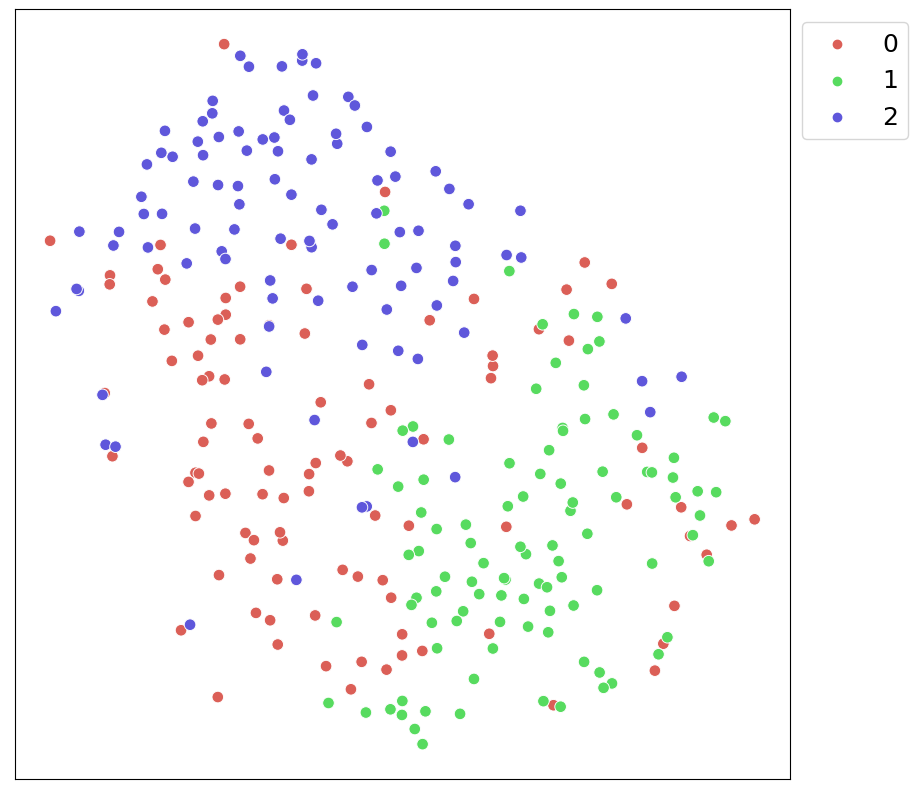

In [35]:
# get TSNE

from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=50, random_state=1234)      # 501, 1234
X = tsne.fit_transform(features)

# draw TSNE

plt.figure(figsize=(10, 10))
# sns.set_palette('Set2', 7)
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette=sns.color_palette('hls', max(labels)+1), s=70)
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xticks([])
plt.yticks([])

print(modes)

fig = ax.get_figure()
fig.savefig(os.path.join(exp_path, 'tsne.png'), dpi = 400, bbox_inches='tight')

# show tsne of features on CPIN

In [51]:

args = create_default_args(default_args, {'dataset': 'cpin', 'project_name': 'CPIN', 'exp_name': 'LwF-cls'})

set_seed(args.seed)
device = torch.device(f"cuda:{args.cuda}"
                      if torch.cuda.is_available() and
                      args.cuda >= 0 else "cpu")

exp_path, checkpoint_path = create_experiment_folder(
    root=args.exp_root,
    exp_name=args.exp_name,
    project_name=args.project_name)

origin_model = get_resnet(
    multi_head=True,
    pretrained=True, pretrained_model_path=os.path.join(checkpoint_path, 'model.pth'),
    fix=args.test_freeze_feature_extractor,
)

origin_model.eval()

Exist experiment with path: \\172.18.36.77\datasets\avalanche-experiments\CPIN\LwF-cls
Load pretrained resnet18 model from \\172.18.36.77\datasets\avalanche-experiments\CPIN\LwF-cls\Checkpoints\model.pth.


MTResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [57]:

from datasets.cpin import _get_pin_datasets

modes = {'sys': [[('Bird Head', 'Bovidae Body', 'Car Tier', 'Felidae Head', 'Snake Head'), 0]],
         'pro': [[('Bird Foot', 'Bird Head', 'Bovidae Foot', 'Lacertilia Head', 'Testudines Head', 'Ursidae Body', 'Ursidae Head'), 1]],
         'noc': [[('Aeroplane Engine', 'Aeroplane Head', 'Aeroplane Wing', 'Bicycle Head', 'Bicycle Tier'), 2]],
         'non': [[('Bird Foot', 'Bird Head', 'Car Tier', 'Snake Head', 'Ursidae Head'), 3],
                 [('Bovidae Body', 'Bovidae Foot', 'Canidae Head', 'Lacertilia Body', 'Primates Hand'), 4],
                 [('Bovidae Head', 'Canidae Foot', 'Lacertilia Foot', 'Mustelidae Foot', 'Snake Head'), 5],
                 [('Felidae Head', 'Lacertilia Head', 'Testudines Body', 'Testudines Head', 'Ursidae Body'), 6]],
         }

features = []
labels = []

# mode = 'sys'
for mode in ['sys', 'pro', 'noc', 'non']:
    print("=> mode ", mode)
    datasets, label_info = _get_pin_datasets(args.dataset_root, mode=mode)
    dataset = datasets['dataset']

    label_set, map_tuple_label_to_int, map_int_label_to_tuple = label_info
    print(map_int_label_to_tuple)

    selected_labels = [map_tuple_label_to_int[l[0]] for l in modes[mode]]
    print('select', modes[mode], '; related label', selected_labels)

    for idx, label in enumerate(selected_labels):
        indices = np.where(np.array(dataset.targets) == label)[0]
        subset = AvalancheSubset(dataset, indices=indices, transform=_build_default_transform(is_train=False))
        dataloader = DataLoader(subset, batch_size=100)

        for x, y, t in dataloader:
            with torch.no_grad():
                feature = origin_model.resnet(x)      # return features
            features.append(feature.detach().cpu().numpy())
            labels.append([modes[mode][idx][1] for _ in range(100)])

features = np.concatenate(features)
labels = np.concatenate(labels)

=> mode  sys
{0: ('Bird Body', 'Bird Foot', 'Canidae Foot', 'Testudines Head', 'Ursidae Head'), 1: ('Bird Body', 'Canidae Head', 'Car Tier', 'Primates Hand', 'Snake Head'), 2: ('Bird Body', 'Car Tier', 'Lacertilia Foot', 'Primates Foot', 'Snake Body'), 3: ('Bird Head', 'Bird Wing', 'Mustelidae Head', 'Primates Head', 'Snake Body'), 4: ('Bird Head', 'Bovidae Body', 'Car Tier', 'Felidae Head', 'Snake Head'), 5: ('Bird Head', 'Fish Body', 'Fish Fin', 'Primates Hand', 'Ursidae Foot'), 6: ('Bird Wing', 'Bovidae Body', 'Bovidae Head', 'Lacertilia Body', 'Ursidae Head'), 7: ('Bird Wing', 'Bovidae Foot', 'Canidae Body', 'Fish Head', 'Mustelidae Foot'), 8: ('Bird Wing', 'Bovidae Head', 'Car Tier', 'Felidae Body', 'Ursidae Foot'), 9: ('Bovidae Head', 'Canidae Foot', 'Lacertilia Foot', 'Lacertilia Head', 'Mustelidae Head'), 10: ('Canidae Body', 'Car Body', 'Mustelidae Foot', 'Primates Body', 'Snake Head'), 11: ('Canidae Foot', 'Felidae Body', 'Fish Head', 'Mustelidae Foot', 'Snake Head'), 12: ('C

C:\Users\ASUS\anaconda3\envs\avalanche-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ASUS\anaconda3\envs\avalanche-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


{'sys': [[('Bird Head', 'Bovidae Body', 'Car Tier', 'Felidae Head', 'Snake Head'), 0]], 'pro': [[('Bird Foot', 'Bird Head', 'Bovidae Foot', 'Lacertilia Head', 'Testudines Head', 'Ursidae Body', 'Ursidae Head'), 1]], 'noc': [[('Aeroplane Engine', 'Aeroplane Head', 'Aeroplane Wing', 'Bicycle Head', 'Bicycle Tier'), 2]], 'non': [[('Bird Foot', 'Bird Head', 'Car Tier', 'Snake Head', 'Ursidae Head'), 3], [('Bovidae Body', 'Bovidae Foot', 'Canidae Head', 'Lacertilia Body', 'Primates Hand'), 4], [('Bovidae Head', 'Canidae Foot', 'Lacertilia Foot', 'Mustelidae Foot', 'Snake Head'), 5], [('Felidae Head', 'Lacertilia Head', 'Testudines Body', 'Testudines Head', 'Ursidae Body'), 6]]}


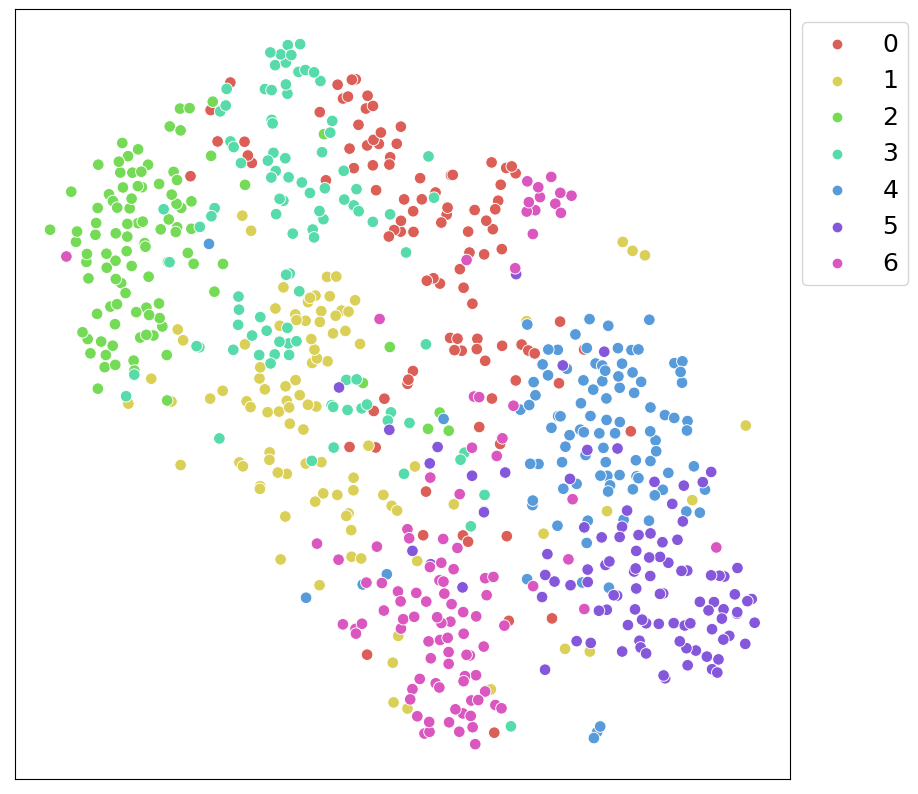

In [61]:
# get TSNE

from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, random_state=1234)
X = tsne.fit_transform(features)

# draw TSNE

plt.figure(figsize=(10, 10))
# sns.set_palette('Set2', 7)
matplotlib.rcParams.update({'font.size': 18})

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette=sns.color_palette('hls', 7), s=70)
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xticks([])
plt.yticks([])

print(modes)

fig = ax.get_figure()
fig.savefig(os.path.join(exp_path, 'tsne.png'), dpi = 400, bbox_inches='tight')